The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
#All the imports that I will need?


import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


20


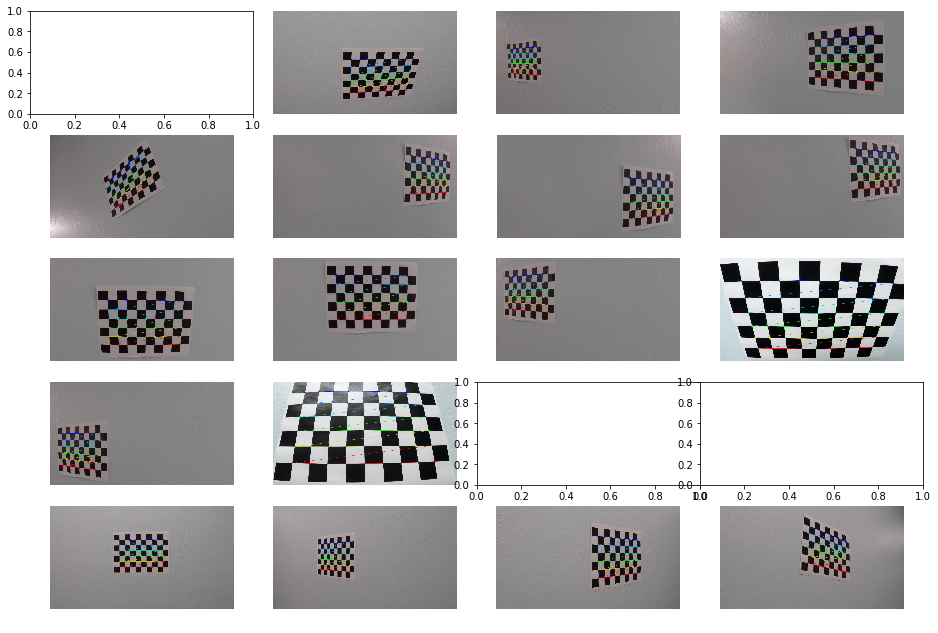

In [2]:
#Chessboard corners
nx = 9
ny = 6

# Empty array for the objpoints and imgpoints
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in the image plane

#Read in all my images
images_to_calibrate = glob.glob("camera_cal/calibration*.jpg")

#DEBUG
print(len(images_to_calibrate))

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
 

# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images_to_calibrate):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        axs[idx].axis('off')
        axs[idx].imshow(img)



Not sure why it couldnt find the corners for all the images. Limitations of the cv2 component?

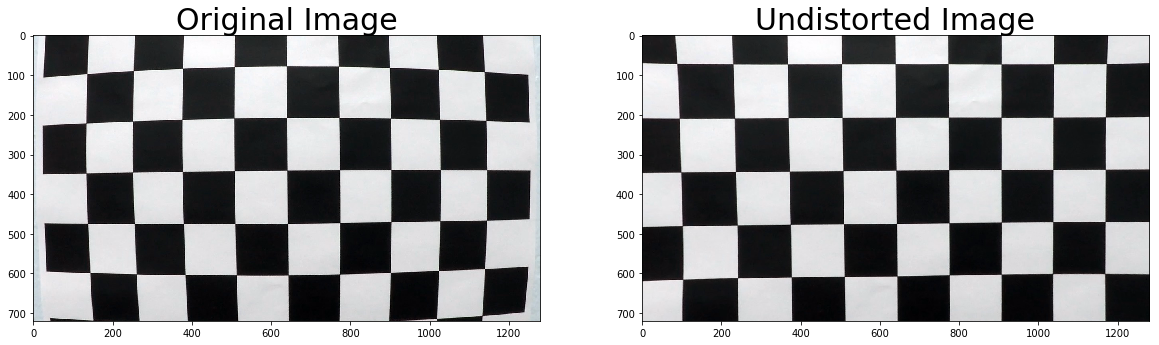

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_result.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Apply a distortion correction to raw images.

## Pipeline (single images)


### Apply a distortion correction to raw images.


#### 1. Provide an example of a distortion-corrected image.

In [4]:
with open("calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]


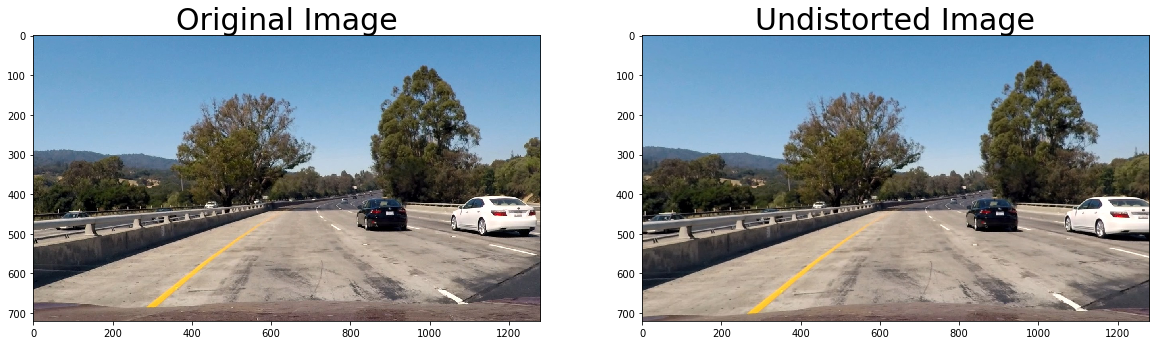

In [5]:
raw = cv2.imread("test_images/test1.jpg")
raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

### Use color transforms, gradients, etc., to create a thresholded binary image.

**Sobel Threshold**

In [6]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

**Gradient Threshold**

In [7]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


**Direction Threshold**

In [8]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

**Variant without the HLS color space**

In [9]:
def apply_combined_threshold(image, ksize = 3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 250))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.6, 1.2))
    
    # Combine the thresholds.
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

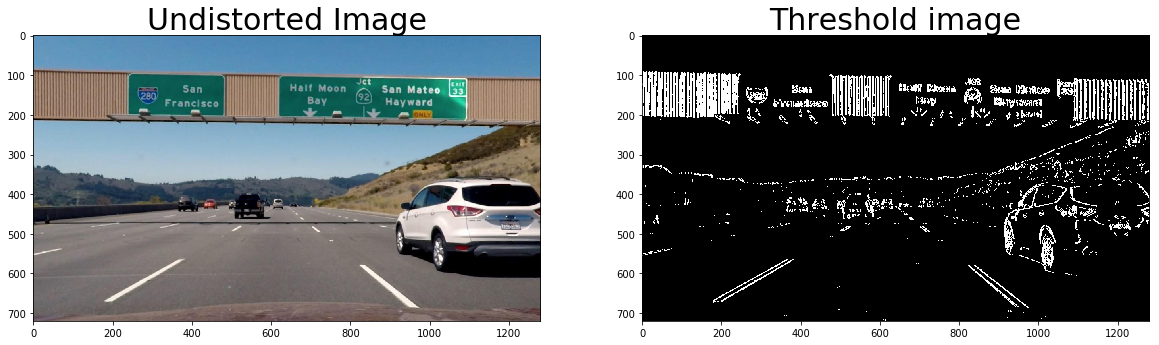

In [10]:
raw = cv2.imread("test_images/signs_vehicles_xygrad.jpg")
raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)

image = cv2.undistort(raw, mtx, dist, None, mtx)

imtoshow = abs_sobel_thresh(image, orient='x', sobel_kernel=1, thresh=(20, 200))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(imtoshow, cmap='gray')
ax2.set_title('Threshold image', fontsize=30)

# def update(min_thresh, max_thresh):
#     imtoshow = dir_threshold(image, 3, (min_thresh, max_thresh))
#     # Visualize sobel absolute threshold
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     f.subplots_adjust(hspace = .2, wspace=.05)
#     ax1.imshow(image)
#     ax1.set_title('Unwarped Image', fontsize=30)
#     ax2.imshow(imtoshow, cmap='gray')
#     ax2.set_title('Sobel Absolute', fontsize=30)

# interact(update, 
#                  min_thresh=(0,np.pi/2,0.01), 
#                  max_thresh=(0,np.pi/2,0.01))

**Sample image with the simple threshold application.**

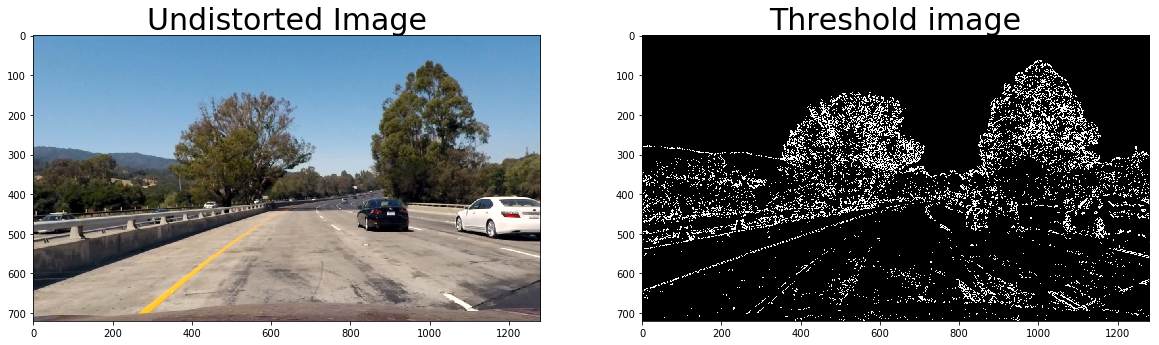

In [11]:
raw = cv2.imread("test_images/test1.jpg")
raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)

image = cv2.undistort(raw, mtx, dist, None, mtx)

image_combined_bin = apply_combined_threshold(image, ksize=3)

#plt.imshow(image_combined_bin, cmap='gray')

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(image_combined_bin, cmap='gray')
ax2.set_title('Threshold image', fontsize=30)


As you can see, getting the yellow line to appear in this image is becoming a real pain. This can easily be attributed to grayscale images loosing a lot of data. This is not a good appraoch to take. Thus will be using the HLS threshold mechanism.


**With the HLS conversion**

In [12]:
def apply_hls_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( sxbinary, np.zeros_like(sxbinary), s_binary)) * 255
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary



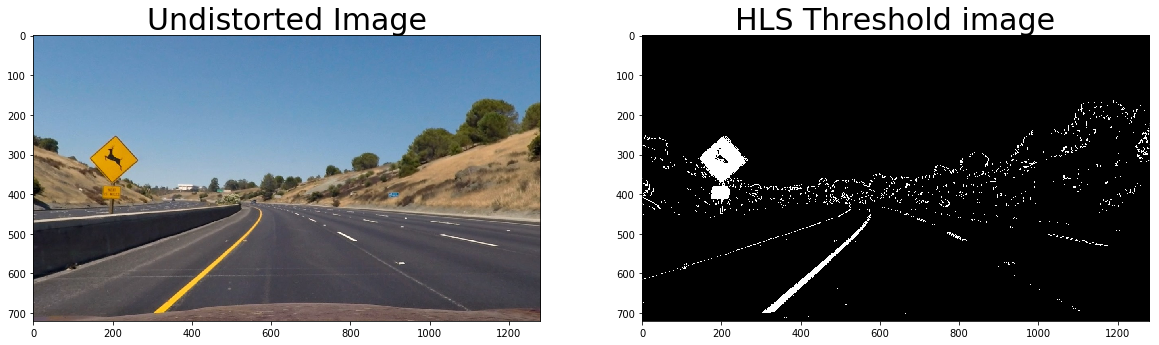

In [13]:
raw = cv2.imread("test_images/test2.jpg")
raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)

image = cv2.undistort(raw, mtx, dist, None, mtx)

image_thresholded=apply_hls_threshold(image, sx_thresh=(40,100))

# Visualize undistortion
f, axs = plt.subplots(1, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].imshow(image)
axs[0].set_title('Undistorted Image', fontsize=30)
axs[1].imshow(image_thresholded, cmap='gray')
axs[1].set_title('HLS Threshold image', fontsize=30)

As seen from the above image, its much easier to get the lane lines when I try to use a different color space.

### Apply a perspective transform to rectify binary image ("birds-eye view").

In [14]:
# Apply a region of interest for the given vertices
def apply_region_of_interest(image, vertices):
    masked_img = np.zeros_like(image)
    cv2.fillPoly(masked_img, vertices, 255)
    
    # returning the image only where mask pixels are nonzero
    masked_img = cv2.bitwise_and(image, masked_img)
    return masked_img

In [15]:
print(raw.shape)

(720, 1280, 3)


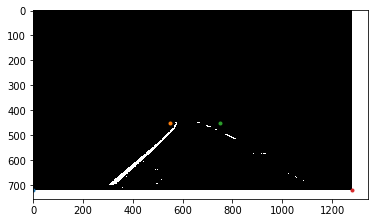

In [16]:
image_shape = raw.shape
h,w = raw.shape[:2]

mask_vertices = np.array([[(0,h),(550, 450), (750, 450), (w,h)]], dtype=np.int32)
masked_image = apply_region_of_interest(image_thresholded, mask_vertices)

plt.imshow(masked_image, cmap="gray")
plt.plot(0, h, '.')
plt.plot(550, 450, '.')
plt.plot(750, 450, '.')
plt.plot(w, h, '.')

In [17]:
def warp(img):
    img_size = (img.shape[1],img.shape[0])
    src = np.float32(
        [[150, 720],
         [550, 480],
         [750, 480],
         [1200, 720]])
    
    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

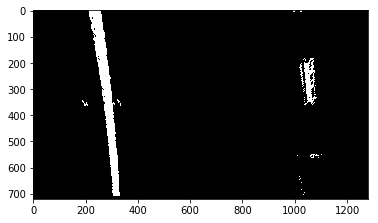

In [18]:
warp_img, Minv = warp(masked_image)
plt.imshow(warp_img, cmap="gray")

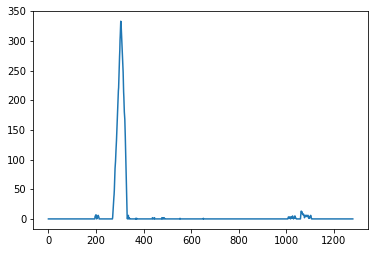

In [19]:
import numpy as np
histogram = np.sum(warp_img[warp_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [20]:
binary_warped = warp_img

### Detect lane pixels and fit to find the lane boundary.

In [21]:
def sliding_window_polynomial(binary_warped):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

(720, 0)

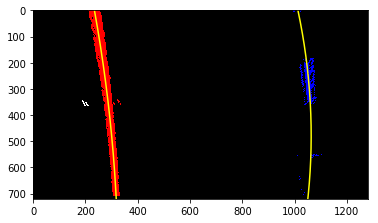

In [22]:
left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_polynomial(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [23]:
def skip_windows_polynomial(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    print(left_fit)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

[ -6.84835818e-05   1.65213248e-01   2.35732590e+02]


(720, 0)

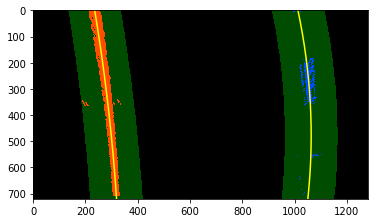

In [24]:
left_fit, right_fit, left_lane_inds, right_lane_inds = skip_windows_polynomial(binary_warped, left_fit, right_fit)
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
margin = 100
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [25]:
def lane_poly(yval, poly_coeffs):
    """Returns x value for poly given a y-value.
    Note here x = Ay^2 + By + C."""
    return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]

In [26]:
def draw_poly(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

Left coeffs:  [ -6.84835818e-05   1.65213248e-01   2.35732590e+02]
Right fit:  [ -2.20239961e-04   2.11031283e-01   1.01269733e+03]


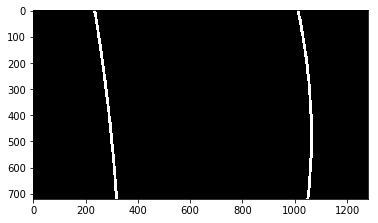

In [27]:
print("Left coeffs: ", left_fit)
print("Right fit: ", right_fit)
blank_canvas = np.zeros((720, 1280))
polyfit_left = draw_poly(blank_canvas, lane_poly, left_fit, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_fit, 30)
plt.imshow(polyfit_drawn, cmap="gray")

### Determine the curvature of the lane and vehicle position with respect to center

In [28]:

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad_old = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad_old = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad_old, right_curverad_old)


def get_curvature_center(binary_warped, left_fit, right_fit):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = lane_poly(ploty, left_fit)
    right_fitx = lane_poly(ploty, right_fit)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm', center, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad, center

get_curvature_center(binary_warped, left_fit, right_fit)

7349.84588558 2308.38466485


(2398.3030293084585, 745.87280527088058, 0.23693663605175394)

### Warp the detected lane boundaries back onto the original image.

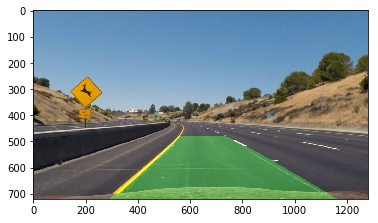

In [29]:
warp_zero = np.zeros_like(warp_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [30]:
def add_data_to_image(image, left_rad, right_rad, vehicle_center):
    tmp_img = np.copy(image)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    direction = "left" if vehicle_center < 0 else "right"
    curv_rad = (left_rad + right_rad) / 2.0
    abs_center = abs(vehicle_center)
    
    cv2.putText(tmp_img, 'Radius of Curvature = %d(m)' % curv_rad, (50, 50), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(tmp_img, 'Right Curvature = %d(m)' % right_rad, (50, 100), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(tmp_img, 'Left Curvature = %d(m)' % left_rad, (50, 150), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(tmp_img, 'Vehicle is %.2fm %s of center' % (abs_center, direction), (50, 200), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

    return tmp_img
    

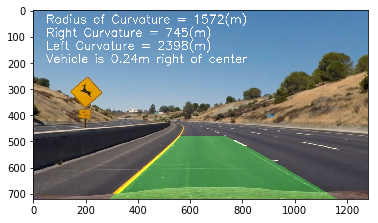

In [31]:
left_curverad, right_curverad, center = get_curvature_center(binary_warped, left_fit, right_fit)
img_to_disp = add_data_to_image(result, left_curverad, right_curverad, center)
plt.imshow(img_to_disp)

### Image processing pipeline

In [32]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    # (Inspiration from https://github.com/jeremy-shannon/CarND-Advanced-Lane-Lines/blob/master/project.ipynb)
    def add(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [33]:
prev_left_fit = None
prev_right_fit = None

def reset_prev_fit():
    global prev_left_fit
    global prev_right_fit
    prev_left_fit = Line()
    prev_right_fit = Line()

def process_image(image):
    global prev_left_fit
    global prev_right_fit
    raw = np.copy(image)
    
    # Undistort the image
    image_undistorted = cv2.undistort(raw, mtx, dist, None, mtx)
    # Apply HLS threshold
    binary_threshold = apply_hls_threshold(image_undistorted, sx_thresh=(40,100))
    # Mask the image
    mask_vertices = np.array([[(0,h),(550, 450), (750, 450), (w,h)]], dtype=np.int32)
    masked_image = apply_region_of_interest(binary_threshold, mask_vertices)
    # Warp the masked region
    binary_warped, Minv = warp(masked_image)
    
    
    if not prev_left_fit.detected or not prev_right_fit.detected:
        print("Not detected")
        left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_polynomial(binary_warped)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = \
        skip_windows_polynomial(binary_warped, prev_left_fit.best_fit, prev_right_fit.best_fit)
        
    
    if left_fit is not None and right_fit is not None:
        left_fit_inds = lane_poly(image.shape[0], left_fit)
        right_fit_inds = lane_poly(image.shape[0], right_fit)
        # We will reject any lane_fits if the length of the x-intercepts is 750 +-100 
        x_int_len = abs(right_fit_inds - left_fit_inds)
        if abs(x_int_len - 750.0) > 100:
            left_fit = None
            right_fit = None
    
    prev_left_fit.add(left_fit, left_lane_inds)
    prev_right_fit.add(right_fit, right_lane_inds)
    
    if prev_left_fit.best_fit is not None and prev_right_fit.best_fit is not None:
        left_fit = prev_left_fit.best_fit
        right_fit = prev_right_fit.best_fit
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = lane_poly(ploty, left_fit)
        right_fitx = lane_poly(ploty, right_fit)
        
        left_curverad, right_curverad, center = get_curvature_center(binary_warped, left_fit, right_fit)
        
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        img_to_disp = add_data_to_image(result, left_curverad, right_curverad, center)
        # DEBUG (Helped me catch a stupid initialization issue with the prev_right_fit)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img_to_disp, 'Left count = %d Right Count = %d' % (len(prev_left_fit.current_fit), len(prev_right_fit.current_fit)), (50, 250), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    else:
        img_to_disp = raw
    
    return img_to_disp
    

Test the pipeline

Not detected


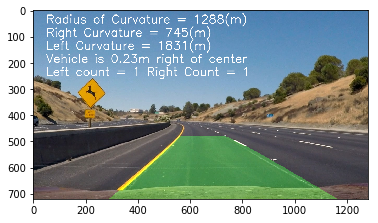

In [34]:
raw = cv2.imread("test_images/test2.jpg")
raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)

reset_prev_fit()

plt.imshow(process_image(raw))

## Final Video pipeline

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
reset_prev_fit()

output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

Not detected
[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

[ -7.01000254e-05   1.60113974e-01   2.33609241e+02]


  0%|                                                                                 | 1/1261 [00:00<03:31,  5.94it/s]

[ -8.67186765e-05   1.69171802e-01   2.34314232e+02]


  0%|▏                                                                                | 2/1261 [00:00<03:31,  5.94it/s]

[ -1.02151876e-04   1.77957317e-01   2.35225868e+02]


  0%|▏                                                                                | 3/1261 [00:00<03:33,  5.88it/s]

[ -1.21072175e-04   1.94728508e-01   2.32927398e+02]


  0%|▎                                                                                | 4/1261 [00:00<03:33,  5.89it/s]

[ -1.06250450e-04   1.88792042e-01   2.33741064e+02]


  0%|▎                                                                                | 5/1261 [00:00<03:38,  5.75it/s]

[ -1.14104067e-04   2.02450747e-01   2.30256341e+02]


  0%|▍                                                                                | 6/1261 [00:01<03:34,  5.84it/s]

[ -1.08242689e-04   2.03483024e-01   2.28354841e+02]


  1%|▍                                                                                | 7/1261 [00:01<03:30,  5.95it/s]

[ -9.66456676e-05   1.95773760e-01   2.30834417e+02]


  1%|▌                                                                                | 8/1261 [00:01<03:28,  6.02it/s]

[ -9.40230758e-05   1.99252954e-01   2.26647837e+02]


  1%|▌                                                                                | 9/1261 [00:01<03:28,  6.02it/s]

[ -1.07940930e-04   2.13078865e-01   2.22487408e+02]


  1%|▋                                                                               | 10/1261 [00:01<03:27,  6.04it/s]

[ -1.11614005e-04   2.18545649e-01   2.20419093e+02]


  1%|▋                                                                               | 11/1261 [00:01<03:29,  5.95it/s]

[ -1.05557088e-04   2.21808327e-01   2.13258748e+02]


  1%|▊                                                                               | 12/1261 [00:02<03:27,  6.02it/s]

[ -1.10460185e-04   2.27173424e-01   2.11792297e+02]


  1%|▊                                                                               | 13/1261 [00:02<03:24,  6.09it/s]

[ -1.14282531e-04   2.31658360e-01   2.10079914e+02]


  1%|▉                                                                               | 14/1261 [00:02<03:23,  6.11it/s]

[ -1.36847205e-04   2.46070364e-01   2.10024056e+02]


  1%|▉                                                                               | 15/1261 [00:02<03:31,  5.89it/s]

[ -1.37224377e-04   2.48674709e-01   2.09836762e+02]


  1%|█                                                                               | 16/1261 [00:02<03:38,  5.69it/s]

[ -1.21040992e-04   2.42614049e-01   2.07431074e+02]


  1%|█                                                                               | 17/1261 [00:02<03:42,  5.58it/s]

[ -9.70218051e-05   2.25496721e-01   2.09344714e+02]


  1%|█▏                                                                              | 18/1261 [00:03<03:40,  5.64it/s]

[ -9.58428443e-05   2.28070216e-01   2.05358786e+02]


  2%|█▏                                                                              | 19/1261 [00:03<03:36,  5.75it/s]

[ -7.85453382e-05   2.17687939e-01   2.03746090e+02]


  2%|█▎                                                                              | 20/1261 [00:03<03:33,  5.80it/s]

[ -5.66990137e-05   2.06843971e-01   2.00818687e+02]


  2%|█▎                                                                              | 21/1261 [00:03<03:34,  5.78it/s]

[ -3.59466258e-05   1.95062881e-01   1.97626297e+02]


  2%|█▍                                                                              | 22/1261 [00:03<03:37,  5.69it/s]

[ -3.69254620e-05   1.95630546e-01   1.94314180e+02]


  2%|█▍                                                                              | 23/1261 [00:03<03:42,  5.57it/s]

[ -1.60680046e-05   1.71476036e-01   1.99451140e+02]


  2%|█▌                                                                              | 24/1261 [00:04<03:53,  5.31it/s]

[ -1.90848324e-05   1.65726502e-01   2.02104353e+02]


  2%|█▌                                                                              | 25/1261 [00:04<03:43,  5.54it/s]

[ -2.92153508e-05   1.72435923e-01   1.98683809e+02]


  2%|█▋                                                                              | 26/1261 [00:04<03:47,  5.43it/s]

[ -3.64854638e-05   1.72556828e-01   1.99274065e+02]


  2%|█▋                                                                              | 27/1261 [00:04<03:42,  5.56it/s]

[ -4.33653811e-05   1.77859927e-01   1.95066815e+02]


  2%|█▊                                                                              | 28/1261 [00:04<03:41,  5.56it/s]

[ -6.97263924e-05   1.92794140e-01   1.95723249e+02]


  2%|█▊                                                                              | 29/1261 [00:05<03:40,  5.60it/s]

[ -6.52357996e-05   1.80356999e-01   2.02665216e+02]


  2%|█▉                                                                              | 30/1261 [00:05<03:37,  5.67it/s]

[ -7.44506271e-05   1.81158975e-01   2.06758019e+02]


  2%|█▉                                                                              | 31/1261 [00:05<03:33,  5.77it/s]

[ -8.12636851e-05   1.79366827e-01   2.12080915e+02]


  3%|██                                                                              | 32/1261 [00:05<03:34,  5.73it/s]

[ -7.91967323e-05   1.81738538e-01   2.08964250e+02]


  3%|██                                                                              | 33/1261 [00:05<03:39,  5.61it/s]

[ -7.55262550e-05   1.74060554e-01   2.13703684e+02]


  3%|██▏                                                                             | 34/1261 [00:05<03:39,  5.58it/s]

[ -8.57300461e-05   1.81851315e-01   2.14268644e+02]


  3%|██▏                                                                             | 35/1261 [00:06<03:35,  5.69it/s]

[ -9.71657843e-05   1.89954569e-01   2.15900680e+02]


  3%|██▎                                                                             | 36/1261 [00:06<03:32,  5.78it/s]

[ -9.52981937e-05   1.87202810e-01   2.17867385e+02]


  3%|██▎                                                                             | 37/1261 [00:06<03:35,  5.69it/s]

[ -1.05774186e-04   1.93913265e-01   2.19019408e+02]


  3%|██▍                                                                             | 38/1261 [00:06<03:39,  5.58it/s]

[ -1.19619004e-04   2.03455182e-01   2.19795770e+02]


  3%|██▍                                                                             | 39/1261 [00:06<03:32,  5.74it/s]

[ -1.25417892e-04   2.09981097e-01   2.17843030e+02]


  3%|██▌                                                                             | 40/1261 [00:06<03:29,  5.84it/s]

[ -1.34667074e-04   2.18354333e-01   2.16746134e+02]


  3%|██▌                                                                             | 41/1261 [00:07<03:27,  5.89it/s]

[ -1.39773112e-04   2.25149156e-01   2.15527894e+02]


  3%|██▋                                                                             | 42/1261 [00:07<03:21,  6.04it/s]

[ -1.33125092e-04   2.27011423e-01   2.13656466e+02]


  3%|██▋                                                                             | 43/1261 [00:07<03:22,  6.01it/s]

[ -1.36964653e-04   2.34790117e-01   2.09844654e+02]


  3%|██▊                                                                             | 44/1261 [00:07<03:36,  5.63it/s]

[ -1.25832548e-04   2.31601823e-01   2.07848487e+02]


  4%|██▊                                                                             | 45/1261 [00:07<03:41,  5.49it/s]

[ -1.34844190e-04   2.40363180e-01   2.05504469e+02]


  4%|██▉                                                                             | 46/1261 [00:08<03:38,  5.57it/s]

[ -1.23748169e-04   2.36365663e-01   2.02984232e+02]


  4%|██▉                                                                             | 47/1261 [00:08<03:30,  5.75it/s]

[ -1.29385738e-04   2.43482598e-01   2.01345797e+02]


  4%|███                                                                             | 48/1261 [00:08<03:27,  5.85it/s]

[ -1.23975618e-04   2.44849114e-01   1.97026128e+02]


  4%|███                                                                             | 49/1261 [00:08<03:23,  5.94it/s]

[ -1.32978163e-04   2.55160512e-01   1.94375759e+02]


  4%|███▏                                                                            | 50/1261 [00:08<03:21,  6.00it/s]

[ -1.34844002e-04   2.60737120e-01   1.91614186e+02]


  4%|███▏                                                                            | 51/1261 [00:08<03:29,  5.76it/s]

[ -1.46829578e-04   2.69230851e-01   1.91255261e+02]


  4%|███▎                                                                            | 52/1261 [00:09<03:25,  5.89it/s]

[ -1.40362321e-04   2.66013520e-01   1.90861357e+02]


  4%|███▎                                                                            | 53/1261 [00:09<03:24,  5.91it/s]

[ -1.44330018e-04   2.72066906e-01   1.88274981e+02]


  4%|███▍                                                                            | 54/1261 [00:09<03:23,  5.92it/s]

[ -1.33275550e-04   2.69949585e-01   1.85582014e+02]


  4%|███▍                                                                            | 55/1261 [00:09<03:25,  5.86it/s]

[ -1.14979164e-04   2.60567134e-01   1.83631579e+02]


  4%|███▌                                                                            | 56/1261 [00:09<03:31,  5.69it/s]

[ -9.22006543e-05   2.42455062e-01   1.85762171e+02]


  5%|███▌                                                                            | 57/1261 [00:09<03:33,  5.65it/s]

[ -7.85579729e-05   2.33576319e-01   1.85073449e+02]


  5%|███▋                                                                            | 58/1261 [00:10<03:29,  5.75it/s]

[ -5.58503266e-05   2.10282133e-01   1.91642617e+02]


  5%|███▋                                                                            | 59/1261 [00:10<03:25,  5.84it/s]

[ -3.65296925e-05   1.88975516e-01   1.97342800e+02]


  5%|███▊                                                                            | 60/1261 [00:10<03:23,  5.91it/s]

[ -2.75963680e-05   1.77020194e-01   1.99643416e+02]


  5%|███▊                                                                            | 61/1261 [00:10<03:24,  5.87it/s]

[ -2.36453535e-05   1.66392934e-01   2.03864533e+02]


  5%|███▉                                                                            | 62/1261 [00:10<03:34,  5.58it/s]

[ -2.28910631e-05   1.62129858e-01   2.03598580e+02]


  5%|███▉                                                                            | 63/1261 [00:10<03:30,  5.68it/s]

[ -2.75677419e-05   1.57882136e-01   2.07161265e+02]


  5%|████                                                                            | 64/1261 [00:11<03:27,  5.76it/s]

[ -3.86608937e-05   1.63261553e-01   2.05082247e+02]


  5%|████                                                                            | 65/1261 [00:11<03:25,  5.81it/s]

[ -5.71040126e-05   1.69148115e-01   2.07316596e+02]


  5%|████▏                                                                           | 66/1261 [00:11<03:22,  5.91it/s]

[ -6.82576672e-05   1.75472090e-01   2.06130321e+02]


  5%|████▎                                                                           | 67/1261 [00:11<03:23,  5.88it/s]

[ -6.90885389e-05   1.78439153e-01   2.03291445e+02]


  5%|████▎                                                                           | 68/1261 [00:11<03:24,  5.85it/s]

[ -9.95494952e-05   1.96409674e-01   2.03411367e+02]


  5%|████▍                                                                           | 69/1261 [00:11<03:21,  5.92it/s]

[ -1.18364113e-04   2.12818802e-01   1.98163030e+02]


  6%|████▍                                                                           | 70/1261 [00:12<03:18,  6.00it/s]

[ -1.27509876e-04   2.20190225e-01   1.97290765e+02]


  6%|████▌                                                                           | 71/1261 [00:12<03:19,  5.96it/s]

[ -1.33999509e-04   2.29945674e-01   1.92625539e+02]


  6%|████▌                                                                           | 72/1261 [00:12<03:23,  5.84it/s]

[ -1.36759348e-04   2.37384311e-01   1.88525198e+02]


  6%|████▋                                                                           | 73/1261 [00:12<03:25,  5.77it/s]

[ -1.22748489e-04   2.29881887e-01   1.87871564e+02]


  6%|████▋                                                                           | 74/1261 [00:12<03:29,  5.67it/s]

[ -1.20471366e-04   2.34389131e-01   1.82523828e+02]


  6%|████▊                                                                           | 75/1261 [00:12<03:28,  5.70it/s]

[ -1.13725157e-04   2.31031761e-01   1.82610214e+02]


  6%|████▊                                                                           | 76/1261 [00:13<03:27,  5.70it/s]

[ -9.27056369e-05   2.22695766e-01   1.76609693e+02]


  6%|████▉                                                                           | 77/1261 [00:13<03:26,  5.72it/s]

[ -8.09852070e-05   2.18238565e-01   1.73907323e+02]


  6%|████▉                                                                           | 78/1261 [00:13<03:31,  5.59it/s]

[ -5.59619070e-05   1.99116047e-01   1.73542348e+02]


  6%|█████                                                                           | 79/1261 [00:13<03:29,  5.64it/s]

[ -4.75760206e-05   1.88585965e-01   1.74692594e+02]


  6%|█████                                                                           | 80/1261 [00:13<03:29,  5.63it/s]

[ -2.41279870e-05   1.71060886e-01   1.77001272e+02]


  6%|█████▏                                                                          | 81/1261 [00:14<03:27,  5.70it/s]

[ -2.49871284e-05   1.70261752e-01   1.74922669e+02]


  7%|█████▏                                                                          | 82/1261 [00:14<03:25,  5.75it/s]

[ -1.74239721e-05   1.59781764e-01   1.76180270e+02]


  7%|█████▎                                                                          | 83/1261 [00:14<03:25,  5.73it/s]

[ -2.36797342e-05   1.68331683e-01   1.69032804e+02]


  7%|█████▎                                                                          | 84/1261 [00:14<03:23,  5.77it/s]

[ -2.10185428e-05   1.61208395e-01   1.71120783e+02]


  7%|█████▍                                                                          | 85/1261 [00:14<03:24,  5.74it/s]

[ -2.25417674e-05   1.54952209e-01   1.74447696e+02]


  7%|█████▍                                                                          | 86/1261 [00:14<03:29,  5.60it/s]

[ -2.34035765e-05   1.39589418e-01   1.85967252e+02]


  7%|█████▌                                                                          | 87/1261 [00:15<03:28,  5.64it/s]

[ -3.91182891e-05   1.41763483e-01   1.91834073e+02]


  7%|█████▌                                                                          | 88/1261 [00:15<03:28,  5.64it/s]

[ -4.31016193e-05   1.35283057e-01   1.97850212e+02]


  7%|█████▋                                                                          | 89/1261 [00:15<03:28,  5.63it/s]

[ -4.86819010e-05   1.30669434e-01   2.06415273e+02]


  7%|█████▋                                                                          | 90/1261 [00:15<03:27,  5.64it/s]

[ -6.31145959e-05   1.42089657e-01   2.03844590e+02]


  7%|█████▊                                                                          | 91/1261 [00:15<03:25,  5.70it/s]

[ -6.55821743e-05   1.46291355e-01   2.03313986e+02]


  7%|█████▊                                                                          | 92/1261 [00:15<03:26,  5.67it/s]

[ -7.22770708e-05   1.47647532e-01   2.07177656e+02]


  7%|█████▉                                                                          | 93/1261 [00:16<03:22,  5.76it/s]

[ -8.80545665e-05   1.58599615e-01   2.08009573e+02]


  7%|█████▉                                                                          | 94/1261 [00:16<03:20,  5.82it/s]

[ -9.67143485e-05   1.67545157e-01   2.05093908e+02]


  8%|██████                                                                          | 95/1261 [00:16<03:32,  5.47it/s]

[ -1.06630659e-04   1.75762113e-01   2.04167625e+02]


  8%|██████                                                                          | 96/1261 [00:16<03:28,  5.60it/s]

[ -1.07079135e-04   1.78417517e-01   2.04169779e+02]


  8%|██████▏                                                                         | 97/1261 [00:16<03:35,  5.41it/s]

[ -1.05312262e-04   1.83215463e-01   2.00525638e+02]


  8%|██████▏                                                                         | 98/1261 [00:17<03:33,  5.44it/s]

[ -1.00280778e-04   1.80021411e-01   2.02473283e+02]


  8%|██████▎                                                                         | 99/1261 [00:17<03:30,  5.52it/s]

[ -9.28298854e-05   1.76810480e-01   2.01670461e+02]


  8%|██████▎                                                                        | 100/1261 [00:17<03:28,  5.57it/s]

[ -8.58901007e-05   1.70185792e-01   2.04682259e+02]


  8%|██████▎                                                                        | 101/1261 [00:17<03:29,  5.55it/s]

[ -9.12054889e-05   1.73402617e-01   2.05748244e+02]


  8%|██████▍                                                                        | 102/1261 [00:17<03:31,  5.47it/s]

[ -8.30190530e-05   1.68937994e-01   2.06596914e+02]


  8%|██████▍                                                                        | 103/1261 [00:17<03:32,  5.44it/s]

[ -8.33335464e-05   1.68063596e-01   2.08530871e+02]


  8%|██████▌                                                                        | 104/1261 [00:18<03:34,  5.38it/s]

[ -7.91172301e-05   1.69100581e-01   2.05177319e+02]


  8%|██████▌                                                                        | 105/1261 [00:18<03:35,  5.37it/s]

[ -6.62274027e-05   1.63685700e-01   2.04853775e+02]


  8%|██████▋                                                                        | 106/1261 [00:18<03:36,  5.34it/s]

[ -7.04784728e-05   1.68105185e-01   2.03492251e+02]


  8%|██████▋                                                                        | 107/1261 [00:18<03:34,  5.38it/s]

[ -7.96345317e-05   1.71047710e-01   2.07864787e+02]


  9%|██████▊                                                                        | 108/1261 [00:18<03:28,  5.52it/s]

[ -7.38737870e-05   1.64743277e-01   2.10046901e+02]


  9%|██████▊                                                                        | 109/1261 [00:19<03:30,  5.47it/s]

[ -7.26053387e-05   1.63692307e-01   2.10387743e+02]


  9%|██████▉                                                                        | 110/1261 [00:19<03:27,  5.55it/s]

[ -7.98451051e-05   1.66877850e-01   2.12047059e+02]


  9%|██████▉                                                                        | 111/1261 [00:19<03:31,  5.45it/s]

[ -8.32950003e-05   1.73726224e-01   2.07391652e+02]


  9%|███████                                                                        | 112/1261 [00:19<03:28,  5.51it/s]

[ -8.64355189e-05   1.71475326e-01   2.12238080e+02]


  9%|███████                                                                        | 113/1261 [00:19<03:27,  5.55it/s]

[ -8.91334791e-05   1.72059192e-01   2.14118238e+02]


  9%|███████▏                                                                       | 114/1261 [00:20<03:30,  5.45it/s]

[ -1.04690861e-04   1.79330650e-01   2.17477876e+02]


  9%|███████▏                                                                       | 115/1261 [00:20<03:30,  5.44it/s]

[ -1.11603167e-04   1.84255052e-01   2.18027793e+02]


  9%|███████▎                                                                       | 116/1261 [00:20<03:23,  5.63it/s]

[ -1.12106879e-04   1.86725259e-01   2.17106277e+02]


  9%|███████▎                                                                       | 117/1261 [00:20<03:25,  5.56it/s]

[ -1.06020917e-04   1.86237004e-01   2.17447086e+02]


  9%|███████▍                                                                       | 118/1261 [00:20<03:27,  5.51it/s]

[ -9.51726457e-05   1.78955665e-01   2.19110447e+02]


  9%|███████▍                                                                       | 119/1261 [00:20<03:30,  5.43it/s]

[ -1.00101115e-04   1.81059199e-01   2.22271374e+02]


 10%|███████▌                                                                       | 120/1261 [00:21<03:33,  5.34it/s]

[ -9.66108814e-05   1.81239741e-01   2.21527262e+02]


 10%|███████▌                                                                       | 121/1261 [00:21<03:27,  5.50it/s]

[ -1.04788960e-04   1.87503426e-01   2.22272708e+02]


 10%|███████▋                                                                       | 122/1261 [00:21<03:24,  5.57it/s]

[ -1.08288999e-04   1.89096483e-01   2.24416886e+02]


 10%|███████▋                                                                       | 123/1261 [00:21<03:32,  5.36it/s]

[ -1.13810971e-04   1.93919805e-01   2.24489732e+02]


 10%|███████▊                                                                       | 124/1261 [00:21<03:33,  5.33it/s]

[ -1.08737490e-04   1.90174078e-01   2.26138233e+02]


 10%|███████▊                                                                       | 125/1261 [00:22<03:31,  5.37it/s]

[ -1.17596958e-04   2.04294840e-01   2.20212071e+02]


 10%|███████▉                                                                       | 126/1261 [00:22<03:31,  5.38it/s]

[ -1.25138833e-04   2.09767730e-01   2.20476544e+02]


 10%|███████▉                                                                       | 127/1261 [00:22<03:29,  5.42it/s]

[ -1.22701497e-04   2.11498713e-01   2.19111216e+02]


 10%|████████                                                                       | 128/1261 [00:22<03:26,  5.49it/s]

[ -1.33116592e-04   2.16484277e-01   2.22260848e+02]


 10%|████████                                                                       | 129/1261 [00:22<03:27,  5.45it/s]

[ -1.37768923e-04   2.25336106e-01   2.18060095e+02]


 10%|████████▏                                                                      | 130/1261 [00:22<03:23,  5.55it/s]

[ -1.22683444e-04   2.18070834e-01   2.19028059e+02]


 10%|████████▏                                                                      | 131/1261 [00:23<03:23,  5.55it/s]

[ -1.24506415e-04   2.21053389e-01   2.19997506e+02]


 10%|████████▎                                                                      | 132/1261 [00:23<03:18,  5.68it/s]

[ -1.07382688e-04   2.10058037e-01   2.20917724e+02]


 11%|████████▎                                                                      | 133/1261 [00:23<03:17,  5.70it/s]

[ -1.06364614e-04   2.10313853e-01   2.22024699e+02]


 11%|████████▍                                                                      | 134/1261 [00:23<03:24,  5.51it/s]

[ -8.93386397e-05   1.99491530e-01   2.22991482e+02]


 11%|████████▍                                                                      | 135/1261 [00:23<03:20,  5.62it/s]

[ -7.62484888e-05   1.91199150e-01   2.23213474e+02]


 11%|████████▌                                                                      | 136/1261 [00:24<03:23,  5.53it/s]

[ -6.75983521e-05   1.85717274e-01   2.22244414e+02]


 11%|████████▌                                                                      | 137/1261 [00:24<03:20,  5.62it/s]

[ -7.08334875e-05   1.88496984e-01   2.19516270e+02]


 11%|████████▋                                                                      | 138/1261 [00:24<03:21,  5.59it/s]

[ -7.59384153e-05   1.91437388e-01   2.18177011e+02]


 11%|████████▋                                                                      | 139/1261 [00:24<03:22,  5.53it/s]

[ -6.95818358e-05   1.89772792e-01   2.14420435e+02]


 11%|████████▊                                                                      | 140/1261 [00:24<03:25,  5.45it/s]

[ -6.94201238e-05   1.87056129e-01   2.15366596e+02]


 11%|████████▊                                                                      | 141/1261 [00:24<03:22,  5.53it/s]

[ -7.19015874e-05   1.87041086e-01   2.15434744e+02]


 11%|████████▉                                                                      | 142/1261 [00:25<03:22,  5.52it/s]

[ -7.02508040e-05   1.81710122e-01   2.19460249e+02]


 11%|████████▉                                                                      | 143/1261 [00:25<03:20,  5.57it/s]

[ -8.32472318e-05   1.88704045e-01   2.18724134e+02]


 11%|█████████                                                                      | 144/1261 [00:25<03:24,  5.47it/s]

[ -8.40727789e-05   1.89158923e-01   2.17967930e+02]


 11%|█████████                                                                      | 145/1261 [00:25<03:29,  5.32it/s]

[ -9.75620278e-05   1.96269543e-01   2.19069529e+02]


 12%|█████████▏                                                                     | 146/1261 [00:25<03:28,  5.35it/s]

[ -9.61137616e-05   1.95404921e-01   2.18913767e+02]


 12%|█████████▏                                                                     | 147/1261 [00:26<03:24,  5.44it/s]

[ -1.10958095e-04   2.01530422e-01   2.24106019e+02]


 12%|█████████▎                                                                     | 148/1261 [00:26<03:28,  5.35it/s]

[ -9.62928477e-05   1.89811024e-01   2.26005649e+02]


 12%|█████████▎                                                                     | 149/1261 [00:26<03:27,  5.36it/s]

[ -9.37069193e-05   1.92020761e-01   2.22954999e+02]


 12%|█████████▍                                                                     | 150/1261 [00:26<03:37,  5.10it/s]

[ -9.39722755e-05   1.95397947e-01   2.19850998e+02]


 12%|█████████▍                                                                     | 151/1261 [00:26<03:36,  5.12it/s]

[ -7.85531414e-05   1.84541296e-01   2.18780926e+02]


 12%|█████████▌                                                                     | 152/1261 [00:26<03:33,  5.18it/s]

[ -7.34457159e-05   1.78750250e-01   2.21422242e+02]


 12%|█████████▌                                                                     | 153/1261 [00:27<03:28,  5.32it/s]

[ -5.60363870e-05   1.69170364e-01   2.18578455e+02]


 12%|█████████▋                                                                     | 154/1261 [00:27<03:29,  5.28it/s]

[ -4.33476607e-05   1.64658418e-01   2.15585884e+02]


 12%|█████████▋                                                                     | 155/1261 [00:27<03:23,  5.42it/s]

[ -4.37903607e-05   1.63812222e-01   2.14904580e+02]


 12%|█████████▊                                                                     | 156/1261 [00:27<03:24,  5.41it/s]

[ -5.09383677e-05   1.69502613e-01   2.12677444e+02]


 12%|█████████▊                                                                     | 157/1261 [00:27<03:24,  5.39it/s]

[ -4.75209559e-05   1.60666684e-01   2.16541611e+02]


 13%|█████████▉                                                                     | 158/1261 [00:28<03:28,  5.30it/s]

[ -5.97106765e-05   1.70601811e-01   2.12163529e+02]


 13%|█████████▉                                                                     | 159/1261 [00:28<03:23,  5.41it/s]

[ -6.97117372e-05   1.76000945e-01   2.11660536e+02]


 13%|██████████                                                                     | 160/1261 [00:28<03:18,  5.54it/s]

[ -7.15772572e-05   1.80681138e-01   2.07092548e+02]


 13%|██████████                                                                     | 161/1261 [00:28<03:19,  5.52it/s]

[ -7.75160029e-05   1.85934745e-01   2.04400088e+02]


 13%|██████████▏                                                                    | 162/1261 [00:28<03:16,  5.58it/s]

[ -8.69638572e-05   1.96422989e-01   1.99709953e+02]


 13%|██████████▏                                                                    | 163/1261 [00:28<03:17,  5.56it/s]

[ -9.92621915e-05   2.02545780e-01   2.00575073e+02]


 13%|██████████▎                                                                    | 164/1261 [00:29<03:18,  5.52it/s]

[ -1.08719157e-04   2.08115059e-01   2.02015192e+02]


 13%|██████████▎                                                                    | 165/1261 [00:29<03:13,  5.67it/s]

[ -1.07398609e-04   2.09537811e-01   1.99563286e+02]


 13%|██████████▍                                                                    | 166/1261 [00:29<03:12,  5.68it/s]

[ -1.10877947e-04   2.09570843e-01   2.01361126e+02]


 13%|██████████▍                                                                    | 167/1261 [00:29<03:14,  5.62it/s]

[ -9.82349427e-05   2.11117367e-01   1.95240424e+02]


 13%|██████████▌                                                                    | 168/1261 [00:29<03:17,  5.54it/s]

[ -9.12334432e-05   2.09299303e-01   1.92218524e+02]


 13%|██████████▌                                                                    | 169/1261 [00:30<03:17,  5.53it/s]

[ -9.96402897e-05   2.20572042e-01   1.85562768e+02]


 13%|██████████▋                                                                    | 170/1261 [00:30<03:17,  5.53it/s]

[ -1.10193105e-04   2.30917517e-01   1.82062440e+02]


 14%|██████████▋                                                                    | 171/1261 [00:30<03:13,  5.62it/s]

[ -1.00132567e-04   2.24971854e-01   1.80961159e+02]


 14%|██████████▊                                                                    | 172/1261 [00:30<03:09,  5.73it/s]

[ -9.52729970e-05   2.20411501e-01   1.81004791e+02]


 14%|██████████▊                                                                    | 173/1261 [00:30<03:14,  5.59it/s]

[ -9.63665294e-05   2.18787102e-01   1.83306380e+02]


 14%|██████████▉                                                                    | 174/1261 [00:30<03:13,  5.61it/s]

[ -9.65661721e-05   2.17536898e-01   1.83892945e+02]


 14%|██████████▉                                                                    | 175/1261 [00:31<03:23,  5.35it/s]

[ -8.93953450e-05   2.10721751e-01   1.84241485e+02]


 14%|███████████                                                                    | 176/1261 [00:31<03:16,  5.51it/s]

[ -8.06568824e-05   2.09814670e-01   1.78937131e+02]


 14%|███████████                                                                    | 177/1261 [00:31<03:13,  5.61it/s]

[ -6.57541877e-05   1.99211325e-01   1.79338917e+02]


 14%|███████████▏                                                                   | 178/1261 [00:31<03:14,  5.58it/s]

[ -4.05572123e-05   1.77338013e-01   1.82757856e+02]


 14%|███████████▏                                                                   | 179/1261 [00:31<03:13,  5.60it/s]

[ -1.63390293e-05   1.58413327e-01   1.85007230e+02]


 14%|███████████▎                                                                   | 180/1261 [00:32<03:16,  5.51it/s]

[ -1.31595034e-05   1.44817431e-01   1.92290728e+02]


 14%|███████████▎                                                                   | 181/1261 [00:32<03:15,  5.52it/s]

[ -6.73113963e-06   1.37337435e-01   1.92015955e+02]


 14%|███████████▍                                                                   | 182/1261 [00:32<03:12,  5.61it/s]

[ -2.21868573e-05   1.37907225e-01   1.97562117e+02]


 15%|███████████▍                                                                   | 183/1261 [00:32<03:09,  5.69it/s]

[ -4.03140338e-05   1.42697003e-01   2.01848086e+02]


 15%|███████████▌                                                                   | 184/1261 [00:32<03:11,  5.62it/s]

[ -6.23160837e-05   1.52139579e-01   2.04575376e+02]


 15%|███████████▌                                                                   | 185/1261 [00:32<03:11,  5.61it/s]

[ -1.01600064e-04   1.69863696e-01   2.11621111e+02]


 15%|███████████▋                                                                   | 186/1261 [00:33<03:07,  5.74it/s]

[ -1.27407510e-04   1.88934711e-01   2.10128177e+02]


 15%|███████████▋                                                                   | 187/1261 [00:33<03:04,  5.82it/s]

[ -1.61910377e-04   2.14095648e-01   2.09932569e+02]


 15%|███████████▊                                                                   | 188/1261 [00:33<03:01,  5.91it/s]

[ -1.65771547e-04   2.19911247e-01   2.09874016e+02]


 15%|███████████▊                                                                   | 189/1261 [00:33<03:02,  5.88it/s]

[ -1.70403448e-04   2.26130930e-01   2.10647708e+02]


 15%|███████████▉                                                                   | 190/1261 [00:33<03:02,  5.86it/s]

[ -1.70707514e-04   2.29050695e-01   2.12897005e+02]


 15%|███████████▉                                                                   | 191/1261 [00:33<03:06,  5.73it/s]

[ -1.43094513e-04   2.18117215e-01   2.12040271e+02]


 15%|████████████                                                                   | 192/1261 [00:34<03:08,  5.68it/s]

[ -1.34805190e-04   2.15322172e-01   2.14591762e+02]


 15%|████████████                                                                   | 193/1261 [00:34<03:08,  5.65it/s]

[ -1.20574594e-04   2.08669224e-01   2.15225218e+02]


 15%|████████████▏                                                                  | 194/1261 [00:34<03:11,  5.57it/s]

[ -1.15435385e-04   2.07455249e-01   2.14544692e+02]


 15%|████████████▏                                                                  | 195/1261 [00:34<03:15,  5.45it/s]

[ -1.05654991e-04   2.12022763e-01   2.04465142e+02]


 16%|████████████▎                                                                  | 196/1261 [00:34<03:12,  5.54it/s]

[ -9.71009901e-05   2.13215508e-01   1.96079962e+02]


 16%|████████████▎                                                                  | 197/1261 [00:35<03:18,  5.36it/s]

[ -9.97455756e-05   2.25595733e-01   1.84972136e+02]


 16%|████████████▍                                                                  | 198/1261 [00:35<03:21,  5.26it/s]

[ -9.53688475e-05   2.29602919e-01   1.76853210e+02]


 16%|████████████▍                                                                  | 199/1261 [00:35<03:17,  5.39it/s]

[ -1.03565108e-04   2.34711025e-01   1.75723493e+02]


 16%|████████████▌                                                                  | 200/1261 [00:35<03:23,  5.21it/s]

[ -1.03699402e-04   2.36889819e-01   1.71788454e+02]


 16%|████████████▌                                                                  | 201/1261 [00:35<03:22,  5.24it/s]

[ -1.14923808e-04   2.39723724e-01   1.73243454e+02]


 16%|████████████▋                                                                  | 202/1261 [00:36<03:22,  5.24it/s]

[ -1.20945409e-04   2.39694719e-01   1.74938428e+02]


 16%|████████████▋                                                                  | 203/1261 [00:36<03:17,  5.35it/s]

[ -1.22613463e-04   2.40363889e-01   1.73871474e+02]


 16%|████████████▊                                                                  | 204/1261 [00:36<03:14,  5.45it/s]

[ -8.99467495e-05   2.14541467e-01   1.80210479e+02]


 16%|████████████▊                                                                  | 205/1261 [00:36<03:19,  5.28it/s]

[ -8.78922977e-05   2.11101473e-01   1.82596281e+02]


 16%|████████████▉                                                                  | 206/1261 [00:36<03:23,  5.19it/s]

[ -7.66139159e-05   1.95071685e-01   1.91480073e+02]


 16%|████████████▉                                                                  | 207/1261 [00:36<03:20,  5.26it/s]

[ -7.18617580e-05   1.85820922e-01   1.96882167e+02]


 16%|█████████████                                                                  | 208/1261 [00:37<03:19,  5.27it/s]

[ -6.18575364e-05   1.82394071e-01   1.94540454e+02]


 17%|█████████████                                                                  | 209/1261 [00:37<03:14,  5.41it/s]

[ -5.31549403e-05   1.75769291e-01   1.94082028e+02]


 17%|█████████████▏                                                                 | 210/1261 [00:37<03:16,  5.35it/s]

[ -6.79684502e-05   1.92958476e-01   1.86896680e+02]


 17%|█████████████▏                                                                 | 211/1261 [00:37<03:09,  5.55it/s]

[ -7.73196840e-05   1.96740020e-01   1.88070899e+02]


 17%|█████████████▎                                                                 | 212/1261 [00:37<03:11,  5.47it/s]

[ -9.15961627e-05   2.05285559e-01   1.86754991e+02]


 17%|█████████████▎                                                                 | 213/1261 [00:38<03:06,  5.61it/s]

[ -1.07050265e-04   2.15041449e-01   1.86368050e+02]


 17%|█████████████▍                                                                 | 214/1261 [00:38<03:06,  5.61it/s]

[ -1.27385575e-04   2.28445825e-01   1.84632798e+02]


 17%|█████████████▍                                                                 | 215/1261 [00:38<03:03,  5.71it/s]

[ -1.55086009e-04   2.50892935e-01   1.80126813e+02]


 17%|█████████████▌                                                                 | 216/1261 [00:38<03:02,  5.71it/s]

[ -1.50240316e-04   2.50811156e-01   1.79061749e+02]


 17%|█████████████▌                                                                 | 217/1261 [00:38<03:07,  5.58it/s]

[ -1.48350389e-04   2.55285199e-01   1.73889381e+02]


 17%|█████████████▋                                                                 | 218/1261 [00:38<03:10,  5.48it/s]

[ -1.42118268e-04   2.50364703e-01   1.76211042e+02]


 17%|█████████████▋                                                                 | 219/1261 [00:39<03:07,  5.57it/s]

[ -1.32232560e-04   2.50797906e-01   1.70746481e+02]


 17%|█████████████▊                                                                 | 220/1261 [00:39<03:03,  5.68it/s]

[ -1.17998802e-04   2.44793227e-01   1.69785295e+02]


 18%|█████████████▊                                                                 | 221/1261 [00:39<03:02,  5.70it/s]

[ -1.00785695e-04   2.33811537e-01   1.70030517e+02]


 18%|█████████████▉                                                                 | 222/1261 [00:39<03:04,  5.64it/s]

[ -1.04675100e-04   2.40300707e-01   1.66942043e+02]


 18%|█████████████▉                                                                 | 223/1261 [00:39<03:02,  5.68it/s]

[ -1.07306769e-04   2.36359692e-01   1.71676603e+02]


 18%|██████████████                                                                 | 224/1261 [00:39<03:02,  5.68it/s]

[ -1.12516792e-04   2.41464440e-01   1.68708613e+02]


 18%|██████████████                                                                 | 225/1261 [00:40<03:00,  5.73it/s]

[ -1.17739111e-04   2.41642442e-01   1.70442599e+02]


 18%|██████████████▏                                                                | 226/1261 [00:40<03:01,  5.71it/s]

[ -1.24321433e-04   2.49542522e-01   1.66775880e+02]


 18%|██████████████▏                                                                | 227/1261 [00:40<02:58,  5.80it/s]

[ -1.17628019e-04   2.47444406e-01   1.63494871e+02]


 18%|██████████████▎                                                                | 228/1261 [00:40<02:57,  5.82it/s]

[ -1.13300837e-04   2.46851219e-01   1.61818298e+02]


 18%|██████████████▎                                                                | 229/1261 [00:40<02:54,  5.91it/s]

[ -9.88717779e-05   2.39439755e-01   1.57940092e+02]


 18%|██████████████▍                                                                | 230/1261 [00:40<02:54,  5.91it/s]

[ -9.05012776e-05   2.32455233e-01   1.58581063e+02]


 18%|██████████████▍                                                                | 231/1261 [00:41<02:54,  5.92it/s]

[ -8.84739706e-05   2.36114239e-01   1.52499980e+02]


 18%|██████████████▌                                                                | 232/1261 [00:41<02:54,  5.89it/s]

[ -8.06624075e-05   2.31282517e-01   1.50744699e+02]


 18%|██████████████▌                                                                | 233/1261 [00:41<02:50,  6.02it/s]

[ -7.68342550e-05   2.27381267e-01   1.49890371e+02]


 19%|██████████████▋                                                                | 234/1261 [00:41<02:59,  5.71it/s]

[ -6.94021860e-05   2.19344959e-01   1.49562582e+02]


 19%|██████████████▋                                                                | 235/1261 [00:41<03:01,  5.66it/s]

[ -8.30501560e-05   2.22338306e-01   1.53166662e+02]


 19%|██████████████▊                                                                | 236/1261 [00:42<03:00,  5.67it/s]

[ -7.96673854e-05   2.17823199e-01   1.52711195e+02]


 19%|██████████████▊                                                                | 237/1261 [00:42<03:02,  5.61it/s]

[ -8.39068075e-05   2.17400799e-01   1.53916846e+02]


 19%|██████████████▉                                                                | 238/1261 [00:42<03:03,  5.59it/s]

[ -7.54974693e-05   2.08045009e-01   1.56097889e+02]


 19%|██████████████▉                                                                | 239/1261 [00:42<03:05,  5.50it/s]

[ -6.56827885e-05   1.97396896e-01   1.57315360e+02]


 19%|███████████████                                                                | 240/1261 [00:42<03:00,  5.66it/s]

[ -6.69444212e-05   1.99398572e-01   1.56342226e+02]


 19%|███████████████                                                                | 241/1261 [00:42<02:58,  5.72it/s]

[ -6.63544885e-05   2.01417992e-01   1.51719745e+02]


 19%|███████████████▏                                                               | 242/1261 [00:43<02:52,  5.90it/s]

[ -7.46915933e-05   2.00353129e-01   1.56537016e+02]


 19%|███████████████▏                                                               | 243/1261 [00:43<02:49,  6.01it/s]

[ -8.34254638e-05   2.07056654e-01   1.54188031e+02]


 19%|███████████████▎                                                               | 244/1261 [00:43<02:48,  6.03it/s]

[ -8.67335564e-05   2.04441821e-01   1.56955988e+02]


 19%|███████████████▎                                                               | 245/1261 [00:43<02:51,  5.93it/s]

[ -8.77756645e-05   2.01546033e-01   1.58333906e+02]


 20%|███████████████▍                                                               | 246/1261 [00:43<02:54,  5.81it/s]

[ -8.59673744e-05   2.00562743e-01   1.56734784e+02]


 20%|███████████████▍                                                               | 247/1261 [00:43<02:57,  5.70it/s]

[ -8.99928142e-05   1.97839643e-01   1.61788337e+02]


 20%|███████████████▌                                                               | 248/1261 [00:44<03:00,  5.61it/s]

[ -9.23595270e-05   2.03290518e-01   1.57898136e+02]


 20%|███████████████▌                                                               | 249/1261 [00:44<02:54,  5.81it/s]

[ -9.02795397e-05   1.99802288e-01   1.59599667e+02]


 20%|███████████████▋                                                               | 250/1261 [00:44<02:54,  5.81it/s]

[ -8.48350387e-05   1.96616414e-01   1.58273309e+02]


 20%|███████████████▋                                                               | 251/1261 [00:44<02:54,  5.78it/s]

[ -8.98454920e-05   2.03842815e-01   1.55604017e+02]


 20%|███████████████▊                                                               | 252/1261 [00:44<02:57,  5.69it/s]

[ -9.03710088e-05   2.02463857e-01   1.56916957e+02]


 20%|███████████████▊                                                               | 253/1261 [00:44<02:55,  5.74it/s]

[ -8.34765731e-05   1.99767619e-01   1.54970876e+02]


 20%|███████████████▉                                                               | 254/1261 [00:45<02:53,  5.81it/s]

[ -8.64198944e-05   1.96984828e-01   1.59515577e+02]


 20%|███████████████▉                                                               | 255/1261 [00:45<02:50,  5.89it/s]

[ -9.46944132e-05   2.00480951e-01   1.59956141e+02]


 20%|████████████████                                                               | 256/1261 [00:45<02:54,  5.76it/s]

[ -9.11574287e-05   1.93632527e-01   1.63980338e+02]


 20%|████████████████                                                               | 257/1261 [00:45<02:56,  5.68it/s]

[ -8.78821182e-05   1.86383042e-01   1.68176002e+02]


 20%|████████████████▏                                                              | 258/1261 [00:45<02:56,  5.70it/s]

[ -8.45721571e-05   1.82129493e-01   1.69333739e+02]


 21%|████████████████▏                                                              | 259/1261 [00:46<03:00,  5.57it/s]

[ -8.35436664e-05   1.78459408e-01   1.73772849e+02]


 21%|████████████████▎                                                              | 260/1261 [00:46<02:56,  5.66it/s]

[ -7.32799983e-05   1.75375400e-01   1.71193551e+02]


 21%|████████████████▎                                                              | 261/1261 [00:46<02:51,  5.82it/s]

[ -7.03416524e-05   1.68641593e-01   1.75264940e+02]


 21%|████████████████▍                                                              | 262/1261 [00:46<02:52,  5.78it/s]

[ -6.70459185e-05   1.65563808e-01   1.76488756e+02]


 21%|████████████████▍                                                              | 263/1261 [00:46<02:54,  5.72it/s]

[ -6.56560768e-05   1.61164202e-01   1.77637733e+02]


 21%|████████████████▌                                                              | 264/1261 [00:46<02:56,  5.65it/s]

[ -6.33559109e-05   1.59361844e-01   1.78140551e+02]


 21%|████████████████▌                                                              | 265/1261 [00:47<02:55,  5.67it/s]

[ -7.38257905e-05   1.68650787e-01   1.73994036e+02]


 21%|████████████████▋                                                              | 266/1261 [00:47<02:54,  5.71it/s]

[ -7.77728775e-05   1.65708798e-01   1.78509746e+02]


 21%|████████████████▋                                                              | 267/1261 [00:47<02:50,  5.84it/s]

[ -8.63454725e-05   1.72223068e-01   1.76977888e+02]


 21%|████████████████▊                                                              | 268/1261 [00:47<02:51,  5.78it/s]

[ -8.87263368e-05   1.76278106e-01   1.73706282e+02]


 21%|████████████████▊                                                              | 269/1261 [00:47<02:57,  5.59it/s]

[ -7.25812720e-05   1.60915589e-01   1.76984288e+02]


 21%|████████████████▉                                                              | 270/1261 [00:47<02:57,  5.58it/s]

[ -7.80381827e-05   1.61228494e-01   1.80368439e+02]


 21%|████████████████▉                                                              | 271/1261 [00:48<02:55,  5.63it/s]

[ -7.52086984e-05   1.51589204e-01   1.88671020e+02]


 22%|█████████████████                                                              | 272/1261 [00:48<02:50,  5.79it/s]

[ -7.68328380e-05   1.53042806e-01   1.90018807e+02]


 22%|█████████████████                                                              | 273/1261 [00:48<02:49,  5.82it/s]

[ -8.09846801e-05   1.49801140e-01   1.96201693e+02]


 22%|█████████████████▏                                                             | 274/1261 [00:48<02:46,  5.92it/s]

[ -8.07395261e-05   1.52684095e-01   1.95096524e+02]


 22%|█████████████████▏                                                             | 275/1261 [00:48<02:45,  5.95it/s]

[ -8.60208464e-05   1.59469802e-01   1.92400593e+02]


 22%|█████████████████▎                                                             | 276/1261 [00:48<02:45,  5.95it/s]

[ -7.34556502e-05   1.52632148e-01   1.93015782e+02]


 22%|█████████████████▎                                                             | 277/1261 [00:49<02:44,  5.97it/s]

[ -7.03326465e-05   1.52553697e-01   1.91752693e+02]


 22%|█████████████████▍                                                             | 278/1261 [00:49<02:45,  5.93it/s]

[ -7.18716052e-05   1.49003825e-01   1.97009905e+02]


 22%|█████████████████▍                                                             | 279/1261 [00:49<02:52,  5.69it/s]

[ -7.02758183e-05   1.45481238e-01   1.99445194e+02]


 22%|█████████████████▌                                                             | 280/1261 [00:49<02:51,  5.73it/s]

[ -7.73557508e-05   1.49522589e-01   2.00878865e+02]


 22%|█████████████████▌                                                             | 281/1261 [00:49<02:50,  5.74it/s]

[ -5.95145867e-05   1.33177054e-01   2.06319314e+02]


 22%|█████████████████▋                                                             | 282/1261 [00:50<02:53,  5.66it/s]

[ -6.57018358e-05   1.40495135e-01   2.04886089e+02]


 22%|█████████████████▋                                                             | 283/1261 [00:50<02:48,  5.79it/s]

[ -6.24205219e-05   1.35254973e-01   2.08762605e+02]


 23%|█████████████████▊                                                             | 284/1261 [00:50<02:47,  5.82it/s]

[ -6.45316368e-05   1.37009661e-01   2.08436153e+02]


 23%|█████████████████▊                                                             | 285/1261 [00:50<02:47,  5.84it/s]

[ -6.76884469e-05   1.43575622e-01   2.05662038e+02]


 23%|█████████████████▉                                                             | 286/1261 [00:50<02:49,  5.75it/s]

[ -7.10821979e-05   1.42433008e-01   2.08408532e+02]


 23%|█████████████████▉                                                             | 287/1261 [00:50<02:53,  5.63it/s]

[ -7.46870483e-05   1.45990897e-01   2.07427426e+02]


 23%|██████████████████                                                             | 288/1261 [00:51<02:57,  5.48it/s]

[ -6.35570139e-05   1.31986345e-01   2.16191934e+02]


 23%|██████████████████                                                             | 289/1261 [00:51<03:02,  5.33it/s]

[ -6.19895913e-05   1.31231879e-01   2.16096973e+02]


 23%|██████████████████▏                                                            | 290/1261 [00:51<03:11,  5.07it/s]

[ -6.45344659e-05   1.26365179e-01   2.22771826e+02]


 23%|██████████████████▏                                                            | 291/1261 [00:51<03:08,  5.16it/s]

[ -6.49260816e-05   1.24367313e-01   2.26178114e+02]


 23%|██████████████████▎                                                            | 292/1261 [00:51<03:05,  5.23it/s]

[ -4.96138679e-05   1.15371784e-01   2.26459812e+02]


 23%|██████████████████▎                                                            | 293/1261 [00:52<03:12,  5.03it/s]

[ -5.51366215e-05   1.17543753e-01   2.29070021e+02]


 23%|██████████████████▍                                                            | 294/1261 [00:52<03:11,  5.04it/s]

[ -3.88488525e-05   1.06905450e-01   2.29416326e+02]


 23%|██████████████████▍                                                            | 295/1261 [00:52<03:06,  5.18it/s]

[ -4.38592951e-05   1.09841696e-01   2.30716956e+02]


 23%|██████████████████▌                                                            | 296/1261 [00:52<03:03,  5.24it/s]

[ -3.68609068e-05   1.05730294e-01   2.29469080e+02]


 24%|██████████████████▌                                                            | 297/1261 [00:52<03:01,  5.32it/s]

[ -3.91136737e-05   1.09162723e-01   2.27220566e+02]


 24%|██████████████████▋                                                            | 298/1261 [00:53<02:58,  5.40it/s]

[ -3.45428309e-05   1.07872474e-01   2.26074370e+02]


 24%|██████████████████▋                                                            | 299/1261 [00:53<02:56,  5.46it/s]

[ -2.75059116e-05   1.04502601e-01   2.24045981e+02]


 24%|██████████████████▊                                                            | 300/1261 [00:53<02:54,  5.50it/s]

[ -2.83546676e-05   1.04586634e-01   2.24449092e+02]


 24%|██████████████████▊                                                            | 301/1261 [00:53<03:01,  5.30it/s]

[ -3.17124517e-05   1.15061478e-01   2.17452531e+02]


 24%|██████████████████▉                                                            | 302/1261 [00:53<03:00,  5.32it/s]

[ -2.98674430e-05   1.12866145e-01   2.17636431e+02]


 24%|██████████████████▉                                                            | 303/1261 [00:53<03:08,  5.08it/s]

[ -3.86703517e-05   1.17849323e-01   2.17625790e+02]


 24%|███████████████████                                                            | 304/1261 [00:54<03:01,  5.26it/s]

[ -3.67267557e-05   1.19100690e-01   2.15067132e+02]


 24%|███████████████████                                                            | 305/1261 [00:54<02:57,  5.39it/s]

[ -3.59931507e-05   1.11754844e-01   2.21634797e+02]


 24%|███████████████████▏                                                           | 306/1261 [00:54<02:56,  5.43it/s]

[ -3.64780666e-05   1.16520918e-01   2.18097192e+02]


 24%|███████████████████▏                                                           | 307/1261 [00:54<02:53,  5.49it/s]

[ -3.32587964e-05   1.00084936e-01   2.30643045e+02]


 24%|███████████████████▎                                                           | 308/1261 [00:54<02:50,  5.59it/s]

[ -3.64120591e-05   1.03382094e-01   2.30418524e+02]


 25%|███████████████████▎                                                           | 309/1261 [00:55<02:48,  5.66it/s]

[ -3.02269798e-05   9.64130252e-02   2.33859745e+02]


 25%|███████████████████▍                                                           | 310/1261 [00:55<02:48,  5.64it/s]

[ -2.60449161e-05   8.51006956e-02   2.41416115e+02]


 25%|███████████████████▍                                                           | 311/1261 [00:55<02:53,  5.46it/s]

[ -2.03045410e-05   7.83860439e-02   2.43641139e+02]


 25%|███████████████████▌                                                           | 312/1261 [00:55<02:53,  5.47it/s]

[ -2.50749985e-05   7.19109701e-02   2.53006051e+02]


 25%|███████████████████▌                                                           | 313/1261 [00:55<02:52,  5.50it/s]

[ -1.25333610e-05   6.52596757e-02   2.53078808e+02]


 25%|███████████████████▋                                                           | 314/1261 [00:55<02:53,  5.45it/s]

[ -1.80747210e-05   6.83860148e-02   2.53418293e+02]


 25%|███████████████████▋                                                           | 315/1261 [00:56<02:52,  5.48it/s]

[ -1.05680977e-05   6.37095210e-02   2.52587169e+02]


 25%|███████████████████▊                                                           | 316/1261 [00:56<02:49,  5.57it/s]

[ -1.13069323e-05   6.42783631e-02   2.52261577e+02]


 25%|███████████████████▊                                                           | 317/1261 [00:56<02:47,  5.64it/s]

[ -2.59578109e-05   6.82803359e-02   2.58228714e+02]


 25%|███████████████████▉                                                           | 318/1261 [00:56<02:52,  5.47it/s]

[ -2.43533663e-05   6.79211355e-02   2.57173542e+02]


 25%|███████████████████▉                                                           | 319/1261 [00:56<02:50,  5.53it/s]

[ -2.80241062e-05   6.46140372e-02   2.62179351e+02]


 25%|████████████████████                                                           | 320/1261 [00:57<02:52,  5.46it/s]

[ -2.26955625e-05   6.52702684e-02   2.60141236e+02]


 25%|████████████████████                                                           | 321/1261 [00:57<02:47,  5.61it/s]

[ -2.30868170e-05   6.56756621e-02   2.60150633e+02]


 26%|████████████████████▏                                                          | 322/1261 [00:57<02:51,  5.47it/s]

[ -1.25867654e-05   5.81513179e-02   2.61872002e+02]


 26%|████████████████████▏                                                          | 323/1261 [00:57<02:52,  5.44it/s]

[ -1.51961793e-05   6.66546855e-02   2.55650533e+02]


 26%|████████████████████▎                                                          | 324/1261 [00:57<02:49,  5.54it/s]

[ -3.95187843e-06   5.47642504e-02   2.59637830e+02]


 26%|████████████████████▎                                                          | 325/1261 [00:57<02:50,  5.50it/s]

[  8.69201447e-06   4.61513644e-02   2.60495123e+02]


 26%|████████████████████▍                                                          | 326/1261 [00:58<02:51,  5.46it/s]

[  7.60889247e-06   4.81020396e-02   2.57678841e+02]


 26%|████████████████████▍                                                          | 327/1261 [00:58<02:51,  5.44it/s]

[  1.07562894e-05   4.46164798e-02   2.57820146e+02]


 26%|████████████████████▌                                                          | 328/1261 [00:58<02:48,  5.54it/s]

[  4.63864325e-06   5.62045507e-02   2.49669337e+02]


 26%|████████████████████▌                                                          | 329/1261 [00:58<02:52,  5.41it/s]

[  1.35565624e-05   4.46114709e-02   2.55040690e+02]


 26%|████████████████████▋                                                          | 330/1261 [00:58<02:52,  5.40it/s]

[  2.75007490e-05   2.62946485e-02   2.61163903e+02]


 26%|████████████████████▋                                                          | 331/1261 [00:59<02:54,  5.31it/s]

[  2.01684973e-05   1.99733572e-02   2.70312163e+02]


 26%|████████████████████▊                                                          | 332/1261 [00:59<02:57,  5.23it/s]

[  1.87131328e-05   1.51838775e-02   2.73935651e+02]


 26%|████████████████████▊                                                          | 333/1261 [00:59<02:55,  5.28it/s]

[  1.37228858e-05   1.97127615e-02   2.72577270e+02]


 26%|████████████████████▉                                                          | 334/1261 [00:59<02:52,  5.37it/s]

[  2.03654459e-05   1.39389642e-02   2.74122936e+02]


 27%|████████████████████▉                                                          | 335/1261 [00:59<02:52,  5.37it/s]

[  1.91497991e-05   2.45108223e-02   2.65704517e+02]


 27%|█████████████████████                                                          | 336/1261 [01:00<02:57,  5.22it/s]

[ -4.49916952e-06   4.03429414e-02   2.64125746e+02]


 27%|█████████████████████                                                          | 337/1261 [01:00<02:53,  5.32it/s]

[  1.34781514e-05   3.10215816e-02   2.64747878e+02]


 27%|█████████████████████▏                                                         | 338/1261 [01:00<02:53,  5.33it/s]

[ -5.85794580e-06   4.23782184e-02   2.64989902e+02]


 27%|█████████████████████▏                                                         | 339/1261 [01:00<02:46,  5.54it/s]

[ -7.63470605e-06   3.73267321e-02   2.70676790e+02]


 27%|█████████████████████▎                                                         | 340/1261 [01:00<02:43,  5.62it/s]

[ -2.00938813e-05   4.69722074e-02   2.69925549e+02]


 27%|█████████████████████▎                                                         | 341/1261 [01:00<02:39,  5.78it/s]

[ -2.54574349e-05   4.50666823e-02   2.76121117e+02]


 27%|█████████████████████▍                                                         | 342/1261 [01:01<02:48,  5.46it/s]

[ -2.42331734e-05   5.13311667e-02   2.71172485e+02]


 27%|█████████████████████▍                                                         | 343/1261 [01:01<02:55,  5.22it/s]

[ -2.80673218e-05   6.17375639e-02   2.65721648e+02]


 27%|█████████████████████▌                                                         | 344/1261 [01:01<02:51,  5.36it/s]

[ -2.37565811e-05   6.30843444e-02   2.63208923e+02]


 27%|█████████████████████▌                                                         | 345/1261 [01:01<02:49,  5.41it/s]

[ -1.85968445e-05   6.50329865e-02   2.58970797e+02]


 27%|█████████████████████▋                                                         | 346/1261 [01:01<02:50,  5.35it/s]

[ -5.95376659e-06   5.24138859e-02   2.63709934e+02]


 28%|█████████████████████▋                                                         | 347/1261 [01:02<02:48,  5.42it/s]

[  3.19950557e-06   5.04160233e-02   2.60316795e+02]


 28%|█████████████████████▊                                                         | 348/1261 [01:02<02:45,  5.53it/s]

[  1.60047072e-05   3.35626332e-02   2.66045394e+02]


 28%|█████████████████████▊                                                         | 349/1261 [01:02<02:44,  5.55it/s]

[  4.54396080e-05   1.83095959e-02   2.64060628e+02]


 28%|█████████████████████▉                                                         | 350/1261 [01:02<02:43,  5.57it/s]

[  4.74211097e-05   1.26634736e-02   2.66369656e+02]


 28%|█████████████████████▉                                                         | 351/1261 [01:02<02:45,  5.49it/s]

[  3.54571228e-05   2.00789621e-02   2.65506305e+02]


 28%|██████████████████████                                                         | 352/1261 [01:02<02:49,  5.36it/s]

[  3.85869955e-05   1.81211625e-02   2.62875033e+02]


 28%|██████████████████████                                                         | 353/1261 [01:03<02:54,  5.21it/s]

[  3.97643432e-05   1.11638742e-02   2.66517799e+02]


 28%|██████████████████████▏                                                        | 354/1261 [01:03<02:52,  5.27it/s]

[  2.69537956e-05   1.85868329e-02   2.65257386e+02]


 28%|██████████████████████▏                                                        | 355/1261 [01:03<02:48,  5.37it/s]

[  9.19726445e-06   2.87511824e-02   2.65596788e+02]


 28%|██████████████████████▎                                                        | 356/1261 [01:03<02:46,  5.44it/s]

[ -8.03907424e-06   3.42283082e-02   2.70475553e+02]


 28%|██████████████████████▎                                                        | 357/1261 [01:03<02:45,  5.45it/s]

[ -2.17390319e-05   4.69358558e-02   2.67544053e+02]


 28%|██████████████████████▍                                                        | 358/1261 [01:04<02:45,  5.44it/s]

[ -4.12128553e-05   5.86441666e-02   2.70290341e+02]


 28%|██████████████████████▍                                                        | 359/1261 [01:04<02:43,  5.53it/s]

[ -5.45259859e-05   7.41461860e-02   2.65968890e+02]


 29%|██████████████████████▌                                                        | 360/1261 [01:04<02:42,  5.55it/s]

[ -6.15575575e-05   8.24000378e-02   2.64161964e+02]


 29%|██████████████████████▌                                                        | 361/1261 [01:04<02:42,  5.54it/s]

[ -5.52323872e-05   8.13828398e-02   2.65770461e+02]


 29%|██████████████████████▋                                                        | 362/1261 [01:04<02:41,  5.55it/s]

[ -5.05246739e-05   8.48521305e-02   2.63541155e+02]


 29%|██████████████████████▋                                                        | 363/1261 [01:04<02:41,  5.56it/s]

[ -4.94179431e-05   8.05739706e-02   2.69058083e+02]


 29%|██████████████████████▊                                                        | 364/1261 [01:05<02:41,  5.57it/s]

[ -4.39878803e-05   8.40993938e-02   2.64799884e+02]


 29%|██████████████████████▊                                                        | 365/1261 [01:05<02:38,  5.65it/s]

[ -2.11626319e-05   6.89319422e-02   2.66267753e+02]


 29%|██████████████████████▉                                                        | 366/1261 [01:05<02:37,  5.69it/s]

[  1.95620447e-08   5.80359161e-02   2.64254470e+02]


 29%|██████████████████████▉                                                        | 367/1261 [01:05<02:37,  5.67it/s]

[  2.66129827e-05   4.32978535e-02   2.61998734e+02]


 29%|███████████████████████                                                        | 368/1261 [01:05<02:39,  5.60it/s]

[  4.88573168e-05   1.91041289e-02   2.68842850e+02]


 29%|███████████████████████                                                        | 369/1261 [01:06<02:37,  5.67it/s]

[  5.19984034e-05   1.85191153e-02   2.65432967e+02]


 29%|███████████████████████▏                                                       | 370/1261 [01:06<02:37,  5.64it/s]

[  8.09721195e-05  -6.96975996e-03   2.68715024e+02]


 29%|███████████████████████▏                                                       | 371/1261 [01:06<02:42,  5.48it/s]

[  8.01313039e-05  -5.12034834e-03   2.64737408e+02]


 30%|███████████████████████▎                                                       | 372/1261 [01:06<02:39,  5.59it/s]

[  7.67510275e-05  -6.27438373e-03   2.63622814e+02]


 30%|███████████████████████▎                                                       | 373/1261 [01:06<02:37,  5.63it/s]

[  9.16829963e-05  -2.64451132e-02   2.69783721e+02]


 30%|███████████████████████▍                                                       | 374/1261 [01:06<02:39,  5.58it/s]

[  9.09756788e-05  -3.55273983e-02   2.73973088e+02]


 30%|███████████████████████▍                                                       | 375/1261 [01:07<02:36,  5.65it/s]

[  6.63477386e-05  -3.30633450e-02   2.81935558e+02]


 30%|███████████████████████▌                                                       | 376/1261 [01:07<02:36,  5.67it/s]

[  6.03043887e-05  -3.21748073e-02   2.82113847e+02]


 30%|███████████████████████▌                                                       | 377/1261 [01:07<02:33,  5.77it/s]

[  4.71417566e-05  -2.80717767e-02   2.84552274e+02]


 30%|███████████████████████▋                                                       | 378/1261 [01:07<02:36,  5.63it/s]

[  4.09964048e-05  -2.23048222e-02   2.81983950e+02]


 30%|███████████████████████▋                                                       | 379/1261 [01:07<02:39,  5.51it/s]

[  3.06865729e-05  -1.26772962e-02   2.79586121e+02]


 30%|███████████████████████▊                                                       | 380/1261 [01:08<02:43,  5.38it/s]

[  3.10637498e-05  -1.21441044e-02   2.78725973e+02]


 30%|███████████████████████▊                                                       | 381/1261 [01:08<02:43,  5.39it/s]

[  5.50688223e-06   7.57911851e-03   2.75845400e+02]


 30%|███████████████████████▉                                                       | 382/1261 [01:08<02:39,  5.50it/s]

[ -7.41174266e-06   1.18723062e-02   2.78877129e+02]


 30%|███████████████████████▉                                                       | 383/1261 [01:08<02:38,  5.52it/s]

[ -2.74904308e-05   2.86693138e-02   2.76861547e+02]


 30%|████████████████████████                                                       | 384/1261 [01:08<02:43,  5.36it/s]

[ -3.70731685e-05   4.04622808e-02   2.74281038e+02]


 31%|████████████████████████                                                       | 385/1261 [01:08<02:39,  5.50it/s]

[ -4.86750149e-05   5.59417934e-02   2.68891606e+02]


 31%|████████████████████████▏                                                      | 386/1261 [01:09<02:39,  5.48it/s]

[ -5.34888040e-05   6.99881431e-02   2.61355045e+02]


 31%|████████████████████████▏                                                      | 387/1261 [01:09<02:37,  5.54it/s]

[ -5.95608553e-05   7.55144664e-02   2.61854569e+02]


 31%|████████████████████████▎                                                      | 388/1261 [01:09<02:34,  5.67it/s]

[ -4.13526980e-05   6.88921834e-02   2.58628656e+02]


 31%|████████████████████████▎                                                      | 389/1261 [01:09<02:35,  5.59it/s]

[ -4.11851007e-05   7.59278358e-02   2.53780468e+02]


 31%|████████████████████████▍                                                      | 390/1261 [01:09<02:34,  5.64it/s]

[ -2.43106904e-05   6.76596170e-02   2.52671292e+02]


 31%|████████████████████████▍                                                      | 391/1261 [01:09<02:33,  5.66it/s]

[ -9.42124329e-06   6.26724951e-02   2.49676855e+02]


 31%|████████████████████████▌                                                      | 392/1261 [01:10<02:30,  5.78it/s]

[ -1.88295049e-06   5.45533485e-02   2.53304615e+02]


 31%|████████████████████████▌                                                      | 393/1261 [01:10<02:28,  5.84it/s]

[  1.21377112e-05   4.93000065e-02   2.49741588e+02]


 31%|████████████████████████▋                                                      | 394/1261 [01:10<02:27,  5.88it/s]

[  1.73771397e-05   4.48462283e-02   2.50276539e+02]


 31%|████████████████████████▋                                                      | 395/1261 [01:10<02:31,  5.72it/s]

[  2.40360179e-05   3.86920981e-02   2.50058852e+02]


 31%|████████████████████████▊                                                      | 396/1261 [01:10<02:36,  5.53it/s]

[  1.87963801e-05   4.64548165e-02   2.45521693e+02]


 31%|████████████████████████▊                                                      | 397/1261 [01:11<02:34,  5.58it/s]

[  2.46983326e-05   4.16942661e-02   2.45670940e+02]


 32%|████████████████████████▉                                                      | 398/1261 [01:11<02:35,  5.55it/s]

[  1.94245508e-05   4.48576084e-02   2.43714195e+02]


 32%|████████████████████████▉                                                      | 399/1261 [01:11<02:31,  5.69it/s]

[  7.05127552e-06   5.15051759e-02   2.43924709e+02]


 32%|█████████████████████████                                                      | 400/1261 [01:11<02:30,  5.73it/s]

[ -5.20959518e-06   6.13887821e-02   2.40969992e+02]


 32%|█████████████████████████                                                      | 401/1261 [01:11<02:34,  5.58it/s]

[ -2.11015367e-05   7.48290299e-02   2.37713870e+02]


 32%|█████████████████████████▏                                                     | 402/1261 [01:11<02:34,  5.55it/s]

[ -2.99751950e-05   8.08729219e-02   2.38211202e+02]


 32%|█████████████████████████▏                                                     | 403/1261 [01:12<02:29,  5.73it/s]

[ -4.08929135e-05   9.42710036e-02   2.32344771e+02]


 32%|█████████████████████████▎                                                     | 404/1261 [01:12<02:27,  5.79it/s]

[ -4.62742550e-05   9.66987037e-02   2.33689800e+02]


 32%|█████████████████████████▎                                                     | 405/1261 [01:12<02:27,  5.79it/s]

[ -4.56019584e-05   1.02737896e-01   2.28227934e+02]


 32%|█████████████████████████▍                                                     | 406/1261 [01:12<02:31,  5.65it/s]

[ -4.67548603e-05   1.04598199e-01   2.25780072e+02]


 32%|█████████████████████████▍                                                     | 407/1261 [01:12<02:29,  5.70it/s]

[ -2.99878970e-05   9.45112460e-02   2.25649148e+02]


 32%|█████████████████████████▌                                                     | 408/1261 [01:12<02:29,  5.71it/s]

[ -1.81173048e-05   8.77670087e-02   2.24863969e+02]


 32%|█████████████████████████▌                                                     | 409/1261 [01:13<02:27,  5.78it/s]

[  1.16382748e-05   6.45675157e-02   2.28965343e+02]


 33%|█████████████████████████▋                                                     | 410/1261 [01:13<02:27,  5.77it/s]

[  1.96574801e-05   5.84884914e-02   2.27930178e+02]


 33%|█████████████████████████▋                                                     | 411/1261 [01:13<02:26,  5.80it/s]

[  2.64642793e-05   5.11818959e-02   2.29178382e+02]


 33%|█████████████████████████▊                                                     | 412/1261 [01:13<02:29,  5.68it/s]

[  2.84324528e-05   4.75413137e-02   2.29194285e+02]


 33%|█████████████████████████▊                                                     | 413/1261 [01:13<02:34,  5.50it/s]

[  2.52247071e-05   4.70677588e-02   2.29681936e+02]


 33%|█████████████████████████▉                                                     | 414/1261 [01:14<02:30,  5.62it/s]

[  1.80893176e-05   4.25294374e-02   2.35130564e+02]


 33%|█████████████████████████▉                                                     | 415/1261 [01:14<02:30,  5.61it/s]

[  1.46275806e-05   4.93752136e-02   2.29262852e+02]


 33%|██████████████████████████                                                     | 416/1261 [01:14<02:35,  5.45it/s]

[  4.56745302e-06   5.07786754e-02   2.31497399e+02]


 33%|██████████████████████████                                                     | 417/1261 [01:14<02:36,  5.40it/s]

[  1.04036763e-06   5.31313880e-02   2.29839862e+02]


 33%|██████████████████████████▏                                                    | 418/1261 [01:14<02:43,  5.16it/s]

[ -1.29665198e-05   6.64789669e-02   2.26208916e+02]


 33%|██████████████████████████▏                                                    | 419/1261 [01:14<02:36,  5.37it/s]

[ -1.63408855e-05   6.40240769e-02   2.30506391e+02]


 33%|██████████████████████████▎                                                    | 420/1261 [01:15<02:31,  5.55it/s]

[ -2.22710014e-05   6.95343770e-02   2.28659848e+02]


 33%|██████████████████████████▍                                                    | 421/1261 [01:15<02:29,  5.60it/s]

[ -1.59799566e-05   5.94165901e-02   2.34482320e+02]


 33%|██████████████████████████▍                                                    | 422/1261 [01:15<02:30,  5.56it/s]

[ -2.27690280e-05   6.91316630e-02   2.28944012e+02]


 34%|██████████████████████████▌                                                    | 423/1261 [01:15<02:33,  5.47it/s]

[ -2.89993350e-05   7.57372494e-02   2.25870937e+02]


 34%|██████████████████████████▌                                                    | 424/1261 [01:15<02:31,  5.51it/s]

[ -2.27479862e-05   7.29190614e-02   2.25039076e+02]


 34%|██████████████████████████▋                                                    | 425/1261 [01:16<02:27,  5.68it/s]

[ -2.83941239e-05   8.60021628e-02   2.16274530e+02]


 34%|██████████████████████████▋                                                    | 426/1261 [01:16<02:29,  5.60it/s]

[ -2.73701853e-05   8.43778758e-02   2.17243339e+02]


 34%|██████████████████████████▊                                                    | 427/1261 [01:16<02:25,  5.73it/s]

[ -2.64515751e-05   8.45640710e-02   2.15939660e+02]


 34%|██████████████████████████▊                                                    | 428/1261 [01:16<02:26,  5.70it/s]

[ -2.21573520e-05   7.93658296e-02   2.17450094e+02]


 34%|██████████████████████████▉                                                    | 429/1261 [01:16<02:24,  5.74it/s]

[ -1.51233546e-05   7.54921674e-02   2.16084403e+02]


 34%|██████████████████████████▉                                                    | 430/1261 [01:16<02:24,  5.73it/s]

[ -2.53958897e-05   9.15458299e-02   2.07521993e+02]


 34%|███████████████████████████                                                    | 431/1261 [01:17<02:26,  5.68it/s]

[ -2.03125293e-05   8.71151406e-02   2.07944150e+02]


 34%|███████████████████████████                                                    | 432/1261 [01:17<02:24,  5.74it/s]

[ -1.80037064e-05   9.26226968e-02   2.00587299e+02]


 34%|███████████████████████████▏                                                   | 433/1261 [01:17<02:25,  5.67it/s]

[ -5.71000475e-06   8.22695959e-02   2.03003789e+02]


 34%|███████████████████████████▏                                                   | 434/1261 [01:17<02:30,  5.49it/s]

[ -1.03890371e-05   8.54482312e-02   2.02162948e+02]


 34%|███████████████████████████▎                                                   | 435/1261 [01:17<02:29,  5.52it/s]

[ -4.01902879e-06   7.59207784e-02   2.05561905e+02]


 35%|███████████████████████████▎                                                   | 436/1261 [01:17<02:30,  5.49it/s]

[ -3.45036880e-06   6.76905681e-02   2.12134318e+02]


 35%|███████████████████████████▍                                                   | 437/1261 [01:18<02:34,  5.32it/s]

[ -9.53143707e-06   7.69527806e-02   2.06113306e+02]


 35%|███████████████████████████▍                                                   | 438/1261 [01:18<02:30,  5.46it/s]

[ -5.27198390e-07   6.23969346e-02   2.13737676e+02]


 35%|███████████████████████████▌                                                   | 439/1261 [01:18<02:27,  5.57it/s]

[ -4.23337403e-06   5.80583697e-02   2.19164994e+02]


 35%|███████████████████████████▌                                                   | 440/1261 [01:18<02:26,  5.59it/s]

[  2.31487503e-06   5.72520416e-02   2.15995936e+02]


 35%|███████████████████████████▋                                                   | 441/1261 [01:18<02:24,  5.68it/s]

[  1.15425434e-06   5.91418069e-02   2.14098179e+02]


 35%|███████████████████████████▋                                                   | 442/1261 [01:19<02:25,  5.64it/s]

[ -3.58742623e-07   7.23743006e-02   2.01644793e+02]


 35%|███████████████████████████▊                                                   | 443/1261 [01:19<02:25,  5.63it/s]

[  8.99912317e-06   6.15281060e-02   2.03406128e+02]


 35%|███████████████████████████▊                                                   | 444/1261 [01:19<02:23,  5.68it/s]

[  1.21804118e-05   6.12724819e-02   1.99780586e+02]


 35%|███████████████████████████▉                                                   | 445/1261 [01:19<02:24,  5.66it/s]

[  3.45682538e-05   4.07037051e-02   2.04229607e+02]


 35%|███████████████████████████▉                                                   | 446/1261 [01:19<02:28,  5.51it/s]

[  4.07796628e-05   2.50975320e-02   2.12416552e+02]


 35%|████████████████████████████                                                   | 447/1261 [01:19<02:30,  5.39it/s]

[  4.72008348e-05   1.81622917e-02   2.12368119e+02]


 36%|████████████████████████████                                                   | 448/1261 [01:20<02:25,  5.59it/s]

[  4.13662972e-05   1.40791407e-02   2.17105781e+02]


 36%|████████████████████████████▏                                                  | 449/1261 [01:20<02:22,  5.69it/s]

[  3.79354678e-05   1.46168365e-02   2.16571715e+02]


 36%|████████████████████████████▏                                                  | 450/1261 [01:20<02:23,  5.64it/s]

[  2.95170398e-05   1.65023882e-02   2.18049874e+02]


 36%|████████████████████████████▎                                                  | 451/1261 [01:20<02:24,  5.62it/s]

[  1.78379916e-05   2.35818578e-02   2.17668473e+02]


 36%|████████████████████████████▎                                                  | 452/1261 [01:20<02:25,  5.57it/s]

[  1.30817879e-05   3.03860218e-02   2.14117539e+02]


 36%|████████████████████████████▍                                                  | 453/1261 [01:21<02:22,  5.67it/s]

[  5.02091134e-06   2.60810844e-02   2.22241996e+02]


 36%|████████████████████████████▍                                                  | 454/1261 [01:21<02:23,  5.63it/s]

[  4.86588739e-06   2.10431062e-02   2.25727043e+02]


 36%|████████████████████████████▌                                                  | 455/1261 [01:21<02:23,  5.61it/s]

[  7.79938083e-06   1.77748947e-02   2.26998680e+02]


 36%|████████████████████████████▌                                                  | 456/1261 [01:21<02:21,  5.69it/s]

[  2.07723284e-05   8.84564594e-03   2.30079095e+02]


 36%|████████████████████████████▋                                                  | 457/1261 [01:21<02:24,  5.57it/s]

[  2.53906225e-05   3.78031720e-03   2.32777877e+02]


 36%|████████████████████████████▋                                                  | 458/1261 [01:21<02:22,  5.64it/s]

[  2.37537439e-05  -4.68422396e-03   2.41378448e+02]


 36%|████████████████████████████▊                                                  | 459/1261 [01:22<02:21,  5.68it/s]

[  1.54261920e-05   3.96598077e-03   2.38371356e+02]


 36%|████████████████████████████▊                                                  | 460/1261 [01:22<02:20,  5.71it/s]

[  2.37351511e-05  -1.84562866e-03   2.39510618e+02]


 37%|████████████████████████████▉                                                  | 461/1261 [01:22<02:17,  5.81it/s]

[  2.54348199e-05  -7.08445161e-04   2.36496783e+02]


 37%|████████████████████████████▉                                                  | 462/1261 [01:22<02:18,  5.79it/s]

[  9.08269264e-06   1.75669220e-02   2.30158355e+02]


 37%|█████████████████████████████                                                  | 463/1261 [01:22<02:17,  5.79it/s]

[  1.04481254e-05   7.29501638e-03   2.38558724e+02]


 37%|█████████████████████████████                                                  | 464/1261 [01:22<02:19,  5.72it/s]

[  1.84949234e-06   1.36185784e-02   2.38077021e+02]


 37%|█████████████████████████████▏                                                 | 465/1261 [01:23<02:21,  5.62it/s]

[ -1.28657961e-05   1.85408140e-02   2.41953126e+02]


 37%|█████████████████████████████▏                                                 | 466/1261 [01:23<02:22,  5.57it/s]

[ -1.77007265e-05   2.41909199e-02   2.40352948e+02]


 37%|█████████████████████████████▎                                                 | 467/1261 [01:23<02:20,  5.65it/s]

[ -1.38932433e-05   2.32934104e-02   2.40813254e+02]


 37%|█████████████████████████████▎                                                 | 468/1261 [01:23<02:20,  5.63it/s]

[ -1.69781229e-05   2.83176060e-02   2.40553843e+02]


 37%|█████████████████████████████▍                                                 | 469/1261 [01:23<02:25,  5.43it/s]

[ -1.42686801e-05   3.66350394e-02   2.32835831e+02]


 37%|█████████████████████████████▍                                                 | 470/1261 [01:24<02:26,  5.41it/s]

[ -2.72397610e-05   4.26356889e-02   2.36012115e+02]


 37%|█████████████████████████████▌                                                 | 471/1261 [01:24<02:27,  5.37it/s]

[ -3.45826864e-05   5.23123942e-02   2.32635919e+02]


 37%|█████████████████████████████▌                                                 | 472/1261 [01:24<02:31,  5.21it/s]

[ -3.95621406e-05   6.03554947e-02   2.31054239e+02]


 38%|█████████████████████████████▋                                                 | 473/1261 [01:24<02:26,  5.38it/s]

[ -4.40430249e-05   6.42228651e-02   2.32175928e+02]


 38%|█████████████████████████████▋                                                 | 474/1261 [01:24<02:24,  5.45it/s]

[ -4.97865101e-05   8.10293356e-02   2.21958647e+02]


 38%|█████████████████████████████▊                                                 | 475/1261 [01:24<02:22,  5.50it/s]

[ -4.74195499e-05   7.98013657e-02   2.23284201e+02]


 38%|█████████████████████████████▊                                                 | 476/1261 [01:25<02:20,  5.57it/s]

[ -3.61960968e-05   7.94432883e-02   2.18291684e+02]


 38%|█████████████████████████████▉                                                 | 477/1261 [01:25<02:22,  5.52it/s]

[ -3.04532334e-05   8.00102586e-02   2.15902976e+02]


 38%|█████████████████████████████▉                                                 | 478/1261 [01:25<02:25,  5.38it/s]

[ -2.37633996e-05   7.85227944e-02   2.14135445e+02]


 38%|██████████████████████████████                                                 | 479/1261 [01:25<02:24,  5.40it/s]

[ -1.48906453e-05   7.75096380e-02   2.09831606e+02]


 38%|██████████████████████████████                                                 | 480/1261 [01:25<02:26,  5.32it/s]

[  1.63096609e-06   5.79019522e-02   2.16047191e+02]


 38%|██████████████████████████████▏                                                | 481/1261 [01:26<02:22,  5.47it/s]

[  1.52757932e-05   5.66324329e-02   2.10332604e+02]


 38%|██████████████████████████████▏                                                | 482/1261 [01:26<02:23,  5.42it/s]

[  2.07703156e-05   5.27404620e-02   2.08924411e+02]


 38%|██████████████████████████████▎                                                | 483/1261 [01:26<02:21,  5.51it/s]

[  1.49657333e-05   4.89392391e-02   2.13815571e+02]


 38%|██████████████████████████████▎                                                | 484/1261 [01:26<02:24,  5.36it/s]

[  1.90702746e-05   4.43459886e-02   2.14043524e+02]


 38%|██████████████████████████████▍                                                | 485/1261 [01:26<02:21,  5.48it/s]

[  1.84996107e-05   3.51602227e-02   2.21775287e+02]


 39%|██████████████████████████████▍                                                | 486/1261 [01:27<02:25,  5.34it/s]

[  1.84544949e-05   3.18840561e-02   2.23843665e+02]


 39%|██████████████████████████████▌                                                | 487/1261 [01:27<02:22,  5.43it/s]

[  5.15166988e-06   3.22392831e-02   2.30130724e+02]


 39%|██████████████████████████████▌                                                | 488/1261 [01:27<02:21,  5.45it/s]

[ -4.51795916e-06   3.53815645e-02   2.34178970e+02]


 39%|██████████████████████████████▋                                                | 489/1261 [01:27<02:26,  5.28it/s]

[ -1.01254189e-05   3.90817370e-02   2.33183208e+02]


 39%|██████████████████████████████▋                                                | 490/1261 [01:27<02:31,  5.08it/s]

[ -9.12079982e-06   3.61164475e-02   2.36196399e+02]


 39%|██████████████████████████████▊                                                | 491/1261 [01:27<02:27,  5.21it/s]

[ -1.10298554e-05   4.31056247e-02   2.31239854e+02]


 39%|██████████████████████████████▊                                                | 492/1261 [01:28<02:24,  5.33it/s]

[ -1.45011606e-05   4.52514328e-02   2.31649545e+02]


 39%|██████████████████████████████▉                                                | 493/1261 [01:28<02:23,  5.35it/s]

[ -8.98837811e-06   5.16538424e-02   2.24895573e+02]


 39%|██████████████████████████████▉                                                | 494/1261 [01:28<02:22,  5.39it/s]

[  2.38254095e-07   4.74143148e-02   2.23013631e+02]


 39%|███████████████████████████████                                                | 495/1261 [01:28<02:21,  5.43it/s]

[ -1.21966118e-06   4.76496239e-02   2.23826755e+02]


 39%|███████████████████████████████                                                | 496/1261 [01:28<02:20,  5.46it/s]

[ -9.06479444e-06   5.35995236e-02   2.23212285e+02]


 39%|███████████████████████████████▏                                               | 497/1261 [01:29<02:16,  5.58it/s]

[ -6.50310319e-06   4.80549069e-02   2.26694697e+02]


 39%|███████████████████████████████▏                                               | 498/1261 [01:29<02:13,  5.74it/s]

[ -1.07824767e-05   5.60295491e-02   2.20956782e+02]


 40%|███████████████████████████████▎                                               | 499/1261 [01:29<02:13,  5.71it/s]

[ -7.87825309e-06   6.01390557e-02   2.15121361e+02]


 40%|███████████████████████████████▎                                               | 500/1261 [01:29<02:14,  5.67it/s]

[ -1.04664215e-05   6.79483879e-02   2.10259427e+02]


 40%|███████████████████████████████▍                                               | 501/1261 [01:29<02:15,  5.61it/s]

[ -6.73186870e-06   7.24526879e-02   2.05023580e+02]


 40%|███████████████████████████████▍                                               | 502/1261 [01:29<02:18,  5.49it/s]

[ -7.21069697e-07   5.96306538e-02   2.13361701e+02]


 40%|███████████████████████████████▌                                               | 503/1261 [01:30<02:14,  5.64it/s]

[  4.07653063e-06   5.48697393e-02   2.14106492e+02]


 40%|███████████████████████████████▌                                               | 504/1261 [01:30<02:13,  5.69it/s]

[ -4.75099918e-06   6.07423205e-02   2.13608942e+02]


 40%|███████████████████████████████▋                                               | 505/1261 [01:30<02:16,  5.52it/s]

[  3.29230839e-06   5.52823698e-02   2.15111527e+02]


 40%|███████████████████████████████▋                                               | 506/1261 [01:30<02:18,  5.45it/s]

[ -1.02070441e-05   6.91200857e-02   2.10166842e+02]


 40%|███████████████████████████████▊                                               | 507/1261 [01:30<02:17,  5.48it/s]

[ -7.12910692e-06   6.51361552e-02   2.11880263e+02]


 40%|███████████████████████████████▊                                               | 508/1261 [01:31<02:21,  5.33it/s]

[ -4.59572664e-06   6.57409372e-02   2.08666324e+02]


 40%|███████████████████████████████▉                                               | 509/1261 [01:31<02:17,  5.48it/s]

[  2.00901187e-06   5.96494421e-02   2.10500999e+02]


 40%|███████████████████████████████▉                                               | 510/1261 [01:31<02:14,  5.58it/s]

[  6.46527967e-07   6.02255247e-02   2.09991305e+02]


 41%|████████████████████████████████                                               | 511/1261 [01:31<02:11,  5.71it/s]

[ -1.88804789e-05   7.47810900e-02   2.09347349e+02]


 41%|████████████████████████████████                                               | 512/1261 [01:31<02:11,  5.68it/s]

[ -2.83323733e-05   7.68488286e-02   2.14075344e+02]


 41%|████████████████████████████████▏                                              | 513/1261 [01:31<02:10,  5.73it/s]

[ -2.53204012e-05   7.98147589e-02   2.10324359e+02]


 41%|████████████████████████████████▏                                              | 514/1261 [01:32<02:09,  5.76it/s]

[ -2.17238967e-05   7.92775133e-02   2.10826760e+02]


 41%|████████████████████████████████▎                                              | 515/1261 [01:32<02:10,  5.73it/s]

[ -2.00637980e-05   8.16392050e-02   2.07129842e+02]


 41%|████████████████████████████████▎                                              | 516/1261 [01:32<02:09,  5.76it/s]

[ -2.20290282e-05   9.08319157e-02   2.01834528e+02]


 41%|████████████████████████████████▍                                              | 517/1261 [01:32<02:11,  5.68it/s]

[ -3.68702147e-06   7.15189246e-02   2.07431485e+02]


 41%|████████████████████████████████▍                                              | 518/1261 [01:32<02:12,  5.60it/s]

[ -4.03130642e-06   7.53203325e-02   2.04734846e+02]


 41%|████████████████████████████████▌                                              | 519/1261 [01:32<02:12,  5.60it/s]

[  8.79076825e-06   5.88404472e-02   2.12113715e+02]


 41%|████████████████████████████████▌                                              | 520/1261 [01:33<02:09,  5.70it/s]

[  6.03724655e-06   5.83625963e-02   2.14044622e+02]


 41%|████████████████████████████████▋                                              | 521/1261 [01:33<02:07,  5.81it/s]

[ -1.43548978e-06   6.23238284e-02   2.14978392e+02]


 41%|████████████████████████████████▋                                              | 522/1261 [01:33<02:09,  5.69it/s]

[ -2.12051293e-05   7.55389127e-02   2.15009117e+02]


 41%|████████████████████████████████▊                                              | 523/1261 [01:33<02:13,  5.52it/s]

[ -3.05927075e-05   7.71436057e-02   2.17923432e+02]


 42%|████████████████████████████████▊                                              | 524/1261 [01:33<02:12,  5.57it/s]

[ -1.54742991e-05   5.79253043e-02   2.24758800e+02]


 42%|████████████████████████████████▉                                              | 525/1261 [01:34<02:09,  5.69it/s]

[  1.55103448e-06   5.18750460e-02   2.19094518e+02]


 42%|████████████████████████████████▉                                              | 526/1261 [01:34<02:08,  5.72it/s]

[  1.26221911e-05   4.56969962e-02   2.17176314e+02]


 42%|█████████████████████████████████                                              | 527/1261 [01:34<02:08,  5.73it/s]

[  1.35868934e-06   6.37508308e-02   2.08124474e+02]


 42%|█████████████████████████████████                                              | 528/1261 [01:34<02:06,  5.81it/s]

[  6.80099014e-07   5.96746056e-02   2.11870340e+02]


 42%|█████████████████████████████████▏                                             | 529/1261 [01:34<02:04,  5.90it/s]

[  2.33314575e-05   3.11144384e-02   2.25080155e+02]


 42%|█████████████████████████████████▏                                             | 530/1261 [01:34<02:10,  5.61it/s]

[  1.69504473e-05   3.05997778e-02   2.29593150e+02]


 42%|█████████████████████████████████▎                                             | 531/1261 [01:35<02:09,  5.64it/s]

[  4.79660999e-06   2.62349278e-02   2.40461300e+02]


 42%|█████████████████████████████████▎                                             | 532/1261 [01:35<02:07,  5.71it/s]

[ -4.46043251e-06   3.30037136e-02   2.40117288e+02]


 42%|█████████████████████████████████▍                                             | 533/1261 [01:35<02:09,  5.61it/s]

[ -4.22068672e-06   3.33564763e-02   2.40393009e+02]


 42%|█████████████████████████████████▍                                             | 534/1261 [01:35<02:08,  5.67it/s]

[ -4.72996617e-06   4.22215441e-02   2.34372664e+02]


 42%|█████████████████████████████████▌                                             | 535/1261 [01:35<02:08,  5.65it/s]

[  1.61698068e-05   3.15310005e-02   2.32172492e+02]


 43%|█████████████████████████████████▌                                             | 536/1261 [01:35<02:13,  5.45it/s]

[  2.96599821e-05   4.50851957e-03   2.40430445e+02]


 43%|█████████████████████████████████▋                                             | 537/1261 [01:36<02:08,  5.64it/s]

[  5.68454796e-05   5.20329278e-04   2.35409852e+02]


 43%|█████████████████████████████████▋                                             | 538/1261 [01:36<02:07,  5.66it/s]

[  4.23736415e-05   1.58937272e-02   2.35158447e+02]


 43%|█████████████████████████████████▊                                             | 539/1261 [01:36<02:07,  5.67it/s]

[ -1.38008234e-05   5.14953192e-02   2.30589967e+02]


 43%|█████████████████████████████████▊                                             | 540/1261 [01:36<02:06,  5.69it/s]

[ -2.85823946e-05   6.40843367e-02   2.29837575e+02]


 43%|█████████████████████████████████▉                                             | 541/1261 [01:36<02:09,  5.57it/s]

[ -2.47113860e-05   5.86003591e-02   2.32725182e+02]


 43%|█████████████████████████████████▉                                             | 542/1261 [01:36<02:04,  5.76it/s]

[ -2.50469608e-06   5.09346727e-02   2.31972649e+02]


 43%|██████████████████████████████████                                             | 543/1261 [01:37<02:09,  5.53it/s]

[ -9.08680007e-06   4.76157353e-02   2.35901914e+02]


 43%|██████████████████████████████████                                             | 544/1261 [01:37<02:09,  5.52it/s]

[ -1.32838655e-06   4.28398678e-02   2.34602490e+02]


 43%|██████████████████████████████████▏                                            | 545/1261 [01:37<02:10,  5.50it/s]

[  2.57655973e-06   3.91869335e-02   2.35721699e+02]


 43%|██████████████████████████████████▏                                            | 546/1261 [01:37<02:06,  5.65it/s]

[  1.52072706e-05   3.93637273e-02   2.32259400e+02]


 43%|██████████████████████████████████▎                                            | 547/1261 [01:37<02:05,  5.69it/s]

[  2.94584785e-05   3.70635665e-02   2.30140443e+02]


 43%|██████████████████████████████████▎                                            | 548/1261 [01:38<02:03,  5.79it/s]

[  6.65466374e-06   5.59677976e-02   2.25382741e+02]


 44%|██████████████████████████████████▍                                            | 549/1261 [01:38<01:59,  5.94it/s]

[ -2.85569488e-05   9.04716737e-02   2.11073387e+02]


 44%|██████████████████████████████████▍                                            | 550/1261 [01:38<02:01,  5.87it/s]

[ -1.04910810e-04   1.32015230e-01   2.07693122e+02]


 44%|██████████████████████████████████▌                                            | 551/1261 [01:38<02:07,  5.58it/s]

[ -3.58070656e-05   1.00759270e-01   2.05390447e+02]


 44%|██████████████████████████████████▌                                            | 552/1261 [01:38<02:08,  5.54it/s]

[ -3.17338518e-05   9.52732770e-02   2.07689711e+02]


 44%|██████████████████████████████████▋                                            | 553/1261 [01:38<02:07,  5.56it/s]

[ -2.51858065e-05   9.60946074e-02   2.04272698e+02]


 44%|██████████████████████████████████▋                                            | 554/1261 [01:39<02:05,  5.64it/s]

[  2.82676291e-06   7.20217089e-02   2.10262319e+02]


 44%|██████████████████████████████████▊                                            | 555/1261 [01:39<02:07,  5.54it/s]

[  2.01579958e-05   5.02539903e-02   2.19702056e+02]


 44%|██████████████████████████████████▊                                            | 556/1261 [01:39<02:08,  5.49it/s]

[  3.21526687e-05   3.26291554e-02   2.26040457e+02]


 44%|██████████████████████████████████▉                                            | 557/1261 [01:39<02:06,  5.55it/s]

[  3.83717829e-05   2.83189692e-02   2.22870893e+02]


 44%|██████████████████████████████████▉                                            | 558/1261 [01:39<02:08,  5.47it/s]

[  2.66557715e-05   5.69601720e-02   2.01839869e+02]


 44%|███████████████████████████████████                                            | 559/1261 [01:40<02:08,  5.45it/s]

[  1.46260069e-05   1.07804897e-01   1.64792536e+02]


 44%|███████████████████████████████████                                            | 560/1261 [01:40<02:11,  5.34it/s]

[  1.38918054e-05   1.14579401e-01   1.54490358e+02]


 44%|███████████████████████████████████▏                                           | 561/1261 [01:40<02:09,  5.42it/s]

[  1.69068016e-05   1.19561026e-01   1.45495468e+02]


 45%|███████████████████████████████████▏                                           | 562/1261 [01:40<02:10,  5.37it/s]

[ -9.20520099e-06   1.00800202e-01   1.72143053e+02]


 45%|███████████████████████████████████▎                                           | 563/1261 [01:40<02:06,  5.53it/s]

[ -1.60506695e-05   7.75698112e-02   1.96209537e+02]


 45%|███████████████████████████████████▎                                           | 564/1261 [01:40<02:08,  5.43it/s]

[ -2.97631565e-05   7.84862218e-02   2.06507748e+02]


 45%|███████████████████████████████████▍                                           | 565/1261 [01:41<02:05,  5.55it/s]

[ -5.08229502e-05   8.20235672e-02   2.18054866e+02]


 45%|███████████████████████████████████▍                                           | 566/1261 [01:41<02:02,  5.68it/s]

[ -8.28837294e-06   3.95414938e-02   2.31659865e+02]


 45%|███████████████████████████████████▌                                           | 567/1261 [01:41<02:04,  5.59it/s]

[  7.43492499e-06   3.04068438e-02   2.34302059e+02]


 45%|███████████████████████████████████▌                                           | 568/1261 [01:41<02:04,  5.58it/s]

[ -7.42056905e-06   5.89723088e-02   2.20044121e+02]


 45%|███████████████████████████████████▋                                           | 569/1261 [01:41<02:02,  5.64it/s]

[  3.11864179e-06   5.16091845e-02   2.20130405e+02]


 45%|███████████████████████████████████▋                                           | 570/1261 [01:42<02:01,  5.70it/s]

[  1.51985229e-05   4.80896374e-02   2.14519892e+02]


 45%|███████████████████████████████████▊                                           | 571/1261 [01:42<02:02,  5.62it/s]

[  8.24016608e-06   4.89429274e-02   2.17803271e+02]


 45%|███████████████████████████████████▊                                           | 572/1261 [01:42<02:03,  5.57it/s]

[  1.12907575e-05   5.10651623e-02   2.13052194e+02]


 45%|███████████████████████████████████▉                                           | 573/1261 [01:42<02:02,  5.62it/s]

[ -3.26677305e-06   6.22516979e-02   2.14311910e+02]


 46%|███████████████████████████████████▉                                           | 574/1261 [01:42<01:59,  5.76it/s]

[ -5.57564841e-05   1.15911081e-01   2.02525945e+02]


 46%|████████████████████████████████████                                           | 575/1261 [01:42<01:59,  5.75it/s]

[ -2.15848260e-05   7.89731787e-02   2.14103049e+02]


 46%|████████████████████████████████████                                           | 576/1261 [01:43<01:58,  5.80it/s]

[  4.54729819e-08   5.14043993e-02   2.23296877e+02]


 46%|████████████████████████████████████▏                                          | 577/1261 [01:43<01:57,  5.83it/s]

[  7.04280391e-05  -1.79247555e-02   2.41832213e+02]


 46%|████████████████████████████████████▏                                          | 578/1261 [01:43<01:57,  5.84it/s]

[  6.71680361e-06   3.44771405e-02   2.33316050e+02]


 46%|████████████████████████████████████▎                                          | 579/1261 [01:43<01:57,  5.83it/s]

[  3.77457557e-05   4.32396227e-03   2.40399293e+02]


 46%|████████████████████████████████████▎                                          | 580/1261 [01:43<01:58,  5.76it/s]

[  4.42441979e-05  -4.35837057e-03   2.43136333e+02]


 46%|████████████████████████████████████▍                                          | 581/1261 [01:43<02:04,  5.48it/s]

[  3.60717517e-05   7.71932332e-03   2.37813913e+02]


 46%|████████████████████████████████████▍                                          | 582/1261 [01:44<02:01,  5.57it/s]

[  3.39851551e-05   2.50939993e-03   2.40943006e+02]


 46%|████████████████████████████████████▌                                          | 583/1261 [01:44<01:58,  5.71it/s]

[ -8.78279092e-06   4.11687772e-02   2.35316046e+02]


 46%|████████████████████████████████████▌                                          | 584/1261 [01:44<01:56,  5.80it/s]

[  2.73607177e-05   1.64675512e-02   2.32632134e+02]


 46%|████████████████████████████████████▋                                          | 585/1261 [01:44<01:58,  5.71it/s]

[ -1.62896255e-05   6.66005002e-02   2.22563859e+02]


 46%|████████████████████████████████████▋                                          | 586/1261 [01:44<01:57,  5.77it/s]

[  2.63416468e-05   2.24785750e-02   2.30881867e+02]


 47%|████████████████████████████████████▊                                          | 587/1261 [01:44<01:55,  5.86it/s]

[  1.95238512e-05   2.72671200e-02   2.32822621e+02]


 47%|████████████████████████████████████▊                                          | 588/1261 [01:45<01:59,  5.64it/s]

[  6.04227390e-05  -1.31009808e-02   2.41217637e+02]


 47%|████████████████████████████████████▉                                          | 589/1261 [01:45<01:56,  5.75it/s]

[  1.41733557e-04  -8.73216177e-02   2.52290324e+02]


 47%|████████████████████████████████████▉                                          | 590/1261 [01:45<01:54,  5.86it/s]

[ -1.80634563e-05   8.50272457e-02   2.02380662e+02]


 47%|█████████████████████████████████████                                          | 591/1261 [01:45<01:53,  5.92it/s]

[ -7.19987504e-06   6.21670115e-02   2.11285191e+02]


 47%|█████████████████████████████████████                                          | 592/1261 [01:45<01:52,  5.94it/s]

[ -2.89960453e-05   9.23661004e-02   1.98867403e+02]


 47%|█████████████████████████████████████▏                                         | 593/1261 [01:46<01:51,  5.98it/s]

[ -4.97732838e-05   1.15468782e-01   1.90212651e+02]


 47%|█████████████████████████████████████▏                                         | 594/1261 [01:46<01:48,  6.12it/s]

[ -6.50293108e-05   1.35236313e-01   1.84460134e+02]


 47%|█████████████████████████████████████▎                                         | 595/1261 [01:46<01:47,  6.20it/s]

[ -2.72960624e-05   1.06999011e-01   1.85676746e+02]


 47%|█████████████████████████████████████▎                                         | 596/1261 [01:46<01:48,  6.10it/s]

[ -1.84636939e-05   1.03795325e-01   1.83127051e+02]


 47%|█████████████████████████████████████▍                                         | 597/1261 [01:46<01:50,  6.02it/s]

[ -6.46616175e-06   9.90530069e-02   1.79014685e+02]


 47%|█████████████████████████████████████▍                                         | 598/1261 [01:46<01:49,  6.07it/s]

[ -1.19640581e-05   1.06743352e-01   1.74013006e+02]


 48%|█████████████████████████████████████▌                                         | 599/1261 [01:47<01:55,  5.74it/s]

[  2.09108939e-05   6.92903645e-02   1.83446113e+02]


 48%|█████████████████████████████████████▌                                         | 600/1261 [01:47<01:51,  5.90it/s]

[  1.05184844e-05   9.59140928e-02   1.67368690e+02]


 48%|█████████████████████████████████████▋                                         | 601/1261 [01:47<01:51,  5.92it/s]

[  4.41791087e-05   6.26292164e-02   1.72162007e+02]


 48%|█████████████████████████████████████▋                                         | 602/1261 [01:47<01:52,  5.86it/s]

[  2.32136450e-06   9.45236970e-02   1.65590680e+02]


 48%|█████████████████████████████████████▊                                         | 603/1261 [01:47<01:55,  5.69it/s]

[  2.98945775e-05   6.65264067e-02   1.71964895e+02]


 48%|█████████████████████████████████████▊                                         | 604/1261 [01:47<01:56,  5.64it/s]

[ -1.50396569e-05   1.05252873e-01   1.67010105e+02]


 48%|█████████████████████████████████████▉                                         | 605/1261 [01:48<01:54,  5.72it/s]

[ -2.47901749e-04   3.57490067e-01   1.02467879e+02]


 48%|█████████████████████████████████████▉                                         | 606/1261 [01:48<01:50,  5.91it/s]

[ -4.39588498e-06   1.13017234e-01   1.60555670e+02]


 48%|██████████████████████████████████████                                         | 607/1261 [01:48<01:56,  5.64it/s]

[  4.55760801e-05   7.89602084e-02   1.57555988e+02]


 48%|██████████████████████████████████████                                         | 608/1261 [01:48<01:54,  5.72it/s]

[  1.37311493e-04  -1.38845294e-02   1.75455591e+02]


 48%|██████████████████████████████████████▏                                        | 609/1261 [01:48<01:52,  5.80it/s]

[  1.19324531e-04  -1.00597289e-02   1.77333462e+02]


 48%|██████████████████████████████████████▏                                        | 610/1261 [01:48<01:52,  5.79it/s]

[  5.48491154e-05   2.97497584e-02   1.74654687e+02]


 48%|██████████████████████████████████████▎                                        | 611/1261 [01:49<01:53,  5.72it/s]

[  1.26424117e-04  -3.03438160e-02   1.86967872e+02]


 49%|██████████████████████████████████████▎                                        | 612/1261 [01:49<01:53,  5.74it/s]

[  2.05155317e-04  -1.06253494e-01   2.02858083e+02]


 49%|██████████████████████████████████████▍                                        | 613/1261 [01:49<01:52,  5.78it/s]

[  2.53877070e-04  -1.61930577e-01   2.17567057e+02]


 49%|██████████████████████████████████████▍                                        | 614/1261 [01:49<01:53,  5.69it/s]

[  2.20066270e-04  -1.35635071e-01   2.12220460e+02]


 49%|██████████████████████████████████████▌                                        | 615/1261 [01:49<02:01,  5.31it/s]

[  2.06635751e-04  -1.51468935e-01   2.24784692e+02]


 49%|██████████████████████████████████████▌                                        | 616/1261 [01:50<01:56,  5.53it/s]

[  1.65765545e-04  -1.33896542e-01   2.29643869e+02]


 49%|██████████████████████████████████████▋                                        | 617/1261 [01:50<01:53,  5.66it/s]

[  2.05320837e-04  -1.78644269e-01   2.41751193e+02]


 49%|██████████████████████████████████████▋                                        | 618/1261 [01:50<01:49,  5.87it/s]

[  1.95421353e-04  -1.91841276e-01   2.55975200e+02]


 49%|██████████████████████████████████████▊                                        | 619/1261 [01:50<01:47,  5.97it/s]

[  1.12026251e-04  -1.32044143e-01   2.49693774e+02]


 49%|██████████████████████████████████████▊                                        | 620/1261 [01:50<01:47,  5.94it/s]

[  6.20831254e-05  -1.04139817e-01   2.51407937e+02]


 49%|██████████████████████████████████████▉                                        | 621/1261 [01:50<01:53,  5.62it/s]

[  7.52786863e-05  -1.04776828e-01   2.48662131e+02]


 49%|██████████████████████████████████████▉                                        | 622/1261 [01:51<01:50,  5.80it/s]

[  7.19683320e-05  -1.08159081e-01   2.55644673e+02]


 49%|███████████████████████████████████████                                        | 623/1261 [01:51<01:46,  5.97it/s]

[  9.70804639e-05  -1.27736145e-01   2.61560622e+02]


 49%|███████████████████████████████████████                                        | 624/1261 [01:51<01:45,  6.02it/s]

[  1.92633723e-04  -2.46307563e-01   3.10513165e+02]


 50%|███████████████████████████████████████▏                                       | 625/1261 [01:51<01:45,  6.02it/s]

[  2.06218599e-04  -2.63772260e-01   3.21393848e+02]


 50%|███████████████████████████████████████▏                                       | 626/1261 [01:51<01:46,  5.98it/s]

[  2.62823062e-04  -3.15054764e-01   3.34446258e+02]


 50%|███████████████████████████████████████▎                                       | 627/1261 [01:51<01:49,  5.76it/s]

[  1.88583560e-04  -2.69022756e-01   3.39571683e+02]


 50%|███████████████████████████████████████▎                                       | 628/1261 [01:52<01:51,  5.70it/s]

[  1.67630166e-04  -2.51891585e-01   3.35034869e+02]


 50%|███████████████████████████████████████▍                                       | 629/1261 [01:52<01:55,  5.47it/s]

[  1.40387345e-04  -2.01544139e-01   3.07404891e+02]


 50%|███████████████████████████████████████▍                                       | 630/1261 [01:52<01:55,  5.46it/s]

[  1.02751072e-04  -1.55423991e-01   2.85889080e+02]


 50%|███████████████████████████████████████▌                                       | 631/1261 [01:52<01:53,  5.53it/s]

[  7.12165745e-05  -1.18179006e-01   2.70529255e+02]


 50%|███████████████████████████████████████▌                                       | 632/1261 [01:52<01:56,  5.39it/s]

[  9.01160111e-05  -1.33617437e-01   2.71306740e+02]


 50%|███████████████████████████████████████▋                                       | 633/1261 [01:52<01:55,  5.44it/s]

[  1.07715174e-04  -1.65059724e-01   2.87365521e+02]


 50%|███████████████████████████████████████▋                                       | 634/1261 [01:53<01:56,  5.38it/s]

[  1.15876612e-04  -2.00342011e-01   3.13613982e+02]


 50%|███████████████████████████████████████▊                                       | 635/1261 [01:53<01:54,  5.46it/s]

[  1.19217109e-04  -2.21138771e-01   3.33954418e+02]


 50%|███████████████████████████████████████▊                                       | 636/1261 [01:53<01:54,  5.48it/s]

[  9.25234421e-05  -2.22120175e-01   3.55506932e+02]


 51%|███████████████████████████████████████▉                                       | 637/1261 [01:53<01:59,  5.24it/s]

[  9.24502531e-05  -2.20289642e-01   3.58796063e+02]


 51%|███████████████████████████████████████▉                                       | 638/1261 [01:53<01:56,  5.34it/s]

[  8.35498606e-05  -1.97302215e-01   3.48080539e+02]


 51%|████████████████████████████████████████                                       | 639/1261 [01:54<01:56,  5.32it/s]

[  7.88912779e-05  -1.67154592e-01   3.28421190e+02]


 51%|████████████████████████████████████████                                       | 640/1261 [01:54<01:58,  5.24it/s]

[  8.30415823e-05  -1.44959975e-01   3.09576439e+02]


 51%|████████████████████████████████████████▏                                      | 641/1261 [01:54<01:55,  5.35it/s]

[  7.51895349e-05  -1.29949268e-01   3.04044418e+02]


 51%|████████████████████████████████████████▏                                      | 642/1261 [01:54<01:54,  5.40it/s]

[  8.00873097e-05  -1.41759987e-01   3.13095426e+02]


 51%|████████████████████████████████████████▎                                      | 643/1261 [01:54<01:52,  5.48it/s]

[  8.22047494e-05  -1.54539034e-01   3.25451142e+02]


 51%|████████████████████████████████████████▎                                      | 644/1261 [01:55<01:52,  5.49it/s]

[  7.18105296e-05  -1.49212187e-01   3.29497840e+02]


 51%|████████████████████████████████████████▍                                      | 645/1261 [01:55<01:53,  5.44it/s]

[  5.78206539e-05  -1.46135988e-01   3.37331917e+02]


 51%|████████████████████████████████████████▍                                      | 646/1261 [01:55<01:52,  5.48it/s]

[  6.65831901e-05  -1.48401772e-01   3.36437408e+02]


 51%|████████████████████████████████████████▌                                      | 647/1261 [01:55<01:52,  5.48it/s]

[  5.68864519e-05  -1.36071717e-01   3.33977267e+02]


 51%|████████████████████████████████████████▌                                      | 648/1261 [01:55<01:53,  5.39it/s]

[  5.35725905e-05  -1.31082163e-01   3.33262369e+02]


 51%|████████████████████████████████████████▋                                      | 649/1261 [01:55<01:54,  5.33it/s]

[  4.83768820e-05  -1.17262331e-01   3.26324103e+02]


 52%|████████████████████████████████████████▋                                      | 650/1261 [01:56<01:53,  5.36it/s]

[  4.24046051e-05  -1.10726138e-01   3.25990745e+02]


 52%|████████████████████████████████████████▊                                      | 651/1261 [01:56<01:53,  5.39it/s]

[  4.21186773e-05  -1.05131941e-01   3.24174449e+02]


 52%|████████████████████████████████████████▊                                      | 652/1261 [01:56<01:50,  5.51it/s]

[  3.31418649e-05  -9.86841897e-02   3.25687796e+02]


 52%|████████████████████████████████████████▉                                      | 653/1261 [01:56<01:52,  5.39it/s]

[  3.76817126e-05  -9.58612728e-02   3.25297021e+02]


 52%|████████████████████████████████████████▉                                      | 654/1261 [01:56<01:49,  5.53it/s]

[  3.50182407e-05  -9.06638768e-02   3.25868579e+02]


 52%|█████████████████████████████████████████                                      | 655/1261 [01:57<01:48,  5.57it/s]

[  4.71581617e-05  -9.39366780e-02   3.24737690e+02]


 52%|█████████████████████████████████████████                                      | 656/1261 [01:57<01:44,  5.77it/s]

[  4.82191909e-05  -9.13740948e-02   3.24366416e+02]


 52%|█████████████████████████████████████████▏                                     | 657/1261 [01:57<01:44,  5.78it/s]

[  6.03376441e-05  -1.02355120e-01   3.28648232e+02]


 52%|█████████████████████████████████████████▏                                     | 658/1261 [01:57<01:48,  5.56it/s]

[  7.51078611e-05  -1.07247997e-01   3.25153357e+02]


 52%|█████████████████████████████████████████▎                                     | 659/1261 [01:57<01:49,  5.51it/s]

[  9.63672823e-05  -1.24939673e-01   3.28500156e+02]


 52%|█████████████████████████████████████████▎                                     | 660/1261 [01:57<01:49,  5.49it/s]

[  1.04969972e-04  -1.25158073e-01   3.24006439e+02]


 52%|█████████████████████████████████████████▍                                     | 661/1261 [01:58<01:50,  5.45it/s]

[  1.10322599e-04  -1.24759924e-01   3.20355651e+02]


 52%|█████████████████████████████████████████▍                                     | 662/1261 [01:58<01:51,  5.38it/s]

[  1.00894449e-04  -1.17953894e-01   3.18840118e+02]


 53%|█████████████████████████████████████████▌                                     | 663/1261 [01:58<01:47,  5.54it/s]

[  1.03876735e-04  -1.21533147e-01   3.19005168e+02]


 53%|█████████████████████████████████████████▌                                     | 664/1261 [01:58<01:48,  5.52it/s]

[  1.03432919e-04  -1.25832174e-01   3.22590372e+02]


 53%|█████████████████████████████████████████▋                                     | 665/1261 [01:58<01:49,  5.46it/s]

[  1.12462509e-04  -1.40277787e-01   3.28632414e+02]


 53%|█████████████████████████████████████████▋                                     | 666/1261 [01:59<01:50,  5.37it/s]

[  1.13576875e-04  -1.44527260e-01   3.31639271e+02]


 53%|█████████████████████████████████████████▊                                     | 667/1261 [01:59<01:49,  5.41it/s]

[  1.07620068e-04  -1.38471636e-01   3.28832219e+02]


 53%|█████████████████████████████████████████▊                                     | 668/1261 [01:59<01:46,  5.58it/s]

[  9.30942254e-05  -1.27543788e-01   3.26630035e+02]


 53%|█████████████████████████████████████████▉                                     | 669/1261 [01:59<01:47,  5.49it/s]

[  9.21617292e-05  -1.27117599e-01   3.26393568e+02]


 53%|█████████████████████████████████████████▉                                     | 670/1261 [01:59<01:46,  5.53it/s]

[  9.12365024e-05  -1.25868777e-01   3.25852732e+02]


 53%|██████████████████████████████████████████                                     | 671/1261 [01:59<01:46,  5.56it/s]

[  9.69867349e-05  -1.36815709e-01   3.32068699e+02]


 53%|██████████████████████████████████████████                                     | 672/1261 [02:00<01:47,  5.49it/s]

[  9.05485569e-05  -1.32063294e-01   3.31028561e+02]


 53%|██████████████████████████████████████████▏                                    | 673/1261 [02:00<01:48,  5.44it/s]

[  8.83124680e-05  -1.32290217e-01   3.33065196e+02]


 53%|██████████████████████████████████████████▏                                    | 674/1261 [02:00<01:52,  5.23it/s]

[  8.53758030e-05  -1.33024642e-01   3.35127269e+02]


 54%|██████████████████████████████████████████▎                                    | 675/1261 [02:00<01:50,  5.30it/s]

[  7.89242197e-05  -1.30785859e-01   3.37295362e+02]


 54%|██████████████████████████████████████████▎                                    | 676/1261 [02:00<01:50,  5.30it/s]

[  6.59318026e-05  -1.22725114e-01   3.38096651e+02]


 54%|██████████████████████████████████████████▍                                    | 677/1261 [02:01<01:51,  5.26it/s]

[  5.68261131e-05  -1.11962601e-01   3.34990688e+02]


 54%|██████████████████████████████████████████▍                                    | 678/1261 [02:01<01:48,  5.38it/s]

[  6.04250096e-05  -1.14807513e-01   3.37158647e+02]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [02:01<01:46,  5.44it/s]

[  5.93874715e-05  -1.10619169e-01   3.35560694e+02]


 54%|██████████████████████████████████████████▌                                    | 680/1261 [02:01<01:44,  5.56it/s]

[  5.15848018e-05  -1.03367817e-01   3.34802335e+02]


 54%|██████████████████████████████████████████▋                                    | 681/1261 [02:01<01:47,  5.37it/s]

[  4.27308213e-05  -9.46092182e-02   3.32868048e+02]


 54%|██████████████████████████████████████████▋                                    | 682/1261 [02:01<01:44,  5.56it/s]

[  4.49002325e-05  -9.11196666e-02   3.30745516e+02]


 54%|██████████████████████████████████████████▊                                    | 683/1261 [02:02<01:43,  5.59it/s]

[  4.20644101e-05  -8.49175563e-02   3.27556424e+02]


 54%|██████████████████████████████████████████▊                                    | 684/1261 [02:02<01:44,  5.53it/s]

[  5.68269857e-05  -9.55906269e-02   3.29387086e+02]


 54%|██████████████████████████████████████████▉                                    | 685/1261 [02:02<01:48,  5.32it/s]

[  6.16407373e-05  -1.02093583e-01   3.33061541e+02]


 54%|██████████████████████████████████████████▉                                    | 686/1261 [02:02<01:49,  5.23it/s]

[  5.60884165e-05  -9.63026713e-02   3.31478030e+02]


 54%|███████████████████████████████████████████                                    | 687/1261 [02:02<01:46,  5.41it/s]

[  5.53060930e-05  -9.03225260e-02   3.27464123e+02]


 55%|███████████████████████████████████████████                                    | 688/1261 [02:03<01:46,  5.39it/s]

[  5.77926551e-05  -8.24145029e-02   3.20261660e+02]


 55%|███████████████████████████████████████████▏                                   | 689/1261 [02:03<01:45,  5.42it/s]

[  5.64659393e-05  -8.37623020e-02   3.21826199e+02]


 55%|███████████████████████████████████████████▏                                   | 690/1261 [02:03<01:42,  5.58it/s]

[  5.01497806e-05  -7.57450132e-02   3.19725395e+02]


 55%|███████████████████████████████████████████▎                                   | 691/1261 [02:03<01:44,  5.44it/s]

[  4.09857545e-05  -7.18995844e-02   3.21899469e+02]


 55%|███████████████████████████████████████████▎                                   | 692/1261 [02:03<01:41,  5.59it/s]

[  4.63481473e-05  -7.33375869e-02   3.20784939e+02]


 55%|███████████████████████████████████████████▍                                   | 693/1261 [02:03<01:41,  5.60it/s]

[  4.55468106e-05  -7.09984267e-02   3.18672510e+02]


 55%|███████████████████████████████████████████▍                                   | 694/1261 [02:04<01:39,  5.72it/s]

[  5.06035813e-05  -7.31384026e-02   3.18246319e+02]


 55%|███████████████████████████████████████████▌                                   | 695/1261 [02:04<01:38,  5.73it/s]

[  5.72249034e-05  -7.59772872e-02   3.16855718e+02]


 55%|███████████████████████████████████████████▌                                   | 696/1261 [02:04<01:39,  5.69it/s]

[  7.09263212e-05  -8.84038339e-02   3.20267140e+02]


 55%|███████████████████████████████████████████▋                                   | 697/1261 [02:04<01:41,  5.58it/s]

[  9.39201884e-05  -1.08372834e-01   3.24316748e+02]


 55%|███████████████████████████████████████████▋                                   | 698/1261 [02:04<01:38,  5.70it/s]

[  1.04492695e-04  -1.18683405e-01   3.27397053e+02]


 55%|███████████████████████████████████████████▊                                   | 699/1261 [02:05<01:36,  5.81it/s]

[  1.16117521e-04  -1.33881528e-01   3.32831394e+02]


 56%|███████████████████████████████████████████▊                                   | 700/1261 [02:05<01:36,  5.82it/s]

[  1.44615095e-04  -1.61912977e-01   3.39478834e+02]


 56%|███████████████████████████████████████████▉                                   | 701/1261 [02:05<01:37,  5.76it/s]

[  1.33641878e-04  -1.53020920e-01   3.36049164e+02]


 56%|███████████████████████████████████████████▉                                   | 702/1261 [02:05<01:35,  5.85it/s]

[  1.33316937e-04  -1.55305191e-01   3.36939579e+02]


 56%|████████████████████████████████████████████                                   | 703/1261 [02:05<01:37,  5.70it/s]

[  1.23433968e-04  -1.51459007e-01   3.37548277e+02]


 56%|████████████████████████████████████████████                                   | 704/1261 [02:05<01:39,  5.62it/s]

[  1.14851313e-04  -1.51095221e-01   3.39626505e+02]


 56%|████████████████████████████████████████████▏                                  | 705/1261 [02:06<01:38,  5.66it/s]

[  1.00309901e-04  -1.40319630e-01   3.36927247e+02]


 56%|████████████████████████████████████████████▏                                  | 706/1261 [02:06<01:36,  5.72it/s]

[  8.31079275e-05  -1.25736870e-01   3.33237430e+02]


 56%|████████████████████████████████████████████▎                                  | 707/1261 [02:06<01:37,  5.68it/s]

[  7.91068272e-05  -1.23996619e-01   3.32669600e+02]


 56%|████████████████████████████████████████████▎                                  | 708/1261 [02:06<01:38,  5.63it/s]

[  7.44992300e-05  -1.23540790e-01   3.34560542e+02]


 56%|████████████████████████████████████████████▍                                  | 709/1261 [02:06<01:38,  5.60it/s]

[  6.83903752e-05  -1.19691288e-01   3.34478112e+02]


 56%|████████████████████████████████████████████▍                                  | 710/1261 [02:06<01:36,  5.71it/s]

[  6.60429613e-05  -1.15580759e-01   3.33237249e+02]


 56%|████████████████████████████████████████████▌                                  | 711/1261 [02:07<01:35,  5.74it/s]

[  7.19446714e-05  -1.15559109e-01   3.30144141e+02]


 56%|████████████████████████████████████████████▌                                  | 712/1261 [02:07<01:35,  5.73it/s]

[  8.58057118e-05  -1.24880269e-01   3.30534687e+02]


 57%|████████████████████████████████████████████▋                                  | 713/1261 [02:07<01:35,  5.76it/s]

[  9.14796392e-05  -1.34623288e-01   3.36202413e+02]


 57%|████████████████████████████████████████████▋                                  | 714/1261 [02:07<01:35,  5.75it/s]

[  9.27155233e-05  -1.39870117e-01   3.40626432e+02]


 57%|████████████████████████████████████████████▊                                  | 715/1261 [02:07<01:33,  5.85it/s]

[  9.64880303e-05  -1.41521795e-01   3.41300534e+02]


 57%|████████████████████████████████████████████▊                                  | 716/1261 [02:08<01:36,  5.65it/s]

[  9.44928936e-05  -1.36282662e-01   3.38110947e+02]


 57%|████████████████████████████████████████████▉                                  | 717/1261 [02:08<01:36,  5.66it/s]

[  7.57570307e-05  -1.20594230e-01   3.34726715e+02]


 57%|████████████████████████████████████████████▉                                  | 718/1261 [02:08<01:35,  5.69it/s]

[  7.91819899e-05  -1.24481644e-01   3.36744514e+02]


 57%|█████████████████████████████████████████████                                  | 719/1261 [02:08<01:36,  5.60it/s]

[  6.34647770e-05  -1.11428455e-01   3.34215059e+02]


 57%|█████████████████████████████████████████████                                  | 720/1261 [02:08<01:37,  5.57it/s]

[  6.32509187e-05  -1.11215466e-01   3.34574184e+02]


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [02:08<01:37,  5.53it/s]

[  6.68601888e-05  -1.13351027e-01   3.34647990e+02]


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [02:09<01:35,  5.62it/s]

[  6.25661326e-05  -1.10408565e-01   3.35364943e+02]


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [02:09<01:33,  5.76it/s]

[  6.52705844e-05  -1.12502016e-01   3.35742075e+02]


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [02:09<01:39,  5.40it/s]

[  6.67020705e-05  -1.08414178e-01   3.32547964e+02]


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [02:09<01:36,  5.54it/s]

[  5.83829602e-05  -1.02440913e-01   3.34216434e+02]


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [02:09<01:34,  5.64it/s]

[  6.40744729e-05  -1.11899813e-01   3.38447318e+02]


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [02:09<01:34,  5.67it/s]

[  6.47209545e-05  -1.11920527e-01   3.40793542e+02]


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [02:10<01:33,  5.71it/s]

[  6.01474728e-05  -1.09883840e-01   3.42167017e+02]


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [02:10<01:31,  5.80it/s]

[  6.51784611e-05  -1.14317085e-01   3.44815711e+02]


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [02:10<01:33,  5.65it/s]

[  7.69812999e-05  -1.26047958e-01   3.49712378e+02]


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [02:10<01:36,  5.49it/s]

[  8.98781833e-05  -1.41753250e-01   3.56529451e+02]


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [02:10<01:35,  5.56it/s]

[  8.36978082e-05  -1.43019592e-01   3.61754371e+02]


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [02:11<01:35,  5.53it/s]

[  9.64911459e-05  -1.53516218e-01   3.63650648e+02]


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [02:11<01:35,  5.54it/s]

[  9.79442986e-05  -1.53323054e-01   3.63671981e+02]


 58%|██████████████████████████████████████████████                                 | 735/1261 [02:11<01:35,  5.54it/s]

[  1.10693451e-04  -1.63300996e-01   3.66460914e+02]


 58%|██████████████████████████████████████████████                                 | 736/1261 [02:11<01:38,  5.32it/s]

[  1.06135847e-04  -1.60329603e-01   3.66319996e+02]


 58%|██████████████████████████████████████████████▏                                | 737/1261 [02:11<01:37,  5.38it/s]

[  1.21930020e-04  -1.79090460e-01   3.73250544e+02]


 59%|██████████████████████████████████████████████▏                                | 738/1261 [02:11<01:37,  5.36it/s]

[  1.11497455e-04  -1.68523983e-01   3.70428840e+02]


 59%|██████████████████████████████████████████████▎                                | 739/1261 [02:12<01:35,  5.47it/s]

[  1.07309356e-04  -1.70469613e-01   3.75598144e+02]


 59%|██████████████████████████████████████████████▎                                | 740/1261 [02:12<01:34,  5.51it/s]

[  1.00327754e-04  -1.66358375e-01   3.76059192e+02]


 59%|██████████████████████████████████████████████▍                                | 741/1261 [02:12<01:31,  5.66it/s]

[  9.43835180e-05  -1.65758888e-01   3.79645915e+02]


 59%|██████████████████████████████████████████████▍                                | 742/1261 [02:12<01:31,  5.66it/s]

[  8.92700612e-05  -1.62053263e-01   3.80788885e+02]


 59%|██████████████████████████████████████████████▌                                | 743/1261 [02:12<01:31,  5.69it/s]

[  9.72548044e-05  -1.70453013e-01   3.84130818e+02]


 59%|██████████████████████████████████████████████▌                                | 744/1261 [02:13<01:29,  5.80it/s]

[  9.04073061e-05  -1.62167488e-01   3.82283626e+02]


 59%|██████████████████████████████████████████████▋                                | 745/1261 [02:13<01:28,  5.82it/s]

[  9.38338453e-05  -1.64378382e-01   3.82975990e+02]


 59%|██████████████████████████████████████████████▋                                | 746/1261 [02:13<01:26,  5.93it/s]

[  9.43580867e-05  -1.62779296e-01   3.83156463e+02]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [02:13<01:25,  6.00it/s]

[  1.04759032e-04  -1.67966211e-01   3.83402263e+02]


 59%|██████████████████████████████████████████████▊                                | 748/1261 [02:13<01:26,  5.91it/s]

[  9.99460886e-05  -1.62878556e-01   3.83086239e+02]


 59%|██████████████████████████████████████████████▉                                | 749/1261 [02:13<01:26,  5.92it/s]

[  9.26358314e-05  -1.57925235e-01   3.84828173e+02]


 59%|██████████████████████████████████████████████▉                                | 750/1261 [02:14<01:28,  5.77it/s]

[  8.30250194e-05  -1.54746068e-01   3.87398821e+02]


 60%|███████████████████████████████████████████████                                | 751/1261 [02:14<01:32,  5.51it/s]

[  7.87431365e-05  -1.46873634e-01   3.85667577e+02]


 60%|███████████████████████████████████████████████                                | 752/1261 [02:14<01:29,  5.71it/s]

[  6.73618533e-05  -1.42345223e-01   3.89253703e+02]


 60%|███████████████████████████████████████████████▏                               | 753/1261 [02:14<01:28,  5.74it/s]

[  6.08226532e-05  -1.43968156e-01   3.96266516e+02]


 60%|███████████████████████████████████████████████▏                               | 754/1261 [02:14<01:31,  5.54it/s]

[  6.16554268e-05  -1.46017049e-01   4.00009545e+02]


 60%|███████████████████████████████████████████████▎                               | 755/1261 [02:14<01:29,  5.66it/s]

[  6.33955852e-05  -1.42359960e-01   3.97973730e+02]


 60%|███████████████████████████████████████████████▎                               | 756/1261 [02:15<01:28,  5.69it/s]

[  7.41968952e-05  -1.45741481e-01   3.97993323e+02]


 60%|███████████████████████████████████████████████▍                               | 757/1261 [02:15<01:26,  5.80it/s]

[  7.05777892e-05  -1.39240399e-01   3.95845665e+02]


 60%|███████████████████████████████████████████████▍                               | 758/1261 [02:15<01:24,  5.93it/s]

[  7.02902091e-05  -1.35259759e-01   3.95042899e+02]


 60%|███████████████████████████████████████████████▌                               | 759/1261 [02:15<01:24,  5.97it/s]

[  7.35663502e-05  -1.36192273e-01   3.95557099e+02]


 60%|███████████████████████████████████████████████▌                               | 760/1261 [02:15<01:25,  5.84it/s]

[  7.30191873e-05  -1.34015276e-01   3.94867140e+02]


 60%|███████████████████████████████████████████████▋                               | 761/1261 [02:15<01:25,  5.85it/s]

[  7.48941449e-05  -1.27482722e-01   3.90136914e+02]


 60%|███████████████████████████████████████████████▋                               | 762/1261 [02:16<01:24,  5.92it/s]

[  4.50597950e-05  -1.05064900e-01   3.86619665e+02]


 61%|███████████████████████████████████████████████▊                               | 763/1261 [02:16<01:24,  5.93it/s]

[  5.03411621e-05  -1.03116033e-01   3.84779674e+02]


 61%|███████████████████████████████████████████████▊                               | 764/1261 [02:16<01:22,  6.01it/s]

[  4.78180491e-05  -9.62823252e-02   3.81801079e+02]


 61%|███████████████████████████████████████████████▉                               | 765/1261 [02:16<01:24,  5.86it/s]

[  5.27502386e-05  -9.99240363e-02   3.83377483e+02]


 61%|███████████████████████████████████████████████▉                               | 766/1261 [02:16<01:25,  5.81it/s]

[  6.30663628e-05  -1.02919329e-01   3.81520845e+02]


 61%|████████████████████████████████████████████████                               | 767/1261 [02:16<01:24,  5.86it/s]

[  7.42650770e-05  -1.11503267e-01   3.83748132e+02]


 61%|████████████████████████████████████████████████                               | 768/1261 [02:17<01:25,  5.74it/s]

[  9.36231586e-05  -1.28129381e-01   3.88772999e+02]


 61%|████████████████████████████████████████████████▏                              | 769/1261 [02:17<01:26,  5.67it/s]

[  1.04563494e-04  -1.37061928e-01   3.91207080e+02]


 61%|████████████████████████████████████████████████▏                              | 770/1261 [02:17<01:26,  5.65it/s]

[  1.17539454e-04  -1.47133100e-01   3.92133224e+02]


 61%|████████████████████████████████████████████████▎                              | 771/1261 [02:17<01:27,  5.61it/s]

[  1.28804710e-04  -1.51897727e-01   3.89481986e+02]


 61%|████████████████████████████████████████████████▎                              | 772/1261 [02:17<01:29,  5.49it/s]

[  1.24714839e-04  -1.50848351e-01   3.88218740e+02]


 61%|████████████████████████████████████████████████▍                              | 773/1261 [02:18<01:27,  5.58it/s]

[  1.18501854e-04  -1.48216908e-01   3.88659707e+02]


 61%|████████████████████████████████████████████████▍                              | 774/1261 [02:18<01:26,  5.60it/s]

[  1.06857245e-04  -1.39115047e-01   3.86405820e+02]


 61%|████████████████████████████████████████████████▌                              | 775/1261 [02:18<01:25,  5.67it/s]

[  1.17312020e-04  -1.53270832e-01   3.92222245e+02]


 62%|████████████████████████████████████████████████▌                              | 776/1261 [02:18<01:25,  5.70it/s]

[  1.11972940e-04  -1.52664645e-01   3.94223053e+02]


 62%|████████████████████████████████████████████████▋                              | 777/1261 [02:18<01:26,  5.62it/s]

[  1.11445087e-04  -1.59243961e-01   3.98986086e+02]


 62%|████████████████████████████████████████████████▋                              | 778/1261 [02:18<01:24,  5.71it/s]

[  1.13347260e-04  -1.61417041e-01   3.99552135e+02]


 62%|████████████████████████████████████████████████▊                              | 779/1261 [02:19<01:28,  5.47it/s]

[  9.37374292e-05  -1.44947478e-01   3.96600521e+02]


 62%|████████████████████████████████████████████████▊                              | 780/1261 [02:19<01:27,  5.48it/s]

[  8.90675054e-05  -1.37774444e-01   3.93161321e+02]


 62%|████████████████████████████████████████████████▉                              | 781/1261 [02:19<01:29,  5.39it/s]

[  8.51399972e-05  -1.27751133e-01   3.86106122e+02]


 62%|████████████████████████████████████████████████▉                              | 782/1261 [02:19<01:29,  5.37it/s]

[  7.40172725e-05  -1.19521877e-01   3.85042513e+02]


 62%|█████████████████████████████████████████████████                              | 783/1261 [02:19<01:28,  5.41it/s]

[  6.52389453e-05  -1.07786637e-01   3.80574210e+02]


 62%|█████████████████████████████████████████████████                              | 784/1261 [02:20<01:29,  5.34it/s]

[  6.27651337e-05  -1.00776387e-01   3.76380584e+02]


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [02:20<01:28,  5.37it/s]

[  7.57077082e-05  -1.12473121e-01   3.80100352e+02]


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [02:20<01:29,  5.33it/s]

[  5.28295442e-05  -9.54896391e-02   3.77373243e+02]


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [02:20<01:27,  5.40it/s]

[  7.92755298e-05  -1.14956596e-01   3.81824623e+02]


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [02:20<01:28,  5.33it/s]

[  6.80042198e-05  -1.09003395e-01   3.83902309e+02]


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [02:20<01:25,  5.50it/s]

[  6.22797794e-05  -1.04419160e-01   3.84121544e+02]


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [02:21<01:30,  5.20it/s]

[  5.51156546e-05  -9.48557718e-02   3.81761047e+02]


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [02:21<01:29,  5.26it/s]

[  5.79777995e-05  -9.22783670e-02   3.78615087e+02]


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [02:21<01:29,  5.24it/s]

[  6.79916724e-05  -1.02316233e-01   3.81648125e+02]


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [02:21<01:28,  5.30it/s]

[  6.52720225e-05  -9.90019735e-02   3.80486190e+02]


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [02:21<01:26,  5.39it/s]

[  8.35454391e-05  -1.16884755e-01   3.85131209e+02]


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [02:22<01:28,  5.24it/s]

[  8.36224409e-05  -1.19534800e-01   3.87690268e+02]


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [02:22<01:27,  5.29it/s]

[  8.22050683e-05  -1.13834810e-01   3.84466244e+02]


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [02:22<01:26,  5.36it/s]

[  8.00441000e-05  -1.11214783e-01   3.83604034e+02]


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [02:22<01:25,  5.39it/s]

[  7.71758036e-05  -1.02663915e-01   3.77425390e+02]


 63%|██████████████████████████████████████████████████                             | 799/1261 [02:22<01:25,  5.38it/s]

[  6.41969394e-05  -8.58729826e-02   3.71054061e+02]


 63%|██████████████████████████████████████████████████                             | 800/1261 [02:23<01:24,  5.48it/s]

[  4.48674600e-05  -6.59724335e-02   3.64618959e+02]


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [02:23<01:22,  5.54it/s]

[  2.97886772e-05  -5.12927929e-02   3.59657011e+02]


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [02:23<01:21,  5.63it/s]

[  7.46290934e-06  -3.17826946e-02   3.55120786e+02]


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [02:23<01:20,  5.66it/s]

[ -5.58031904e-06  -2.41340240e-02   3.57165291e+02]


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [02:23<01:20,  5.68it/s]

[  4.22198019e-06  -3.37155055e-02   3.61081080e+02]


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [02:23<01:20,  5.66it/s]

[  8.96944915e-06  -3.20446184e-02   3.58256285e+02]


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [02:24<01:20,  5.66it/s]

[  2.55999456e-05  -3.86897198e-02   3.55582573e+02]


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [02:24<01:20,  5.63it/s]

[  4.81391018e-05  -5.16517427e-02   3.56248242e+02]


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [02:24<01:20,  5.63it/s]

[  5.06865990e-05  -4.31243422e-02   3.48568613e+02]


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [02:24<01:24,  5.35it/s]

[  5.11497740e-05  -3.72215377e-02   3.42172112e+02]


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [02:24<01:23,  5.37it/s]

[  6.21864292e-05  -3.74827123e-02   3.37145050e+02]


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [02:24<01:20,  5.62it/s]

[  5.96808306e-05  -2.79737589e-02   3.28303199e+02]


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [02:25<01:18,  5.70it/s]

[  5.50245908e-05  -2.17815492e-02   3.23367686e+02]


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [02:25<01:18,  5.69it/s]

[  5.53484425e-05  -1.99488613e-02   3.18899108e+02]


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [02:25<01:18,  5.72it/s]

[  5.87261839e-05  -2.46318490e-02   3.17532073e+02]


 65%|███████████████████████████████████████████████████                            | 815/1261 [02:25<01:18,  5.66it/s]

[  6.79773109e-05  -3.93413356e-02   3.22992552e+02]


 65%|███████████████████████████████████████████████████                            | 816/1261 [02:25<01:18,  5.64it/s]

[  7.89647004e-05  -5.78649622e-02   3.30060728e+02]


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [02:26<01:17,  5.75it/s]

[  9.70594358e-05  -7.50736531e-02   3.32647891e+02]


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [02:26<01:16,  5.76it/s]

[  1.11102410e-04  -8.15017108e-02   3.29864599e+02]


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [02:26<01:16,  5.77it/s]

[  1.06055103e-04  -7.90338160e-02   3.27483108e+02]


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [02:26<01:15,  5.87it/s]

[  1.06140091e-04  -7.78180992e-02   3.23658190e+02]


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [02:26<01:17,  5.68it/s]

[  1.18248799e-04  -8.46060886e-02   3.18937651e+02]


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [02:26<01:18,  5.61it/s]

[  1.02668219e-04  -7.34478766e-02   3.15783014e+02]


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [02:27<01:19,  5.54it/s]

[  9.50613011e-05  -7.18902726e-02   3.15249091e+02]


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [02:27<01:16,  5.72it/s]

[  1.00121730e-04  -8.32721349e-02   3.18089465e+02]


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [02:27<01:15,  5.77it/s]

[  8.46180927e-05  -7.77969263e-02   3.20011501e+02]


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [02:27<01:16,  5.71it/s]

[  6.70778025e-05  -6.81013569e-02   3.19507024e+02]


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [02:27<01:15,  5.76it/s]

[  6.22491290e-05  -6.50407147e-02   3.18256316e+02]


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [02:27<01:15,  5.77it/s]

[  6.37199586e-05  -6.80709560e-02   3.19462969e+02]


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [02:28<01:14,  5.81it/s]

[  4.77897607e-05  -5.26693542e-02   3.14492796e+02]


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [02:28<01:13,  5.84it/s]

[  4.20182904e-05  -4.42891102e-02   3.11124031e+02]


 66%|████████████████████████████████████████████████████                           | 831/1261 [02:28<01:13,  5.83it/s]

[  4.90794271e-05  -4.44472422e-02   3.07646107e+02]


 66%|████████████████████████████████████████████████████                           | 832/1261 [02:28<01:14,  5.73it/s]

[  5.41186710e-05  -4.64565204e-02   3.06283719e+02]


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [02:28<01:13,  5.81it/s]

[  5.57648564e-05  -3.94394821e-02   2.98440849e+02]


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [02:28<01:13,  5.78it/s]

[  5.65545423e-05  -3.67709616e-02   2.94431581e+02]


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [02:29<01:13,  5.78it/s]

[  5.76413765e-05  -2.98250389e-02   2.86697340e+02]


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [02:29<01:14,  5.74it/s]

[  6.38383091e-05  -2.80499996e-02   2.80079029e+02]


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [02:29<01:12,  5.83it/s]

[  7.46916560e-05  -3.91319566e-02   2.81475434e+02]


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [02:29<01:13,  5.73it/s]

[  6.68433515e-05  -3.23283962e-02   2.78756999e+02]


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [02:29<01:13,  5.71it/s]

[  6.09331821e-05  -3.13053500e-02   2.77738153e+02]


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [02:30<01:14,  5.65it/s]

[  6.49805118e-05  -3.14620267e-02   2.73427503e+02]


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [02:30<01:12,  5.81it/s]

[  7.76294148e-05  -3.08801211e-02   2.64077809e+02]


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [02:30<01:11,  5.90it/s]

[  7.56211149e-05  -2.75423829e-02   2.60260554e+02]


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [02:30<01:13,  5.66it/s]

[  9.29726828e-05  -3.81500895e-02   2.56760872e+02]


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [02:30<01:13,  5.68it/s]

[  9.52618791e-05  -4.17109889e-02   2.55533249e+02]


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [02:30<01:14,  5.58it/s]

[  9.52130854e-05  -5.32310030e-02   2.61266680e+02]


 67%|█████████████████████████████████████████████████████                          | 846/1261 [02:31<01:14,  5.59it/s]

[  1.00770300e-04  -6.03544564e-02   2.61371127e+02]


 67%|█████████████████████████████████████████████████████                          | 847/1261 [02:31<01:12,  5.74it/s]

[  1.05443629e-04  -6.30631155e-02   2.57552797e+02]


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [02:31<01:10,  5.87it/s]

[  9.53176003e-05  -5.96228294e-02   2.57322769e+02]


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [02:31<01:11,  5.74it/s]

[  9.98190718e-05  -6.90436735e-02   2.60388251e+02]


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [02:31<01:12,  5.67it/s]

[  9.87671671e-05  -7.51025565e-02   2.64556283e+02]


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [02:31<01:11,  5.72it/s]

[  1.20037090e-04  -9.65544646e-02   2.68092261e+02]


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [02:32<01:12,  5.66it/s]

[  1.23172894e-04  -1.09516343e-01   2.74678738e+02]


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [02:32<01:09,  5.87it/s]

[  1.24711707e-04  -1.09469636e-01   2.73116046e+02]


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [02:32<01:10,  5.80it/s]

[  9.75889423e-05  -8.69561639e-02   2.68612615e+02]


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [02:32<01:11,  5.68it/s]

[  1.04076772e-04  -9.74139892e-02   2.73780371e+02]


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [02:32<01:12,  5.61it/s]

[  9.85969477e-05  -9.43197409e-02   2.73640671e+02]


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [02:33<01:11,  5.66it/s]

[  7.39882401e-05  -8.49031789e-02   2.76734007e+02]


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [02:33<01:08,  5.89it/s]

[  4.89225893e-05  -6.47592534e-02   2.74871972e+02]


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [02:33<01:08,  5.86it/s]

[  3.90827054e-05  -5.66793875e-02   2.73073779e+02]


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [02:33<01:08,  5.84it/s]

[  2.86526384e-05  -4.81037868e-02   2.73394614e+02]


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [02:33<01:09,  5.79it/s]

[  4.07906416e-05  -4.98755385e-02   2.70611002e+02]


 68%|██████████████████████████████████████████████████████                         | 862/1261 [02:33<01:10,  5.69it/s]

[  2.91585530e-05  -3.52948652e-02   2.66000191e+02]


 68%|██████████████████████████████████████████████████████                         | 863/1261 [02:34<01:09,  5.74it/s]

[  3.41794710e-05  -2.72363437e-02   2.59489834e+02]


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [02:34<01:10,  5.62it/s]

[  5.74028431e-05  -3.70479919e-02   2.55423965e+02]


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [02:34<01:10,  5.62it/s]

[  7.47423658e-05  -5.54272208e-02   2.62122045e+02]


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [02:34<01:11,  5.52it/s]

[  9.76733345e-05  -6.54119664e-02   2.58369738e+02]


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [02:34<01:10,  5.57it/s]

[  1.12159019e-04  -8.25541351e-02   2.63351146e+02]


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [02:34<01:09,  5.69it/s]

[  1.05945860e-04  -8.61664044e-02   2.68592414e+02]


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [02:35<01:08,  5.72it/s]

[  9.53877939e-05  -8.02116808e-02   2.67773977e+02]


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [02:35<01:08,  5.74it/s]

[  6.05753476e-05  -5.66198441e-02   2.67174176e+02]


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [02:35<01:09,  5.58it/s]

[  4.77407418e-05  -3.94039792e-02   2.59301047e+02]


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [02:35<01:14,  5.25it/s]

[  2.74445556e-05  -2.54764535e-02   2.58104222e+02]


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [02:35<01:11,  5.44it/s]

[  1.35569224e-05  -7.62597387e-03   2.51325103e+02]


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [02:36<01:08,  5.66it/s]

[  2.92980199e-05  -1.72891962e-02   2.52044498e+02]


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [02:36<01:06,  5.81it/s]

[  5.72426295e-05  -4.52929998e-02   2.61472394e+02]


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [02:36<01:04,  5.92it/s]

[  6.58205486e-05  -4.35565523e-02   2.57315405e+02]


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [02:36<01:07,  5.72it/s]

[  8.04596432e-05  -5.23927872e-02   2.57025298e+02]


 70%|███████████████████████████████████████████████████████                        | 878/1261 [02:36<01:07,  5.71it/s]

[  9.13446264e-05  -6.47798606e-02   2.62033458e+02]


 70%|███████████████████████████████████████████████████████                        | 879/1261 [02:36<01:05,  5.80it/s]

[  1.02700562e-04  -7.42441387e-02   2.63302239e+02]


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [02:37<01:05,  5.85it/s]

[  1.09705188e-04  -8.55493475e-02   2.67306512e+02]


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [02:37<01:05,  5.83it/s]

[  9.64205073e-05  -7.22329701e-02   2.60585120e+02]


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [02:37<01:05,  5.76it/s]

[  7.69575648e-05  -6.34104477e-02   2.61894625e+02]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [02:37<01:05,  5.77it/s]

[  3.79984231e-05  -3.72419529e-02   2.61301947e+02]


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [02:37<01:06,  5.67it/s]

[  4.73652738e-05  -4.91526045e-02   2.65695596e+02]


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [02:37<01:07,  5.61it/s]

[  9.18746867e-05  -9.54796691e-02   2.80910191e+02]


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [02:38<01:05,  5.75it/s]

[  1.18345491e-04  -1.17029462e-01   2.84559834e+02]


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [02:38<01:04,  5.79it/s]

[  1.27358525e-04  -1.31898617e-01   2.91048792e+02]


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [02:38<01:03,  5.85it/s]

[  1.14801179e-04  -1.25771408e-01   2.93235572e+02]


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [02:38<01:05,  5.71it/s]

[  9.88383606e-05  -1.08458898e-01   2.86885197e+02]


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [02:38<01:05,  5.65it/s]

[  6.49299804e-05  -8.13312039e-02   2.82558448e+02]


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [02:38<01:06,  5.57it/s]

[  4.54698344e-05  -6.21590539e-02   2.78241474e+02]


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [02:39<01:06,  5.55it/s]

[  3.28780416e-05  -5.20456088e-02   2.78452630e+02]


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [02:39<01:05,  5.65it/s]

[  1.56162862e-05  -4.26819647e-02   2.80438585e+02]


 71%|████████████████████████████████████████████████████████                       | 894/1261 [02:39<01:04,  5.70it/s]

[  2.11522269e-05  -5.33732739e-02   2.87696981e+02]


 71%|████████████████████████████████████████████████████████                       | 895/1261 [02:39<01:04,  5.70it/s]

[  2.38282068e-05  -5.66852914e-02   2.92003724e+02]


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [02:39<01:04,  5.70it/s]

[  2.79324509e-05  -5.21480296e-02   2.89244786e+02]


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [02:40<01:02,  5.80it/s]

[  3.71398994e-05  -5.63626270e-02   2.90681658e+02]


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [02:40<01:02,  5.85it/s]

[  4.09286522e-05  -5.36480122e-02   2.88640774e+02]


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [02:40<00:59,  6.04it/s]

[  3.94958436e-05  -5.42483929e-02   2.91475861e+02]


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [02:40<01:00,  5.97it/s]

[  3.25075478e-05  -5.20293472e-02   2.95271351e+02]


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [02:40<01:00,  5.91it/s]

[  2.91177182e-05  -4.31667290e-02   2.89959892e+02]


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [02:40<01:03,  5.63it/s]

[  3.43920303e-05  -4.43698160e-02   2.88759523e+02]


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [02:41<01:03,  5.65it/s]

[  5.11971829e-05  -4.83305257e-02   2.84672850e+02]


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [02:41<01:01,  5.82it/s]

[  6.46285223e-05  -5.47707280e-02   2.82464277e+02]


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [02:41<01:01,  5.83it/s]

[  6.83677450e-05  -5.57760778e-02   2.82787597e+02]


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [02:41<01:00,  5.87it/s]

[  6.22310783e-05  -4.55548567e-02   2.77364507e+02]


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [02:41<01:01,  5.74it/s]

[  5.13546492e-05  -4.06020140e-02   2.79223899e+02]


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [02:41<01:01,  5.77it/s]

[  3.93962368e-05  -3.08851609e-02   2.77491665e+02]


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [02:42<01:02,  5.64it/s]

[  2.57493277e-05  -2.34627900e-02   2.78352591e+02]


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [02:42<00:59,  5.88it/s]

[  2.58227244e-05  -1.90021411e-02   2.76087666e+02]


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [02:42<01:01,  5.72it/s]

[  2.33777858e-05  -1.05689855e-02   2.69394945e+02]


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [02:42<01:01,  5.66it/s]

[  3.36909867e-05  -2.03394778e-02   2.72833234e+02]


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [02:42<01:00,  5.74it/s]

[  4.36755616e-05  -2.63005264e-02   2.72425913e+02]


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [02:42<01:01,  5.64it/s]

[  6.70257899e-05  -3.65518432e-02   2.68984201e+02]


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [02:43<01:02,  5.56it/s]

[  9.09583844e-05  -5.76367739e-02   2.73440527e+02]


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [02:43<01:02,  5.50it/s]

[  1.15934927e-04  -7.43396248e-02   2.71881399e+02]


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [02:43<01:01,  5.58it/s]

[  1.18386328e-04  -8.39485981e-02   2.75942207e+02]


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [02:43<01:03,  5.44it/s]

[  1.16389280e-04  -8.21474153e-02   2.73066577e+02]


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [02:43<01:03,  5.42it/s]

[  1.00209875e-04  -7.86019174e-02   2.75744959e+02]


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [02:44<01:01,  5.57it/s]

[  8.53049658e-05  -7.29515307e-02   2.77330202e+02]


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [02:44<00:58,  5.77it/s]

[  8.42913321e-05  -7.26737285e-02   2.75252121e+02]


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [02:44<00:57,  5.86it/s]

[  8.73236921e-05  -7.74607305e-02   2.75997466e+02]


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [02:44<00:58,  5.77it/s]

[  1.02538299e-04  -9.15418909e-02   2.78289396e+02]


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [02:44<00:58,  5.80it/s]

[  1.25764703e-04  -1.22483111e-01   2.89241083e+02]


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [02:44<00:57,  5.86it/s]

[  1.40412401e-04  -1.40008639e-01   2.94626879e+02]


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [02:45<00:57,  5.79it/s]

[  1.22881907e-04  -1.23540026e-01   2.89075349e+02]


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [02:45<00:57,  5.83it/s]

[  1.23122518e-04  -1.26854752e-01   2.90528723e+02]


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [02:45<00:57,  5.84it/s]

[  1.07620114e-04  -1.14435150e-01   2.87265685e+02]


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [02:45<00:56,  5.89it/s]

[  8.28920195e-05  -1.01345328e-01   2.88593070e+02]


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [02:45<00:58,  5.69it/s]

[  4.48909836e-05  -7.60702328e-02   2.88116868e+02]


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [02:45<00:59,  5.58it/s]

[  3.37558187e-05  -6.90811156e-02   2.88571463e+02]


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [02:46<00:57,  5.72it/s]

[  2.17276076e-05  -6.38033041e-02   2.92130657e+02]


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [02:46<00:55,  5.91it/s]

[  4.16812793e-05  -7.66591129e-02   2.93472230e+02]


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [02:46<00:56,  5.77it/s]

[  5.39368912e-05  -9.09758213e-02   2.99724269e+02]


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [02:46<00:57,  5.69it/s]

[  4.42365134e-05  -8.21477567e-02   3.01237738e+02]


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [02:46<00:56,  5.73it/s]

[  5.15105513e-05  -8.25177431e-02   2.99940340e+02]


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [02:46<00:55,  5.83it/s]

[  4.91631251e-05  -8.13946353e-02   3.02153340e+02]


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [02:47<00:55,  5.86it/s]

[  3.72686800e-05  -6.82186381e-02   2.98949501e+02]


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [02:47<00:54,  5.95it/s]

[  3.35500179e-05  -6.56155429e-02   2.98879776e+02]


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [02:47<00:54,  5.88it/s]

[  3.77293154e-05  -6.70531465e-02   2.99443322e+02]


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [02:47<00:55,  5.75it/s]

[  3.02018014e-05  -5.79380406e-02   2.95440863e+02]


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [02:47<00:59,  5.40it/s]

[  2.50612382e-05  -5.29912215e-02   2.96075358e+02]


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [02:48<00:57,  5.51it/s]

[  2.44697270e-05  -4.03086793e-02   2.85880456e+02]


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [02:48<00:57,  5.51it/s]

[  6.03038710e-05  -6.99742277e-02   2.92199855e+02]


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [02:48<00:55,  5.70it/s]

[  8.16158767e-05  -8.60941338e-02   2.95056778e+02]


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [02:48<00:56,  5.59it/s]

[  1.04676654e-04  -1.00329385e-01   2.93928346e+02]


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [02:48<00:55,  5.64it/s]

[  1.25012110e-04  -1.24248558e-01   3.02053815e+02]


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [02:48<00:55,  5.67it/s]

[  1.23961206e-04  -1.21205854e-01   2.99018005e+02]


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [02:49<00:54,  5.72it/s]

[  1.23022699e-04  -1.25406660e-01   3.01565335e+02]


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [02:49<00:53,  5.85it/s]

[  1.12559249e-04  -1.18714099e-01   2.99121085e+02]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [02:49<00:54,  5.69it/s]

[  1.15791584e-04  -1.18910725e-01   2.94400640e+02]


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [02:49<00:54,  5.62it/s]

[  1.00421137e-04  -1.22181759e-01   3.03531283e+02]


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [02:49<00:53,  5.71it/s]

[  6.50761082e-05  -8.87997333e-02   2.94581991e+02]


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [02:49<00:52,  5.80it/s]

[  4.95708211e-05  -8.44476349e-02   2.98262379e+02]


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [02:50<00:51,  5.89it/s]

[  2.91885402e-05  -7.24760354e-02   3.01251510e+02]


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [02:50<00:53,  5.71it/s]

[  4.09687074e-05  -7.80999522e-02   3.00583396e+02]


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [02:50<00:52,  5.82it/s]

[  3.53393418e-05  -7.90364092e-02   3.07004810e+02]


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [02:50<00:52,  5.74it/s]

[  6.42246686e-05  -9.53233746e-02   3.07250253e+02]


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [02:50<00:52,  5.70it/s]

[  7.07647910e-05  -1.09414474e-01   3.17259836e+02]


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [02:51<00:53,  5.65it/s]

[  7.19954820e-05  -1.07284170e-01   3.18308226e+02]


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [02:51<00:52,  5.73it/s]

[  7.53288720e-05  -1.08841238e-01   3.19567348e+02]


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [02:51<00:52,  5.64it/s]

[  8.44784908e-05  -1.22183774e-01   3.27212750e+02]


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [02:51<00:51,  5.81it/s]

[  7.81201835e-05  -1.16386427e-01   3.26716220e+02]


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [02:51<00:52,  5.69it/s]

[  6.81870437e-05  -1.12375641e-01   3.30235845e+02]


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [02:51<00:52,  5.60it/s]

[  6.60358578e-05  -1.14102650e-01   3.34879445e+02]


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [02:52<00:50,  5.81it/s]

[  6.35014295e-05  -1.14327115e-01   3.36580334e+02]


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [02:52<00:50,  5.81it/s]

[  6.58903448e-05  -1.20994064e-01   3.42461158e+02]


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [02:52<00:49,  5.87it/s]

[  6.40115713e-05  -1.12455171e-01   3.38956226e+02]


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [02:52<00:50,  5.76it/s]

[  6.66620624e-05  -1.07055361e-01   3.34161171e+02]


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [02:52<00:50,  5.81it/s]

[  9.10241755e-05  -1.28055250e-01   3.39062543e+02]


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [02:52<00:50,  5.76it/s]

[  7.71309939e-05  -1.15363821e-01   3.36422202e+02]


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [02:53<00:50,  5.70it/s]

[  1.21157554e-04  -1.65882032e-01   3.52525635e+02]


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [02:53<00:49,  5.76it/s]

[  7.57144449e-05  -1.19948903e-01   3.42006051e+02]


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [02:53<00:49,  5.83it/s]

[  2.71915062e-05  -8.00047304e-02   3.35789456e+02]


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [02:53<00:50,  5.64it/s]

[ -2.08804292e-06  -5.49264242e-02   3.33576142e+02]


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [02:53<00:49,  5.70it/s]

[ -5.16402859e-06  -4.62280063e-02   3.30889014e+02]


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [02:53<00:48,  5.85it/s]

[ -1.56221640e-05  -3.80975516e-02   3.33491767e+02]


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [02:54<00:47,  5.93it/s]

[ -4.55733793e-05  -5.69107571e-03   3.27121296e+02]


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [02:54<00:47,  5.91it/s]

[ -1.94607889e-05  -1.19343367e-02   3.22563099e+02]


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [02:54<00:46,  6.04it/s]

[ -7.62814942e-06  -1.49966810e-02   3.21692506e+02]


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [02:54<00:46,  6.02it/s]

[ -2.91846478e-05   1.27963425e-02   3.13313771e+02]


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [02:54<00:47,  5.92it/s]

[  5.29923814e-05  -4.30321572e-02   3.18557880e+02]


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [02:54<00:47,  5.85it/s]

[  9.81323953e-05  -6.61820537e-02   3.14374874e+02]


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [02:55<00:46,  5.92it/s]

[  9.94624268e-05  -7.23763142e-02   3.14767813e+02]


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [02:55<00:48,  5.69it/s]

[  1.07368728e-04  -7.87955729e-02   3.14764671e+02]


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [02:55<00:47,  5.83it/s]

[  1.04944268e-04  -7.21762580e-02   3.11036567e+02]


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [02:55<00:46,  5.88it/s]

[  1.03642061e-04  -6.85359478e-02   3.10844574e+02]


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [02:55<00:47,  5.79it/s]

[  3.65437026e-05  -1.95499225e-02   2.97781058e+02]


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [02:56<00:47,  5.77it/s]

[ -8.38955226e-05   6.45675626e-02   2.80647782e+02]


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [02:56<00:46,  5.84it/s]

[ -9.00635133e-05   7.74441989e-02   2.74623759e+02]


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [02:56<00:45,  5.90it/s]

[ -4.54498816e-05   6.39113966e-02   2.67093512e+02]


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [02:56<00:46,  5.80it/s]

[ -4.70488300e-06   3.11080191e-02   2.72871071e+02]


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [02:56<00:45,  5.86it/s]

[  1.68554542e-05   1.98455915e-02   2.71687026e+02]


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [02:56<00:46,  5.75it/s]

[  5.39410507e-05  -9.77013632e-03   2.75401516e+02]


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [02:57<00:45,  5.85it/s]

[  1.04607738e-04  -4.35559927e-02   2.77255840e+02]


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [02:57<00:47,  5.62it/s]

[  1.40217234e-04  -5.69659895e-02   2.69096080e+02]


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [02:57<00:46,  5.66it/s]

[  2.01399157e-04  -1.14084789e-01   2.76882051e+02]


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [02:57<00:45,  5.81it/s]

[  1.67359622e-04  -8.28694694e-02   2.63580884e+02]


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [02:57<00:44,  5.91it/s]

[  1.26177705e-04  -6.37021077e-02   2.61133115e+02]


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [02:57<00:44,  5.91it/s]

[  1.02203037e-04  -4.74700775e-02   2.52328135e+02]


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [02:58<00:43,  5.93it/s]

[  7.27318585e-05  -6.33463914e-03   2.26881167e+02]


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [02:58<00:42,  6.04it/s]

[  5.19980019e-05   1.90352782e-02   2.08867738e+02]


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [02:58<00:42,  6.01it/s]

[  3.83849612e-05   5.20180912e-02   1.85281193e+02]


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [02:58<00:45,  5.70it/s]

[  6.99702361e-05   1.57347829e-02   1.95778871e+02]


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [02:58<00:45,  5.68it/s]

[  6.54113747e-05  -4.60230154e-02   2.51427798e+02]


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [02:58<00:44,  5.72it/s]

[  4.90988168e-05  -2.89168580e-02   2.46664392e+02]


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [02:59<00:42,  5.92it/s]

[  6.65998335e-05  -7.21585322e-02   2.71117120e+02]


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [02:59<00:42,  5.92it/s]

[  6.02390955e-05  -5.71675699e-02   2.62452761e+02]


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [02:59<00:42,  5.93it/s]

[  5.59145147e-05  -4.05038693e-02   2.46658795e+02]


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [02:59<00:44,  5.61it/s]

[  9.35402509e-05  -7.73323300e-02   2.54730437e+02]


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [02:59<00:44,  5.62it/s]

[ -4.13356935e-06   3.42928179e-02   2.11526806e+02]


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [02:59<00:44,  5.64it/s]

[ -3.50569257e-06   3.98972364e-02   2.03434488e+02]


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [03:00<00:43,  5.71it/s]

[ -7.47787742e-06   4.63649454e-02   2.02474309e+02]


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [03:00<00:43,  5.70it/s]

[ -5.64461929e-06   5.55362158e-02   1.93843637e+02]


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [03:00<00:42,  5.80it/s]

[  1.68900210e-05   4.09996354e-02   1.96289609e+02]


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [03:00<00:41,  5.84it/s]

[  1.83207272e-05   4.24605327e-02   1.93774607e+02]


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [03:00<00:41,  5.91it/s]

[  5.27795241e-05   3.36267206e-03   2.05142699e+02]


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [03:01<00:41,  5.89it/s]

[  4.15125003e-05   5.78704298e-03   2.06101204e+02]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [03:01<00:41,  5.89it/s]

[  4.06276841e-05   1.00365644e-02   2.02063381e+02]


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [03:01<00:40,  5.90it/s]

[  5.54413995e-05  -1.89076183e-02   2.18353298e+02]


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [03:01<00:40,  5.91it/s]

[  6.17659984e-05  -1.17878950e-02   2.08274023e+02]


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [03:01<00:40,  5.96it/s]

[  4.18848312e-05   1.15898111e-02   1.94109040e+02]


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [03:01<00:40,  5.89it/s]

[  5.01772937e-05   6.51566849e-03   1.90562363e+02]


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [03:02<00:40,  5.92it/s]

[  4.74795462e-05   2.01940263e-02   1.79677027e+02]


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [03:02<00:40,  5.84it/s]

[  3.42447858e-05   1.43718282e-02   1.91731214e+02]


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [03:02<00:39,  5.96it/s]

[  1.06117224e-04  -7.10939347e-02   2.17837417e+02]


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [03:02<00:38,  6.05it/s]

[  2.11650076e-04  -1.86982031e-01   2.51435972e+02]


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [03:02<00:38,  6.06it/s]

[  1.14872078e-04  -9.33623676e-02   2.32475572e+02]


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [03:02<00:40,  5.72it/s]

[  5.85049991e-05  -2.88982581e-02   2.11603976e+02]


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [03:03<00:39,  5.80it/s]

[  1.28390913e-04  -1.19290784e-01   2.40352320e+02]


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [03:03<00:39,  5.80it/s]

[  7.43578449e-05  -8.66110638e-02   2.38464812e+02]


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [03:03<00:39,  5.84it/s]

[  1.06741233e-04  -9.93223843e-02   2.31061186e+02]


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [03:03<00:38,  5.87it/s]

[  5.40780942e-05  -4.93016392e-02   2.25618437e+02]


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [03:03<00:41,  5.43it/s]

[  1.49668550e-05  -8.50936851e-03   2.18658800e+02]


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [03:03<00:40,  5.52it/s]

[  4.16866222e-05  -9.86402295e-03   2.16711250e+02]


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [03:04<00:40,  5.50it/s]

[  2.69339722e-04  -1.82394408e-01   2.39700985e+02]


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [03:04<00:40,  5.55it/s]

[  3.37935756e-04  -2.37704669e-01   2.45533241e+02]


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [03:04<00:40,  5.44it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [03:04<00:41,  5.39it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [03:04<00:41,  5.33it/s]

Not detected


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [03:05<00:41,  5.29it/s]

Not detected


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [03:05<00:41,  5.27it/s]

Not detected


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [03:05<00:41,  5.27it/s]

Not detected


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [03:05<00:41,  5.27it/s]

Not detected


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [03:05<00:42,  5.12it/s]

[  1.08670960e-04  -1.62564107e-01   2.66340072e+02]


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [03:06<00:43,  4.94it/s]

Not detected


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [03:06<00:42,  4.98it/s]

Not detected


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [03:06<00:43,  4.95it/s]

Not detected


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [03:06<00:42,  4.96it/s]

Not detected


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [03:06<00:42,  4.96it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [03:07<00:40,  5.17it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [03:07<00:38,  5.38it/s]

[  2.98825091e-04  -2.28217842e-01   2.43687214e+02]


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [03:07<00:37,  5.50it/s]

[  1.31455752e-04  -1.84144213e-01   2.74563804e+02]


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [03:07<00:36,  5.64it/s]

[  1.06825703e-04  -1.89771587e-01   2.94342799e+02]


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [03:07<00:37,  5.50it/s]

[  4.68686639e-05  -1.53880199e-01   2.99061606e+02]


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [03:07<00:38,  5.34it/s]

[  4.23034164e-05  -1.60395337e-01   3.11754812e+02]


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [03:08<00:38,  5.36it/s]

[  2.75394864e-05  -1.49779285e-01   3.14937428e+02]


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [03:08<00:36,  5.55it/s]

[ -4.29810983e-06  -1.29603894e-01   3.23724911e+02]


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [03:08<00:36,  5.60it/s]

[  1.36118173e-05  -1.46227946e-01   3.37100014e+02]


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [03:08<00:35,  5.66it/s]

[  2.68581350e-05  -1.62714937e-01   3.51583886e+02]


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [03:08<00:35,  5.65it/s]

[  2.76858345e-05  -1.50877668e-01   3.49667300e+02]


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [03:09<00:35,  5.65it/s]

[  3.66192736e-05  -1.19347722e-01   3.23925730e+02]


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [03:09<00:34,  5.73it/s]

[  4.34135758e-05  -1.05210417e-01   3.12006507e+02]


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [03:09<00:33,  5.82it/s]

[  5.17208855e-05  -8.92602918e-02   2.95293023e+02]


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [03:09<00:33,  5.90it/s]

[  5.61379528e-05  -8.01384701e-02   2.85695670e+02]


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [03:09<00:33,  5.81it/s]

[  6.03678882e-05  -8.76802361e-02   2.90821321e+02]


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [03:09<00:35,  5.54it/s]

[  4.76493986e-05  -7.27864063e-02   2.86998408e+02]


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [03:10<00:34,  5.67it/s]

[  6.65523336e-05  -9.83831819e-02   2.98842712e+02]


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [03:10<00:33,  5.75it/s]

[  6.89948026e-05  -1.04359213e-01   3.02682648e+02]


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [03:10<00:32,  5.81it/s]

[  6.62872836e-05  -9.42464554e-02   2.95836639e+02]


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [03:10<00:32,  5.93it/s]

[  5.27282240e-05  -9.17746130e-02   3.01719514e+02]


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [03:10<00:31,  5.97it/s]

[  3.98092920e-05  -7.83818903e-02   2.98647495e+02]


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [03:10<00:32,  5.82it/s]

[  3.12501346e-05  -7.57249978e-02   3.02033966e+02]


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [03:11<00:32,  5.83it/s]

[  3.23259990e-05  -7.77014953e-02   3.05855330e+02]


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [03:11<00:31,  5.89it/s]

[  2.51754167e-05  -6.87635352e-02   3.03974703e+02]


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [03:11<00:30,  5.99it/s]

[  1.39690768e-05  -7.15081613e-02   3.16802942e+02]


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [03:11<00:30,  6.08it/s]

[  1.38688892e-05  -6.91792066e-02   3.19850521e+02]


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [03:11<00:31,  5.85it/s]

[  1.49801938e-05  -6.40689726e-02   3.16860410e+02]


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [03:11<00:31,  5.74it/s]

[  2.20934904e-05  -5.98322619e-02   3.14225829e+02]


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [03:12<00:31,  5.78it/s]

[  4.39646461e-05  -6.48662328e-02   3.06759010e+02]


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [03:12<00:30,  5.86it/s]

[  5.26571042e-05  -7.32666835e-02   3.10545304e+02]


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [03:12<00:30,  5.80it/s]

[  6.52050058e-05  -8.08182211e-02   3.11287520e+02]


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [03:12<00:31,  5.67it/s]

[  7.94975779e-05  -9.00802262e-02   3.10595996e+02]


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [03:12<00:32,  5.53it/s]

[  7.50224049e-05  -8.81076104e-02   3.12255388e+02]


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [03:12<00:31,  5.57it/s]

[  6.68518563e-05  -7.11482795e-02   3.01856239e+02]


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [03:13<00:30,  5.66it/s]

[  7.10482113e-05  -8.35694334e-02   3.08803661e+02]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [03:13<00:30,  5.76it/s]

[  4.84468917e-05  -7.05835499e-02   3.10639559e+02]


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [03:13<00:30,  5.74it/s]

[  4.92492278e-05  -7.30384819e-02   3.11982572e+02]


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [03:13<00:29,  5.78it/s]

[  4.69398312e-05  -7.92334778e-02   3.19259007e+02]


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [03:13<00:30,  5.66it/s]

[  5.19688805e-05  -7.26837228e-02   3.12281817e+02]


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [03:14<00:29,  5.76it/s]

[  4.83920147e-05  -6.55698337e-02   3.08878063e+02]


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [03:14<00:29,  5.83it/s]

[  4.97954051e-05  -6.13740399e-02   3.06668360e+02]


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [03:14<00:29,  5.60it/s]

[  5.71089987e-05  -5.84119223e-02   3.01606670e+02]


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [03:14<00:30,  5.42it/s]

[  8.60706752e-05  -9.26764310e-02   3.14641737e+02]


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [03:14<00:30,  5.36it/s]

[  8.68799200e-05  -9.49683282e-02   3.16841074e+02]


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [03:14<00:30,  5.45it/s]

[  1.00454975e-04  -1.10672936e-01   3.22112552e+02]


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [03:15<00:29,  5.60it/s]

[  8.98029620e-05  -1.05759591e-01   3.23869504e+02]


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [03:15<00:29,  5.54it/s]

[  8.06007127e-05  -9.96472488e-02   3.23551506e+02]


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [03:15<00:28,  5.74it/s]

[  5.86612990e-05  -8.55231531e-02   3.25334121e+02]


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [03:15<00:28,  5.67it/s]

[  3.11153376e-05  -7.15271924e-02   3.28184398e+02]


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [03:15<00:28,  5.55it/s]

[  5.11390844e-06  -3.35209393e-02   3.10871484e+02]


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [03:15<00:28,  5.65it/s]

[  6.09534462e-06  -3.69535393e-02   3.16406196e+02]


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [03:16<00:28,  5.55it/s]

[ -1.95061848e-05  -1.06669110e-02   3.11201590e+02]


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [03:16<00:27,  5.61it/s]

[ -2.13858530e-05  -5.07753644e-03   3.10453020e+02]


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [03:16<00:28,  5.55it/s]

[ -1.61049419e-05  -1.26909114e-02   3.17464243e+02]


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [03:16<00:28,  5.44it/s]

[ -1.12456738e-06  -8.50469206e-03   3.08161282e+02]


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [03:16<00:28,  5.48it/s]

[  7.10928346e-06  -1.64204643e-02   3.12649342e+02]


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [03:17<00:28,  5.42it/s]

[  1.77641195e-05  -1.37995772e-02   3.07080621e+02]


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [03:17<00:26,  5.65it/s]

[  4.06046267e-05  -3.17034180e-02   3.09097211e+02]


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [03:17<00:26,  5.73it/s]

[  6.24295142e-05  -5.46324224e-02   3.16484780e+02]


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [03:17<00:26,  5.68it/s]

[  6.33236099e-05  -4.75236333e-02   3.09184744e+02]


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [03:17<00:26,  5.60it/s]

[  6.95733505e-05  -5.79068656e-02   3.13769256e+02]


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [03:17<00:26,  5.54it/s]

[  7.89946232e-05  -6.38254795e-02   3.11636172e+02]


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [03:18<00:26,  5.65it/s]

[  9.46558407e-05  -6.97913058e-02   3.06829396e+02]


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [03:18<00:25,  5.83it/s]

[  9.69395159e-05  -8.90617096e-02   3.20782932e+02]


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [03:18<00:25,  5.66it/s]

[  7.76889210e-05  -7.90881178e-02   3.22281748e+02]


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [03:18<00:25,  5.57it/s]

[  6.48275009e-05  -7.24028700e-02   3.21904865e+02]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [03:18<00:25,  5.63it/s]

[  4.76673724e-05  -5.58133726e-02   3.16523052e+02]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [03:19<00:26,  5.45it/s]

[  2.87917494e-05  -3.44108272e-02   3.07722559e+02]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [03:19<00:25,  5.47it/s]

[  1.85195264e-05  -2.25481534e-02   3.02667073e+02]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [03:19<00:24,  5.60it/s]

[  2.89024085e-06  -1.18034786e-03   2.93520485e+02]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [03:19<00:24,  5.57it/s]

[ -2.38569575e-06   1.52874918e-02   2.82845197e+02]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [03:19<00:24,  5.66it/s]

[  8.85432904e-06   1.25386982e-03   2.90313428e+02]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [03:19<00:24,  5.70it/s]

[  9.85419822e-07   1.77976306e-02   2.81021415e+02]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [03:20<00:23,  5.79it/s]

[  1.92916104e-05   4.08038393e-03   2.83081957e+02]


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [03:20<00:23,  5.86it/s]

[  2.97706612e-05  -8.76083486e-03   2.88350321e+02]


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [03:20<00:23,  5.77it/s]

[  4.01949910e-05  -9.99830419e-03   2.83594636e+02]


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [03:20<00:22,  5.79it/s]

[  3.54714803e-05  -1.58775207e-02   2.91201311e+02]


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [03:20<00:22,  5.79it/s]

[  6.03735297e-05  -3.77716560e-02   2.95849496e+02]


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [03:20<00:22,  5.85it/s]

[  7.25138467e-05  -4.68787012e-02   2.95362956e+02]


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [03:21<00:21,  5.94it/s]

[  9.27561664e-05  -7.61454644e-02   3.07512927e+02]


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [03:21<00:21,  5.92it/s]

[  9.68573249e-05  -6.92937315e-02   2.97048066e+02]


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [03:21<00:21,  5.93it/s]

[  1.02904445e-04  -7.92690268e-02   2.99622183e+02]


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [03:21<00:21,  5.91it/s]

[  1.05250431e-04  -8.46920908e-02   3.00560866e+02]


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [03:21<00:21,  5.88it/s]

[  9.36260374e-05  -8.12230993e-02   3.01839072e+02]


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [03:21<00:21,  5.86it/s]

[  1.12215210e-04  -1.13016134e-01   3.15058317e+02]


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [03:22<00:21,  5.83it/s]

[  8.75013627e-05  -9.51574105e-02   3.11827117e+02]


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [03:22<00:21,  5.85it/s]

[  6.67606581e-05  -8.25308333e-02   3.11470219e+02]


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [03:22<00:20,  5.86it/s]

[  4.91729114e-05  -7.26498153e-02   3.12688009e+02]


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [03:22<00:20,  5.79it/s]

[  3.66732469e-05  -5.24102797e-02   3.02646268e+02]


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [03:22<00:20,  5.87it/s]

[  2.35089990e-05  -4.39060810e-02   3.03152196e+02]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [03:22<00:20,  5.84it/s]

[  1.63488767e-05  -3.58321233e-02   3.02004281e+02]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [03:23<00:20,  5.84it/s]

[  1.09569636e-05  -2.98935860e-02   3.01062864e+02]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [03:23<00:19,  5.86it/s]

[  1.34191422e-05  -3.80981606e-02   3.09016956e+02]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [03:23<00:19,  5.96it/s]

[  1.08720839e-05  -2.66022824e-02   3.02008778e+02]


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [03:23<00:20,  5.71it/s]

[  2.08995823e-05  -3.38590205e-02   3.03111689e+02]


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [03:23<00:20,  5.69it/s]

[  3.08787503e-05  -4.21812496e-02   3.05808919e+02]


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [03:24<00:19,  5.72it/s]

[  1.69392172e-05  -1.77874364e-02   2.93536813e+02]


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [03:24<00:19,  5.79it/s]

[  3.10163068e-05  -2.99455587e-02   2.97479711e+02]


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [03:24<00:19,  5.80it/s]

[  4.40694244e-05  -3.52150625e-02   2.96030528e+02]


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [03:24<00:18,  5.84it/s]

[  4.30632839e-05  -3.32067608e-02   2.94411034e+02]


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [03:24<00:19,  5.71it/s]

[  5.65846341e-05  -4.46892354e-02   2.96751600e+02]


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [03:24<00:18,  5.73it/s]

[  6.42040582e-05  -3.83569512e-02   2.86539045e+02]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [03:25<00:19,  5.56it/s]

[  7.16693147e-05  -5.17867707e-02   2.91380510e+02]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [03:25<00:19,  5.56it/s]

[  6.75480712e-05  -4.86600483e-02   2.89357715e+02]


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [03:25<00:18,  5.63it/s]

[  5.55152049e-05  -2.97830348e-02   2.78310070e+02]


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [03:25<00:19,  5.42it/s]

[  4.46490716e-05  -2.88327155e-02   2.82156043e+02]


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [03:25<00:18,  5.49it/s]

[  2.42078734e-05  -1.35063551e-02   2.79035316e+02]


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [03:25<00:18,  5.62it/s]

[  2.04433322e-05  -1.68456072e-02   2.83330582e+02]


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [03:26<00:17,  5.65it/s]

[  2.62988919e-05  -3.24679296e-02   2.92019411e+02]


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [03:26<00:17,  5.80it/s]

[  3.77886868e-05  -3.24792887e-02   2.86437502e+02]


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [03:26<00:18,  5.30it/s]

[  5.47222495e-05  -5.31867660e-02   2.94384254e+02]


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [03:26<00:18,  5.42it/s]

[  6.81129639e-05  -6.42926496e-02   2.95488651e+02]


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [03:26<00:17,  5.61it/s]

[  7.24697291e-05  -5.90262290e-02   2.87126755e+02]


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [03:27<00:16,  5.72it/s]

[  1.03364821e-04  -8.73682961e-02   2.93239606e+02]


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [03:27<00:16,  5.89it/s]

[  1.17430029e-04  -9.99342072e-02   2.94709545e+02]


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [03:27<00:16,  5.84it/s]

[  1.21748667e-04  -1.07911077e-01   2.96609990e+02]


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [03:27<00:15,  5.84it/s]

[  1.20110648e-04  -1.22848002e-01   3.06770548e+02]


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [03:27<00:15,  5.85it/s]

[  1.07381226e-04  -1.15672267e-01   3.06581224e+02]


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [03:27<00:15,  5.84it/s]

[  1.04599214e-04  -1.29907800e-01   3.16773424e+02]


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [03:28<00:15,  5.85it/s]

[  9.31443219e-05  -1.24718150e-01   3.18162020e+02]


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [03:28<00:15,  5.90it/s]

[  6.57327757e-05  -1.03007115e-01   3.14060260e+02]


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [03:28<00:14,  5.92it/s]

[  5.20593417e-05  -1.04661317e-01   3.23411308e+02]


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [03:28<00:14,  5.92it/s]

[  5.35702668e-05  -1.02112275e-01   3.22776540e+02]


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [03:28<00:14,  5.98it/s]

[  4.39249383e-05  -9.12553634e-02   3.20722503e+02]


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [03:28<00:14,  5.90it/s]

[  5.46428779e-05  -1.03800171e-01   3.28282597e+02]


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [03:29<00:13,  6.02it/s]

[  5.09319319e-05  -9.12117769e-02   3.22151183e+02]


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [03:29<00:13,  6.11it/s]

[  3.94441504e-05  -8.56375735e-02   3.25466765e+02]


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [03:29<00:13,  6.15it/s]

[  2.59869458e-05  -7.34782952e-02   3.24835480e+02]


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [03:29<00:13,  5.96it/s]

[  2.51562816e-05  -6.89691652e-02   3.22942846e+02]


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [03:29<00:13,  5.74it/s]

[  3.52372294e-05  -8.10252456e-02   3.29894719e+02]


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [03:29<00:13,  5.80it/s]

[  4.83184907e-05  -8.67565526e-02   3.30334315e+02]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [03:30<00:13,  5.91it/s]

[  3.32424693e-05  -7.44588171e-02   3.31096396e+02]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [03:30<00:12,  5.93it/s]

[  1.76295513e-05  -6.80182868e-02   3.37176044e+02]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [03:30<00:13,  5.76it/s]

[  1.60506924e-05  -5.70319985e-02   3.31308454e+02]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [03:30<00:13,  5.52it/s]

[  1.82981356e-05  -5.62175508e-02   3.32064726e+02]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [03:30<00:13,  5.49it/s]

[  2.99236166e-05  -6.24672850e-02   3.33052706e+02]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [03:31<00:13,  5.49it/s]

[  3.63202013e-05  -5.78339729e-02   3.26047916e+02]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [03:31<00:12,  5.62it/s]

[  2.33554745e-05  -4.81177055e-02   3.27140233e+02]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [03:31<00:12,  5.62it/s]

[  3.11527782e-05  -5.07079906e-02   3.26273093e+02]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [03:31<00:12,  5.75it/s]

[  4.45127013e-05  -6.15700928e-02   3.29416114e+02]


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [03:31<00:11,  5.78it/s]

[  6.22486267e-05  -7.89164240e-02   3.35082316e+02]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [03:31<00:11,  5.70it/s]

[  7.25761801e-05  -7.54409910e-02   3.28247376e+02]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [03:32<00:11,  5.78it/s]

[  7.77447519e-05  -9.23376022e-02   3.37016845e+02]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [03:32<00:11,  5.82it/s]

[  9.99069242e-05  -1.11316819e-01   3.42094267e+02]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [03:32<00:10,  5.98it/s]

[  9.43595426e-05  -1.02801962e-01   3.37184713e+02]


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [03:32<00:10,  6.05it/s]

[  8.51316960e-05  -9.09585548e-02   3.31881878e+02]


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [03:32<00:10,  5.98it/s]

[  8.17762265e-05  -7.43502982e-02   3.18192595e+02]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [03:32<00:10,  6.01it/s]

[  6.70806878e-05  -5.27324146e-02   3.07058884e+02]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [03:33<00:10,  6.09it/s]

[  6.68878135e-05  -6.40740384e-02   3.16247967e+02]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [03:33<00:09,  6.08it/s]

[  7.32095434e-05  -7.08330564e-02   3.17087065e+02]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [03:33<00:09,  6.02it/s]

[  6.05271458e-05  -6.98197923e-02   3.23098184e+02]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [03:33<00:09,  5.96it/s]

[  5.91582734e-05  -8.02062126e-02   3.32642463e+02]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [03:33<00:09,  5.74it/s]

[  4.14210262e-05  -7.16890040e-02   3.36604411e+02]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [03:33<00:09,  5.83it/s]

[  3.40660505e-05  -7.73800014e-02   3.47789474e+02]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [03:34<00:09,  5.81it/s]

[  3.75596927e-05  -8.52235033e-02   3.55182267e+02]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [03:34<00:09,  5.81it/s]

[  4.54243512e-05  -8.67941095e-02   3.54471877e+02]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [03:34<00:08,  5.95it/s]

[  7.04259240e-05  -1.14319411e-01   3.65686932e+02]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [03:34<00:08,  5.82it/s]

[  7.31814713e-05  -1.11166959e-01   3.63367234e+02]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [03:34<00:08,  5.81it/s]

[  9.32727392e-05  -1.26656365e-01   3.66326569e+02]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [03:34<00:08,  5.86it/s]

[  1.07267631e-04  -1.35002003e-01   3.66489298e+02]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [03:35<00:08,  5.88it/s]

[  1.10131735e-04  -1.25849171e-01   3.57312756e+02]


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [03:35<00:08,  5.85it/s]

[  1.13499945e-04  -1.34960122e-01   3.62498546e+02]


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [03:35<00:07,  5.96it/s]

[  1.22502977e-04  -1.47229732e-01   3.66340732e+02]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [03:35<00:07,  5.84it/s]

[  9.91386314e-05  -1.27323150e-01   3.60222340e+02]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [03:35<00:07,  5.87it/s]

[  7.27893654e-05  -1.15199949e-01   3.63650904e+02]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [03:35<00:07,  5.70it/s]

[  6.74345337e-05  -1.08494929e-01   3.61395889e+02]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [03:36<00:07,  5.61it/s]

[  5.73836644e-05  -1.01070609e-01   3.61015416e+02]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [03:36<00:07,  5.69it/s]

[  5.32263835e-05  -1.03090745e-01   3.66450015e+02]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [03:36<00:07,  5.70it/s]

[  6.08464150e-05  -1.02962646e-01   3.63821374e+02]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [03:36<00:06,  5.75it/s]

[  6.21353859e-05  -1.08569846e-01   3.69718637e+02]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [03:36<00:06,  5.70it/s]

[  7.53046078e-05  -1.27307097e-01   3.79310722e+02]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [03:37<00:06,  5.61it/s]

[  7.20226340e-05  -1.21415235e-01   3.77413343e+02]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [03:37<00:06,  5.81it/s]

[  7.16720438e-05  -1.25214212e-01   3.82924479e+02]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [03:37<00:06,  5.83it/s]

[  6.79975826e-05  -1.12234344e-01   3.74771740e+02]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [03:37<00:06,  5.83it/s]

[  7.17521343e-05  -1.03530675e-01   3.65169633e+02]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [03:37<00:05,  5.74it/s]

[  6.06125398e-05  -9.46655820e-02   3.62702898e+02]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [03:37<00:05,  5.72it/s]

[  2.94010000e-05  -5.81693527e-02   3.50251516e+02]


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [03:38<00:05,  5.72it/s]

[  9.85867753e-06  -4.01298730e-02   3.47115670e+02]


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [03:38<00:05,  5.86it/s]

[  1.22606277e-05  -4.27584583e-02   3.49721215e+02]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [03:38<00:05,  5.94it/s]

[  1.94780007e-05  -4.33699106e-02   3.48542780e+02]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [03:38<00:04,  5.95it/s]

[  4.17193995e-05  -6.47026155e-02   3.57399290e+02]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [03:38<00:04,  5.94it/s]

[  6.28371678e-05  -7.76812195e-02   3.58096428e+02]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [03:38<00:04,  5.94it/s]

[  7.46471794e-05  -8.18080835e-02   3.55677664e+02]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [03:39<00:04,  5.87it/s]

[  8.27103583e-05  -8.93526204e-02   3.57527240e+02]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [03:39<00:04,  5.79it/s]

[  8.04253451e-05  -8.15607206e-02   3.51989915e+02]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [03:39<00:04,  5.83it/s]

[  8.00094309e-05  -8.33873938e-02   3.52701445e+02]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [03:39<00:04,  5.65it/s]

[  4.05068684e-05  -5.97752762e-02   3.53970564e+02]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [03:39<00:03,  5.72it/s]

[  7.29014467e-06  -3.02138562e-02   3.48311309e+02]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [03:39<00:03,  5.81it/s]

[ -2.16674630e-05  -8.27325407e-03   3.47029818e+02]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [03:40<00:03,  5.79it/s]

[ -2.63928743e-05  -7.66547433e-04   3.45148082e+02]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [03:40<00:03,  5.85it/s]

[ -2.51565657e-05   1.13598860e-02   3.36610212e+02]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [03:40<00:03,  5.81it/s]

[ -7.77891059e-06   1.44087293e-03   3.38932608e+02]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [03:40<00:03,  5.64it/s]

[  2.95105538e-06   3.00130627e-03   3.34664462e+02]


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [03:40<00:02,  5.59it/s]

[  1.45378347e-05  -4.97917761e-04   3.32766979e+02]


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [03:40<00:02,  5.67it/s]

[  2.92964313e-05  -1.86610708e-02   3.42363403e+02]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [03:41<00:02,  5.76it/s]

[  3.19974522e-05  -1.50206483e-02   3.38476809e+02]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [03:41<00:02,  5.91it/s]

[  2.29591760e-05  -7.31527427e-03   3.37558586e+02]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [03:41<00:01,  6.02it/s]

[  1.10807573e-05  -2.17656667e-03   3.38550201e+02]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [03:41<00:01,  6.00it/s]

[  6.46734207e-06   9.72954470e-03   3.29735967e+02]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [03:41<00:01,  5.87it/s]

[ -2.58796445e-06   2.09421151e-02   3.25170597e+02]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [03:41<00:01,  5.86it/s]

[  5.20523689e-07   2.26755397e-02   3.21475621e+02]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [03:42<00:01,  5.83it/s]

[  1.49102435e-06   3.11687335e-02   3.13282185e+02]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [03:42<00:01,  5.78it/s]

[  1.13811525e-05   2.18656642e-02   3.15030789e+02]


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [03:42<00:01,  5.72it/s]

[  2.34921992e-05   1.80501043e-02   3.10829999e+02]


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [03:42<00:00,  5.59it/s]

[  4.08202094e-05   7.36783653e-03   3.08503086e+02]


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [03:42<00:00,  5.63it/s]

[  3.16562143e-05   1.13060050e-02   3.08500603e+02]


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [03:43<00:00,  5.69it/s]

[  2.07411361e-05   2.84462333e-02   2.98314559e+02]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [03:43<00:00,  5.78it/s]

[  3.74318387e-06   4.45224425e-02   2.92170480e+02]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:43<00:00,  5.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 3min 43s


In [37]:
reset_prev_fit()

output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

Not detected
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


  0%|                                                                                         | 0/1200 [00:00<?, ?it/s]

[ -2.03839884e-04   3.49551822e-01   8.74512929e+01]


  0%|                                                                                 | 1/1200 [00:00<03:21,  5.94it/s]

[ -1.83864357e-04   3.45503994e-01   7.74223300e+01]


  0%|▏                                                                                | 2/1200 [00:00<03:33,  5.61it/s]

[ -1.77260561e-04   3.51370403e-01   6.90734226e+01]


  0%|▏                                                                                | 3/1200 [00:00<03:31,  5.65it/s]

[ -1.68583135e-04   3.52996222e-01   6.34397630e+01]


  0%|▎                                                                                | 4/1200 [00:00<03:29,  5.71it/s]

[ -1.63608554e-04   3.56501852e-01   5.86199811e+01]


  0%|▎                                                                                | 5/1200 [00:00<03:32,  5.62it/s]

[ -1.64704902e-04   3.67503705e-01   5.22332039e+01]


  0%|▍                                                                                | 6/1200 [00:01<03:33,  5.60it/s]

[ -1.73386037e-04   3.77425640e-01   5.06691518e+01]


  1%|▍                                                                                | 7/1200 [00:01<03:34,  5.56it/s]

[ -1.85077654e-04   3.86370606e-01   5.26430143e+01]


  1%|▌                                                                                | 8/1200 [00:01<03:32,  5.61it/s]

[ -1.70711294e-04   3.70668144e-01   5.89530604e+01]


  1%|▌                                                                                | 9/1200 [00:01<03:30,  5.66it/s]

[ -1.68939962e-04   3.70380758e-01   5.81883312e+01]


  1%|▋                                                                               | 10/1200 [00:01<03:26,  5.75it/s]

[ -1.47534356e-04   3.61215689e-01   5.19976612e+01]


  1%|▋                                                                               | 11/1200 [00:01<03:25,  5.78it/s]

[ -1.19268042e-04   3.44654625e-01   4.94588524e+01]


  1%|▊                                                                               | 12/1200 [00:02<03:25,  5.78it/s]

[ -1.24376152e-04   3.56502541e-01   4.07115290e+01]


  1%|▊                                                                               | 13/1200 [00:02<03:28,  5.71it/s]

[ -1.39052941e-04   3.73254609e-01   3.50502065e+01]


  1%|▉                                                                               | 14/1200 [00:02<03:28,  5.70it/s]

[ -1.43637651e-04   3.79379596e-01   3.28296611e+01]


  1%|█                                                                               | 15/1200 [00:02<03:25,  5.76it/s]

[ -1.57725549e-04   3.93420786e-01   2.85375033e+01]


  1%|█                                                                               | 16/1200 [00:02<03:28,  5.68it/s]

[ -2.04443769e-04   4.29727619e-01   2.37711560e+01]


  1%|█▏                                                                              | 17/1200 [00:03<03:33,  5.53it/s]

[ -2.24868451e-04   4.53047494e-01   1.67459425e+01]


  2%|█▏                                                                              | 18/1200 [00:03<03:38,  5.41it/s]

[ -2.61269377e-04   4.85032287e-01   1.09533071e+01]


  2%|█▎                                                                              | 19/1200 [00:03<03:37,  5.44it/s]

[ -3.00418266e-04   5.20775025e-01   3.14310111e+00]


  2%|█▎                                                                              | 20/1200 [00:03<03:33,  5.53it/s]

[ -3.08231734e-04   5.34377186e-01  -5.26322349e+00]


  2%|█▍                                                                              | 21/1200 [00:03<03:30,  5.61it/s]

[ -2.95057907e-04   5.32459936e-01  -1.28490649e+01]


  2%|█▍                                                                              | 22/1200 [00:03<03:25,  5.74it/s]

[ -2.62835372e-04   5.14812098e-01  -1.86547990e+01]


  2%|█▌                                                                              | 23/1200 [00:04<03:30,  5.58it/s]

[ -2.42407365e-04   5.03385924e-01  -2.33018778e+01]


  2%|█▌                                                                              | 24/1200 [00:04<03:29,  5.61it/s]

[ -2.24351221e-04   4.93922353e-01  -2.80159926e+01]


  2%|█▋                                                                              | 25/1200 [00:04<03:30,  5.59it/s]

[ -2.25893346e-04   5.00173821e-01  -3.41421534e+01]


  2%|█▋                                                                              | 26/1200 [00:04<03:32,  5.53it/s]

[ -2.13656538e-04   4.95551351e-01  -3.87652408e+01]


  2%|█▊                                                                              | 27/1200 [00:04<03:25,  5.71it/s]

[ -2.05314782e-04   4.94630370e-01  -4.32476639e+01]


  2%|█▊                                                                              | 28/1200 [00:04<03:27,  5.66it/s]

[ -1.96356487e-04   4.90043589e-01  -4.56568229e+01]


  2%|█▉                                                                              | 29/1200 [00:05<03:25,  5.71it/s]

[ -1.99896362e-04   4.93858036e-01  -4.84667834e+01]


  2%|██                                                                              | 30/1200 [00:05<03:24,  5.72it/s]

[ -2.07767989e-04   5.04027927e-01  -5.34747473e+01]


  3%|██                                                                              | 31/1200 [00:05<03:22,  5.76it/s]

[ -2.07937949e-04   5.02479981e-01  -5.44503239e+01]


  3%|██▏                                                                             | 32/1200 [00:05<03:22,  5.76it/s]

[ -1.93194632e-04   4.93772820e-01  -5.50007923e+01]


  3%|██▏                                                                             | 33/1200 [00:05<03:20,  5.83it/s]

[ -2.14251412e-04   5.13324934e-01  -5.77363672e+01]


  3%|██▎                                                                             | 34/1200 [00:06<03:18,  5.89it/s]

[ -2.86633291e-04   5.77709201e-01  -6.56058660e+01]


  3%|██▎                                                                             | 35/1200 [00:06<03:18,  5.88it/s]

[ -3.94156723e-04   6.70704241e-01  -7.75935866e+01]


  3%|██▍                                                                             | 36/1200 [00:06<03:20,  5.81it/s]

[ -4.92219179e-04   7.57934043e-01  -9.03425123e+01]


  3%|██▍                                                                             | 37/1200 [00:06<03:17,  5.88it/s]

[ -5.84921114e-04   8.42290691e-01  -1.03148908e+02]


  3%|██▌                                                                             | 38/1200 [00:06<03:15,  5.95it/s]

[ -6.77034638e-04   9.30680614e-01  -1.18264826e+02]


  3%|██▌                                                                             | 39/1200 [00:06<03:17,  5.87it/s]

[ -7.34586998e-04   9.87949226e-01  -1.29021552e+02]


  3%|██▋                                                                             | 40/1200 [00:07<03:20,  5.79it/s]

[ -8.52037374e-04   1.10512981e+00  -1.51192589e+02]


  3%|██▋                                                                             | 41/1200 [00:07<03:22,  5.73it/s]

[ -8.94763232e-04   1.15485396e+00  -1.63875753e+02]


  4%|██▊                                                                             | 42/1200 [00:07<03:26,  5.61it/s]

[ -9.32944190e-04   1.20257663e+00  -1.76518844e+02]


  4%|██▊                                                                             | 43/1200 [00:07<03:29,  5.53it/s]

[ -9.77249490e-04   1.26199277e+00  -1.92608741e+02]


  4%|██▉                                                                             | 44/1200 [00:07<03:26,  5.61it/s]

[ -1.00236786e-03   1.29344198e+00  -2.02217891e+02]


  4%|███                                                                             | 45/1200 [00:07<03:23,  5.68it/s]

[ -1.04168749e-03   1.34583187e+00  -2.16435049e+02]


  4%|███                                                                             | 46/1200 [00:08<03:23,  5.67it/s]

[ -1.08558657e-03   1.39670042e+00  -2.31106521e+02]


  4%|███▏                                                                            | 47/1200 [00:08<03:31,  5.46it/s]

[ -1.15790441e-03   1.46426734e+00  -2.46962261e+02]


  4%|███▏                                                                            | 48/1200 [00:08<03:28,  5.52it/s]

[ -1.19861322e-03   1.50541194e+00  -2.57461737e+02]


  4%|███▎                                                                            | 49/1200 [00:08<03:23,  5.65it/s]

[ -1.22410604e-03   1.54034200e+00  -2.68546025e+02]


  4%|███▎                                                                            | 50/1200 [00:08<03:19,  5.75it/s]

[ -1.13738146e-03   1.48408061e+00  -2.62809980e+02]


  4%|███▍                                                                            | 51/1200 [00:08<03:15,  5.87it/s]

[ -1.15496766e-03   1.51434864e+00  -2.72938985e+02]


  4%|███▍                                                                            | 52/1200 [00:09<03:17,  5.82it/s]

[ -1.17405187e-03   1.54932569e+00  -2.84982214e+02]


  4%|███▌                                                                            | 53/1200 [00:09<03:29,  5.46it/s]

[ -1.18934909e-03   1.58069554e+00  -2.96471160e+02]


  4%|███▌                                                                            | 54/1200 [00:09<03:30,  5.43it/s]

[ -1.16846873e-03   1.58603929e+00  -3.04215640e+02]


  5%|███▋                                                                            | 55/1200 [00:09<03:26,  5.54it/s]

[ -1.22227549e-03   1.65826801e+00  -3.25449707e+02]


  5%|███▋                                                                            | 56/1200 [00:09<03:33,  5.36it/s]

[ -1.25841517e-03   1.71106702e+00  -3.41904467e+02]


  5%|███▊                                                                            | 57/1200 [00:10<03:25,  5.57it/s]

[ -1.27285495e-03   1.74584207e+00  -3.55235847e+02]


  5%|███▊                                                                            | 58/1200 [00:10<03:25,  5.56it/s]

[ -1.22505412e-03   1.71254360e+00  -3.52509147e+02]


  5%|███▉                                                                            | 59/1200 [00:10<03:26,  5.51it/s]

[ -1.24545787e-03   1.74930310e+00  -3.66122304e+02]


  5%|████                                                                            | 60/1200 [00:10<03:19,  5.71it/s]

[ -1.20657388e-03   1.72524141e+00  -3.65787594e+02]


  5%|████                                                                            | 61/1200 [00:10<03:22,  5.63it/s]

[ -1.20726736e-03   1.74344821e+00  -3.74756952e+02]


  5%|████▏                                                                           | 62/1200 [00:10<03:21,  5.65it/s]

[ -1.25481242e-03   1.81143406e+00  -3.95991100e+02]


  5%|████▏                                                                           | 63/1200 [00:11<03:21,  5.65it/s]

[ -1.30856966e-03   1.88731928e+00  -4.19466958e+02]


  5%|████▎                                                                           | 64/1200 [00:11<03:25,  5.54it/s]

[ -1.39185995e-03   1.99834573e+00  -4.52442504e+02]


  5%|████▎                                                                           | 65/1200 [00:11<03:23,  5.57it/s]

[ -1.42022899e-03   2.04841751e+00  -4.70496326e+02]


  6%|████▍                                                                           | 66/1200 [00:11<03:17,  5.74it/s]

[ -1.46621672e-03   2.12096606e+00  -4.95514363e+02]


  6%|████▍                                                                           | 67/1200 [00:11<03:15,  5.80it/s]

[ -1.47363205e-03   2.14968753e+00  -5.09108751e+02]


  6%|████▌                                                                           | 68/1200 [00:12<03:12,  5.89it/s]

[ -1.50268960e-03   2.19801229e+00  -5.27346470e+02]


  6%|████▌                                                                           | 69/1200 [00:12<03:18,  5.69it/s]

[ -1.50852033e-03   2.22156342e+00  -5.39333349e+02]


  6%|████▋                                                                           | 70/1200 [00:12<03:22,  5.59it/s]

[ -1.50351235e-03   2.23190477e+00  -5.47674877e+02]


  6%|████▋                                                                           | 71/1200 [00:12<03:19,  5.67it/s]

[ -1.44224595e-03   2.18769722e+00  -5.43328008e+02]


  6%|████▊                                                                           | 72/1200 [00:12<03:17,  5.72it/s]

[ -1.32158012e-03   2.08608245e+00  -5.25985987e+02]


  6%|████▊                                                                           | 73/1200 [00:12<03:15,  5.78it/s]

[ -1.19693231e-03   1.98310880e+00  -5.08160544e+02]


  6%|████▉                                                                           | 74/1200 [00:13<03:12,  5.84it/s]

[ -1.23494910e-03   2.03328714e+00  -5.26040834e+02]


  6%|█████                                                                           | 75/1200 [00:13<03:16,  5.73it/s]

[ -1.23450261e-03   2.04123895e+00  -5.33345562e+02]


  6%|█████                                                                           | 76/1200 [00:13<03:14,  5.78it/s]

[ -1.12926219e-03   1.95511447e+00  -5.19888043e+02]


  6%|█████▏                                                                          | 77/1200 [00:13<03:19,  5.62it/s]

[ -1.05044911e-03   1.89384071e+00  -5.12097648e+02]


  6%|█████▏                                                                          | 78/1200 [00:13<03:14,  5.76it/s]

[ -1.06473486e-03   1.91576170e+00  -5.22013107e+02]


  7%|█████▎                                                                          | 79/1200 [00:13<03:12,  5.83it/s]

[ -1.08321575e-03   1.94176319e+00  -5.33375893e+02]


  7%|█████▎                                                                          | 80/1200 [00:14<03:10,  5.87it/s]

[ -1.00375941e-03   1.86932990e+00  -5.20162068e+02]


  7%|█████▍                                                                          | 81/1200 [00:14<03:11,  5.83it/s]

[ -8.31172253e-04   1.68950075e+00  -4.77894654e+02]


  7%|█████▍                                                                          | 82/1200 [00:14<03:11,  5.84it/s]

[ -6.71548825e-04   1.52489400e+00  -4.39675073e+02]


  7%|█████▌                                                                          | 83/1200 [00:14<03:14,  5.74it/s]

[ -5.38596920e-04   1.39456314e+00  -4.11947464e+02]


  7%|█████▌                                                                          | 84/1200 [00:14<03:13,  5.77it/s]

[ -5.11100707e-04   1.37792657e+00  -4.12511842e+02]


  7%|█████▋                                                                          | 85/1200 [00:14<03:12,  5.78it/s]

[ -4.42693582e-04   1.31224343e+00  -3.99113905e+02]


  7%|█████▋                                                                          | 86/1200 [00:15<03:07,  5.94it/s]

[ -2.51169096e-04   1.11480771e+00  -3.52199615e+02]


  7%|█████▊                                                                          | 87/1200 [00:15<03:11,  5.80it/s]

[ -3.35078437e-04   1.19912374e+00  -3.70687384e+02]


  7%|█████▊                                                                          | 88/1200 [00:15<03:12,  5.79it/s]

[ -1.54741620e-04   9.90607618e-01  -3.11696048e+02]


  7%|█████▉                                                                          | 89/1200 [00:15<03:17,  5.63it/s]

Not detected


  8%|██████                                                                          | 90/1200 [00:15<03:19,  5.58it/s]

Not detected


  8%|██████                                                                          | 91/1200 [00:16<03:14,  5.69it/s]

Not detected


  8%|██████▏                                                                         | 92/1200 [00:16<03:12,  5.75it/s]

Not detected


  8%|██████▏                                                                         | 93/1200 [00:16<03:13,  5.72it/s]

Not detected


  8%|██████▎                                                                         | 94/1200 [00:16<03:17,  5.59it/s]

Not detected


  8%|██████▎                                                                         | 95/1200 [00:16<03:23,  5.44it/s]

Not detected


  8%|██████▍                                                                         | 96/1200 [00:16<03:20,  5.52it/s]

Not detected


  8%|██████▍                                                                         | 97/1200 [00:17<03:22,  5.44it/s]

Not detected


  8%|██████▌                                                                         | 98/1200 [00:17<03:23,  5.41it/s]

Not detected


  8%|██████▌                                                                         | 99/1200 [00:17<03:23,  5.42it/s]

Not detected


  8%|██████▌                                                                        | 100/1200 [00:17<03:18,  5.54it/s]

Not detected


  8%|██████▋                                                                        | 101/1200 [00:17<03:13,  5.68it/s]

Not detected


  8%|██████▋                                                                        | 102/1200 [00:18<03:14,  5.65it/s]

Not detected


  9%|██████▊                                                                        | 103/1200 [00:18<03:19,  5.50it/s]

Not detected


  9%|██████▊                                                                        | 104/1200 [00:18<03:21,  5.43it/s]

Not detected


  9%|██████▉                                                                        | 105/1200 [00:18<03:20,  5.45it/s]

Not detected


  9%|██████▉                                                                        | 106/1200 [00:18<03:17,  5.53it/s]

Not detected


  9%|███████                                                                        | 107/1200 [00:18<03:23,  5.38it/s]

Not detected


  9%|███████                                                                        | 108/1200 [00:19<03:22,  5.39it/s]

Not detected


  9%|███████▏                                                                       | 109/1200 [00:19<03:23,  5.37it/s]

Not detected


  9%|███████▏                                                                       | 110/1200 [00:19<03:23,  5.36it/s]

Not detected


  9%|███████▎                                                                       | 111/1200 [00:19<03:19,  5.46it/s]

Not detected


  9%|███████▎                                                                       | 112/1200 [00:19<03:14,  5.60it/s]

Not detected


  9%|███████▍                                                                       | 113/1200 [00:20<03:21,  5.40it/s]

Not detected


 10%|███████▌                                                                       | 114/1200 [00:20<03:20,  5.41it/s]

Not detected


 10%|███████▌                                                                       | 115/1200 [00:20<03:24,  5.32it/s]

Not detected


 10%|███████▋                                                                       | 116/1200 [00:20<03:23,  5.33it/s]

Not detected


 10%|███████▋                                                                       | 117/1200 [00:20<03:24,  5.28it/s]

[  4.70626465e-04   9.25092996e-02  -1.34202597e+01]


 10%|███████▊                                                                       | 118/1200 [00:20<03:19,  5.42it/s]

[  5.21475048e-04   2.42651232e-02   9.94571298e+00]


 10%|███████▊                                                                       | 119/1200 [00:21<03:17,  5.48it/s]

[  5.07502404e-04   8.54435801e-03   2.64062503e+01]


 10%|███████▉                                                                       | 120/1200 [00:21<03:17,  5.46it/s]

[  4.65608722e-04   9.27784130e-03   4.47792354e+01]


 10%|███████▉                                                                       | 121/1200 [00:21<03:15,  5.52it/s]

[  4.55390494e-04  -3.15589473e-02   7.91643859e+01]


 10%|████████                                                                       | 122/1200 [00:21<03:14,  5.53it/s]

[  4.77906282e-04  -9.69461686e-02   1.15477398e+02]


 10%|████████                                                                       | 123/1200 [00:21<03:14,  5.53it/s]

[  4.86814704e-04  -1.49625720e-01   1.47645796e+02]


 10%|████████▏                                                                      | 124/1200 [00:22<03:11,  5.61it/s]

Not detected


 10%|████████▏                                                                      | 125/1200 [00:22<03:18,  5.41it/s]

Not detected


 10%|████████▎                                                                      | 126/1200 [00:22<03:23,  5.28it/s]

Not detected


 11%|████████▎                                                                      | 127/1200 [00:22<03:23,  5.27it/s]

Not detected


 11%|████████▍                                                                      | 128/1200 [00:22<03:24,  5.23it/s]

Not detected


 11%|████████▍                                                                      | 129/1200 [00:23<03:18,  5.40it/s]

Not detected


 11%|████████▌                                                                      | 130/1200 [00:23<03:19,  5.37it/s]

Not detected


 11%|████████▌                                                                      | 131/1200 [00:23<03:18,  5.37it/s]

Not detected


 11%|████████▋                                                                      | 132/1200 [00:23<03:19,  5.35it/s]

Not detected


 11%|████████▊                                                                      | 133/1200 [00:23<03:14,  5.48it/s]

Not detected


 11%|████████▊                                                                      | 134/1200 [00:23<03:12,  5.55it/s]

Not detected


 11%|████████▉                                                                      | 135/1200 [00:24<03:13,  5.50it/s]

Not detected


 11%|████████▉                                                                      | 136/1200 [00:24<03:16,  5.43it/s]

Not detected


 11%|█████████                                                                      | 137/1200 [00:24<03:18,  5.36it/s]

[  1.19979383e-03  -1.34885596e+00   6.60751003e+02]


 12%|█████████                                                                      | 138/1200 [00:24<03:17,  5.37it/s]

Not detected


 12%|█████████▏                                                                     | 139/1200 [00:24<03:15,  5.43it/s]

Not detected


 12%|█████████▏                                                                     | 140/1200 [00:25<03:15,  5.42it/s]

Not detected


 12%|█████████▎                                                                     | 141/1200 [00:25<03:19,  5.32it/s]

Not detected


 12%|█████████▎                                                                     | 142/1200 [00:25<03:21,  5.25it/s]

Not detected


 12%|█████████▍                                                                     | 143/1200 [00:25<03:16,  5.38it/s]

Not detected


 12%|█████████▍                                                                     | 144/1200 [00:25<03:13,  5.45it/s]

Not detected


 12%|█████████▌                                                                     | 145/1200 [00:25<03:11,  5.50it/s]

Not detected


 12%|█████████▌                                                                     | 146/1200 [00:26<03:08,  5.60it/s]

Not detected


 12%|█████████▋                                                                     | 147/1200 [00:26<03:09,  5.56it/s]

Not detected


 12%|█████████▋                                                                     | 148/1200 [00:26<03:15,  5.39it/s]

Not detected


 12%|█████████▊                                                                     | 149/1200 [00:26<03:10,  5.52it/s]

Not detected


 12%|█████████▉                                                                     | 150/1200 [00:26<03:08,  5.57it/s]

Not detected


 13%|█████████▉                                                                     | 151/1200 [00:27<03:08,  5.57it/s]

Not detected


 13%|██████████                                                                     | 152/1200 [00:27<03:09,  5.52it/s]

Not detected


 13%|██████████                                                                     | 153/1200 [00:27<03:13,  5.42it/s]

Not detected


 13%|██████████▏                                                                    | 154/1200 [00:27<03:08,  5.56it/s]

Not detected


 13%|██████████▏                                                                    | 155/1200 [00:27<03:10,  5.49it/s]

Not detected


 13%|██████████▎                                                                    | 156/1200 [00:27<03:08,  5.53it/s]

Not detected


 13%|██████████▎                                                                    | 157/1200 [00:28<03:14,  5.35it/s]

Not detected


 13%|██████████▍                                                                    | 158/1200 [00:28<03:12,  5.41it/s]

Not detected


 13%|██████████▍                                                                    | 159/1200 [00:28<03:10,  5.48it/s]

Not detected


 13%|██████████▌                                                                    | 160/1200 [00:28<03:07,  5.53it/s]

Not detected


 13%|██████████▌                                                                    | 161/1200 [00:28<03:04,  5.64it/s]

Not detected


 14%|██████████▋                                                                    | 162/1200 [00:29<03:08,  5.49it/s]

Not detected


 14%|██████████▋                                                                    | 163/1200 [00:29<03:14,  5.34it/s]

Not detected


 14%|██████████▊                                                                    | 164/1200 [00:29<03:14,  5.31it/s]

Not detected


 14%|██████████▊                                                                    | 165/1200 [00:29<03:14,  5.32it/s]

Not detected


 14%|██████████▉                                                                    | 166/1200 [00:29<03:06,  5.54it/s]

Not detected


 14%|██████████▉                                                                    | 167/1200 [00:29<03:01,  5.69it/s]

Not detected


 14%|███████████                                                                    | 168/1200 [00:30<03:08,  5.46it/s]

Not detected


 14%|███████████▏                                                                   | 169/1200 [00:30<03:13,  5.33it/s]

Not detected


 14%|███████████▏                                                                   | 170/1200 [00:30<03:14,  5.31it/s]

Not detected


 14%|███████████▎                                                                   | 171/1200 [00:30<03:06,  5.52it/s]

Not detected


 14%|███████████▎                                                                   | 172/1200 [00:30<03:05,  5.53it/s]

Not detected


 14%|███████████▍                                                                   | 173/1200 [00:31<03:01,  5.67it/s]

Not detected


 14%|███████████▍                                                                   | 174/1200 [00:31<03:06,  5.49it/s]

Not detected


 15%|███████████▌                                                                   | 175/1200 [00:31<03:03,  5.59it/s]

Not detected


 15%|███████████▌                                                                   | 176/1200 [00:31<03:01,  5.64it/s]

Not detected


 15%|███████████▋                                                                   | 177/1200 [00:31<03:03,  5.59it/s]

Not detected


 15%|███████████▋                                                                   | 178/1200 [00:31<03:02,  5.61it/s]

Not detected


 15%|███████████▊                                                                   | 179/1200 [00:32<02:59,  5.69it/s]

Not detected


 15%|███████████▊                                                                   | 180/1200 [00:32<03:07,  5.43it/s]

Not detected


 15%|███████████▉                                                                   | 181/1200 [00:32<03:12,  5.30it/s]

Not detected


 15%|███████████▉                                                                   | 182/1200 [00:32<03:05,  5.48it/s]

Not detected


 15%|████████████                                                                   | 183/1200 [00:32<02:59,  5.66it/s]

Not detected


 15%|████████████                                                                   | 184/1200 [00:33<03:00,  5.62it/s]

Not detected


 15%|████████████▏                                                                  | 185/1200 [00:33<03:03,  5.52it/s]

Not detected


 16%|████████████▏                                                                  | 186/1200 [00:33<03:03,  5.54it/s]

[ -3.21302190e-04   1.09726981e-01   3.90107692e+02]


 16%|████████████▎                                                                  | 187/1200 [00:33<02:56,  5.75it/s]

Not detected


 16%|████████████▍                                                                  | 188/1200 [00:33<02:53,  5.83it/s]

Not detected


 16%|████████████▍                                                                  | 189/1200 [00:33<02:54,  5.80it/s]

Not detected


 16%|████████████▌                                                                  | 190/1200 [00:34<02:51,  5.90it/s]

Not detected


 16%|████████████▌                                                                  | 191/1200 [00:34<02:56,  5.73it/s]

Not detected


 16%|████████████▋                                                                  | 192/1200 [00:34<02:58,  5.66it/s]

Not detected


 16%|████████████▋                                                                  | 193/1200 [00:34<02:58,  5.65it/s]

Not detected


 16%|████████████▊                                                                  | 194/1200 [00:34<02:55,  5.73it/s]

Not detected


 16%|████████████▊                                                                  | 195/1200 [00:34<03:01,  5.54it/s]

Not detected


 16%|████████████▉                                                                  | 196/1200 [00:35<02:57,  5.65it/s]

Not detected


 16%|████████████▉                                                                  | 197/1200 [00:35<03:01,  5.54it/s]

Not detected


 16%|█████████████                                                                  | 198/1200 [00:35<03:04,  5.43it/s]

[  2.15028284e-04  -8.01559393e-01   7.57258410e+02]


 17%|█████████████                                                                  | 199/1200 [00:35<03:00,  5.54it/s]

Not detected


 17%|█████████████▏                                                                 | 200/1200 [00:35<02:56,  5.67it/s]

Not detected


 17%|█████████████▏                                                                 | 201/1200 [00:36<02:51,  5.83it/s]

Not detected


 17%|█████████████▎                                                                 | 202/1200 [00:36<02:55,  5.69it/s]

Not detected


 17%|█████████████▎                                                                 | 203/1200 [00:36<03:05,  5.38it/s]

Not detected


 17%|█████████████▍                                                                 | 204/1200 [00:36<03:00,  5.52it/s]

Not detected


 17%|█████████████▍                                                                 | 205/1200 [00:36<03:02,  5.46it/s]

[ -1.31715299e-03   7.84776352e-01   3.13679234e+02]


 17%|█████████████▌                                                                 | 206/1200 [00:36<02:57,  5.59it/s]

Not detected


 17%|█████████████▋                                                                 | 207/1200 [00:37<03:00,  5.52it/s]

Not detected


 17%|█████████████▋                                                                 | 208/1200 [00:37<03:08,  5.26it/s]

Not detected


 17%|█████████████▊                                                                 | 209/1200 [00:37<03:07,  5.29it/s]

Not detected


 18%|█████████████▊                                                                 | 210/1200 [00:37<03:10,  5.19it/s]

[ -1.76493466e-03   1.67494353e+00  -5.78143488e+01]


 18%|█████████████▉                                                                 | 211/1200 [00:37<03:13,  5.10it/s]

Not detected


 18%|█████████████▉                                                                 | 212/1200 [00:38<03:13,  5.12it/s]

Not detected


 18%|██████████████                                                                 | 213/1200 [00:38<03:16,  5.02it/s]

Not detected


 18%|██████████████                                                                 | 214/1200 [00:38<03:18,  4.97it/s]

Not detected


 18%|██████████████▏                                                                | 215/1200 [00:38<03:13,  5.08it/s]

Not detected


 18%|██████████████▏                                                                | 216/1200 [00:38<03:12,  5.12it/s]

Not detected


 18%|██████████████▎                                                                | 217/1200 [00:39<03:16,  5.01it/s]

Not detected


 18%|██████████████▎                                                                | 218/1200 [00:39<03:15,  5.02it/s]

Not detected


 18%|██████████████▍                                                                | 219/1200 [00:39<03:11,  5.12it/s]

Not detected


 18%|██████████████▍                                                                | 220/1200 [00:39<03:11,  5.10it/s]

Not detected


 18%|██████████████▌                                                                | 221/1200 [00:39<03:16,  4.97it/s]

Not detected


 18%|██████████████▌                                                                | 222/1200 [00:40<03:20,  4.87it/s]

Not detected


 19%|██████████████▋                                                                | 223/1200 [00:40<03:17,  4.95it/s]

[ -2.08910910e-03   2.51631004e+00  -5.37210870e+02]


 19%|██████████████▋                                                                | 224/1200 [00:40<03:17,  4.94it/s]

[ -2.01681020e-03   2.48072027e+00  -5.40088183e+02]


 19%|██████████████▊                                                                | 225/1200 [00:40<03:21,  4.85it/s]

[ -2.08737532e-03   2.57958219e+00  -5.72409270e+02]


 19%|██████████████▉                                                                | 226/1200 [00:40<03:22,  4.80it/s]

[ -1.99920927e-03   2.53578211e+00  -5.72671320e+02]


 19%|██████████████▉                                                                | 227/1200 [00:41<03:28,  4.68it/s]

[ -1.90896228e-03   2.48576164e+00  -5.70533114e+02]


 19%|███████████████                                                                | 228/1200 [00:41<03:30,  4.61it/s]

[ -1.93320626e-03   2.54026045e+00  -5.91732152e+02]


 19%|███████████████                                                                | 229/1200 [00:41<03:28,  4.66it/s]

[ -1.88931282e-03   2.52625756e+00  -5.97613154e+02]


 19%|███████████████▏                                                               | 230/1200 [00:41<03:32,  4.56it/s]

[ -1.75553972e-03   2.40892773e+00  -5.76123429e+02]


 19%|███████████████▏                                                               | 231/1200 [00:42<03:34,  4.51it/s]

Not detected


 19%|███████████████▎                                                               | 232/1200 [00:42<03:33,  4.54it/s]

Not detected


 19%|███████████████▎                                                               | 233/1200 [00:42<03:31,  4.56it/s]

[ -1.38637962e-03   2.06245526e+00  -5.11550908e+02]


 20%|███████████████▍                                                               | 234/1200 [00:42<03:23,  4.74it/s]

[ -1.29349633e-03   1.97952789e+00  -4.98598934e+02]


 20%|███████████████▍                                                               | 235/1200 [00:42<03:16,  4.90it/s]

[ -1.18671883e-03   1.89072988e+00  -4.87258157e+02]


 20%|███████████████▌                                                               | 236/1200 [00:43<03:15,  4.94it/s]

[ -1.17905494e-03   1.90068387e+00  -4.98308156e+02]


 20%|███████████████▌                                                               | 237/1200 [00:43<03:17,  4.89it/s]

[ -1.16716334e-03   1.90673629e+00  -5.08100182e+02]


 20%|███████████████▋                                                               | 238/1200 [00:43<03:14,  4.94it/s]

[ -1.11800001e-03   1.87113391e+00  -5.07288509e+02]


 20%|███████████████▋                                                               | 239/1200 [00:43<03:10,  5.05it/s]

[ -1.07193727e-03   1.84311221e+00  -5.09451872e+02]


 20%|███████████████▊                                                               | 240/1200 [00:43<03:08,  5.09it/s]

[ -9.93812002e-04   1.77072201e+00  -4.97532104e+02]


 20%|███████████████▊                                                               | 241/1200 [00:44<03:12,  4.98it/s]

Not detected


 20%|███████████████▉                                                               | 242/1200 [00:44<03:12,  4.98it/s]

Not detected


 20%|███████████████▉                                                               | 243/1200 [00:44<03:16,  4.87it/s]

Not detected


 20%|████████████████                                                               | 244/1200 [00:44<03:19,  4.80it/s]

Not detected


 20%|████████████████▏                                                              | 245/1200 [00:44<03:20,  4.77it/s]

Not detected


 20%|████████████████▏                                                              | 246/1200 [00:45<03:18,  4.80it/s]

Not detected


 21%|████████████████▎                                                              | 247/1200 [00:45<03:21,  4.74it/s]

Not detected


 21%|████████████████▎                                                              | 248/1200 [00:45<03:19,  4.76it/s]

Not detected


 21%|████████████████▍                                                              | 249/1200 [00:45<03:14,  4.88it/s]

Not detected


 21%|████████████████▍                                                              | 250/1200 [00:45<03:18,  4.79it/s]

Not detected


 21%|████████████████▌                                                              | 251/1200 [00:46<03:18,  4.78it/s]

Not detected


 21%|████████████████▌                                                              | 252/1200 [00:46<03:17,  4.81it/s]

Not detected


 21%|████████████████▋                                                              | 253/1200 [00:46<03:19,  4.75it/s]

Not detected


 21%|████████████████▋                                                              | 254/1200 [00:46<03:19,  4.75it/s]

Not detected


 21%|████████████████▊                                                              | 255/1200 [00:47<03:17,  4.78it/s]

Not detected


 21%|████████████████▊                                                              | 256/1200 [00:47<03:17,  4.77it/s]

Not detected


 21%|████████████████▉                                                              | 257/1200 [00:47<03:18,  4.76it/s]

Not detected


 22%|████████████████▉                                                              | 258/1200 [00:47<03:16,  4.79it/s]

Not detected


 22%|█████████████████                                                              | 259/1200 [00:47<03:12,  4.89it/s]

Not detected


 22%|█████████████████                                                              | 260/1200 [00:48<03:14,  4.82it/s]

[ -4.20196310e-04   1.22958959e+00  -3.94295044e+02]


 22%|█████████████████▏                                                             | 261/1200 [00:48<03:14,  4.82it/s]

[ -3.85608321e-04   1.17952109e+00  -3.76221450e+02]


 22%|█████████████████▏                                                             | 262/1200 [00:48<03:18,  4.71it/s]

[ -4.13808301e-04   1.19961280e+00  -3.76381710e+02]


 22%|█████████████████▎                                                             | 263/1200 [00:48<03:13,  4.84it/s]

[ -5.24495915e-04   1.31684845e+00  -4.04424153e+02]


 22%|█████████████████▍                                                             | 264/1200 [00:48<03:05,  5.05it/s]

[ -5.42843482e-04   1.33361238e+00  -4.05793559e+02]


 22%|█████████████████▍                                                             | 265/1200 [00:49<03:05,  5.05it/s]

[ -9.25625158e-04   1.79390776e+00  -5.40843689e+02]


 22%|█████████████████▌                                                             | 266/1200 [00:49<03:03,  5.09it/s]

Not detected


 22%|█████████████████▌                                                             | 267/1200 [00:49<03:05,  5.04it/s]

Not detected


 22%|█████████████████▋                                                             | 268/1200 [00:49<02:59,  5.19it/s]

Not detected


 22%|█████████████████▋                                                             | 269/1200 [00:49<02:57,  5.24it/s]

[  2.31043674e-04   4.15729802e-01  -1.30478566e+02]


 22%|█████████████████▊                                                             | 270/1200 [00:50<02:55,  5.30it/s]

Not detected


 23%|█████████████████▊                                                             | 271/1200 [00:50<02:57,  5.24it/s]

Not detected


 23%|█████████████████▉                                                             | 272/1200 [00:50<02:56,  5.26it/s]

Not detected


 23%|█████████████████▉                                                             | 273/1200 [00:50<02:54,  5.32it/s]

Not detected


 23%|██████████████████                                                             | 274/1200 [00:50<02:48,  5.51it/s]

Not detected


 23%|██████████████████                                                             | 275/1200 [00:50<02:47,  5.52it/s]

Not detected


 23%|██████████████████▏                                                            | 276/1200 [00:51<02:49,  5.47it/s]

Not detected


 23%|██████████████████▏                                                            | 277/1200 [00:51<02:51,  5.38it/s]

Not detected


 23%|██████████████████▎                                                            | 278/1200 [00:51<02:48,  5.46it/s]

Not detected


 23%|██████████████████▎                                                            | 279/1200 [00:51<02:52,  5.34it/s]

Not detected


 23%|██████████████████▍                                                            | 280/1200 [00:51<02:48,  5.45it/s]

Not detected


 23%|██████████████████▍                                                            | 281/1200 [00:52<02:48,  5.44it/s]

Not detected


 24%|██████████████████▌                                                            | 282/1200 [00:52<02:51,  5.35it/s]

Not detected


 24%|██████████████████▋                                                            | 283/1200 [00:52<02:55,  5.23it/s]

Not detected


 24%|██████████████████▋                                                            | 284/1200 [00:52<02:51,  5.34it/s]

Not detected


 24%|██████████████████▊                                                            | 285/1200 [00:52<02:49,  5.41it/s]

Not detected


 24%|██████████████████▊                                                            | 286/1200 [00:52<02:46,  5.49it/s]

Not detected


 24%|██████████████████▉                                                            | 287/1200 [00:53<02:45,  5.51it/s]

Not detected


 24%|██████████████████▉                                                            | 288/1200 [00:53<02:46,  5.47it/s]

Not detected


 24%|███████████████████                                                            | 289/1200 [00:53<02:44,  5.55it/s]

Not detected


 24%|███████████████████                                                            | 290/1200 [00:53<02:49,  5.38it/s]

Not detected


 24%|███████████████████▏                                                           | 291/1200 [00:53<02:48,  5.39it/s]

Not detected


 24%|███████████████████▏                                                           | 292/1200 [00:54<02:48,  5.40it/s]

Not detected


 24%|███████████████████▎                                                           | 293/1200 [00:54<02:45,  5.50it/s]

Not detected


 24%|███████████████████▎                                                           | 294/1200 [00:54<02:47,  5.40it/s]

Not detected


 25%|███████████████████▍                                                           | 295/1200 [00:54<02:51,  5.28it/s]

Not detected


 25%|███████████████████▍                                                           | 296/1200 [00:54<02:47,  5.39it/s]

Not detected


 25%|███████████████████▌                                                           | 297/1200 [00:54<02:47,  5.40it/s]

Not detected


 25%|███████████████████▌                                                           | 298/1200 [00:55<02:48,  5.37it/s]

Not detected


 25%|███████████████████▋                                                           | 299/1200 [00:55<02:46,  5.40it/s]

Not detected


 25%|███████████████████▊                                                           | 300/1200 [00:55<02:44,  5.47it/s]

Not detected


 25%|███████████████████▊                                                           | 301/1200 [00:55<02:45,  5.43it/s]

Not detected


 25%|███████████████████▉                                                           | 302/1200 [00:55<02:46,  5.39it/s]

Not detected


 25%|███████████████████▉                                                           | 303/1200 [00:56<02:50,  5.27it/s]

Not detected


 25%|████████████████████                                                           | 304/1200 [00:56<02:51,  5.22it/s]

Not detected


 25%|████████████████████                                                           | 305/1200 [00:56<02:48,  5.33it/s]

Not detected


 26%|████████████████████▏                                                          | 306/1200 [00:56<02:46,  5.38it/s]

Not detected


 26%|████████████████████▏                                                          | 307/1200 [00:56<02:41,  5.53it/s]

Not detected


 26%|████████████████████▎                                                          | 308/1200 [00:57<02:36,  5.70it/s]

Not detected


 26%|████████████████████▎                                                          | 309/1200 [00:57<02:39,  5.59it/s]

Not detected


 26%|████████████████████▍                                                          | 310/1200 [00:57<02:41,  5.52it/s]

Not detected


 26%|████████████████████▍                                                          | 311/1200 [00:57<02:41,  5.50it/s]

Not detected


 26%|████████████████████▌                                                          | 312/1200 [00:57<02:43,  5.42it/s]

Not detected


 26%|████████████████████▌                                                          | 313/1200 [00:57<02:39,  5.57it/s]

[  3.60719875e-04  -3.74831747e-01   3.95436882e+02]


 26%|████████████████████▋                                                          | 314/1200 [00:58<02:34,  5.72it/s]

[  5.79376282e-04  -5.70286919e-01   4.33960738e+02]


 26%|████████████████████▋                                                          | 315/1200 [00:58<02:35,  5.68it/s]

[  5.34046278e-04  -5.50256247e-01   4.39142942e+02]


 26%|████████████████████▊                                                          | 316/1200 [00:58<02:33,  5.74it/s]

[  5.23166108e-04  -5.18059555e-01   4.27363977e+02]


 26%|████████████████████▊                                                          | 317/1200 [00:58<02:30,  5.85it/s]

[  5.54917228e-04  -6.03632172e-01   4.70297029e+02]


 26%|████████████████████▉                                                          | 318/1200 [00:58<02:32,  5.78it/s]

Not detected


 27%|█████████████████████                                                          | 319/1200 [00:58<02:32,  5.77it/s]

[  3.30975284e-04  -5.05659300e-01   4.86579120e+02]


 27%|█████████████████████                                                          | 320/1200 [00:59<02:36,  5.61it/s]

[  4.19295309e-04  -5.99417582e-01   5.15354750e+02]


 27%|█████████████████████▏                                                         | 321/1200 [00:59<02:35,  5.65it/s]

Not detected


 27%|█████████████████████▏                                                         | 322/1200 [00:59<02:32,  5.76it/s]

Not detected


 27%|█████████████████████▎                                                         | 323/1200 [00:59<02:32,  5.77it/s]

Not detected


 27%|█████████████████████▎                                                         | 324/1200 [00:59<02:28,  5.91it/s]

Not detected


 27%|█████████████████████▍                                                         | 325/1200 [00:59<02:26,  5.95it/s]

Not detected


 27%|█████████████████████▍                                                         | 326/1200 [01:00<02:35,  5.61it/s]

Not detected


 27%|█████████████████████▌                                                         | 327/1200 [01:00<02:44,  5.31it/s]

Not detected


 27%|█████████████████████▌                                                         | 328/1200 [01:00<02:38,  5.50it/s]

Not detected


 27%|█████████████████████▋                                                         | 329/1200 [01:00<02:36,  5.56it/s]

Not detected


 28%|█████████████████████▋                                                         | 330/1200 [01:00<02:33,  5.66it/s]

Not detected


 28%|█████████████████████▊                                                         | 331/1200 [01:01<02:30,  5.78it/s]

Not detected


 28%|█████████████████████▊                                                         | 332/1200 [01:01<02:31,  5.72it/s]

Not detected


 28%|█████████████████████▉                                                         | 333/1200 [01:01<02:33,  5.67it/s]

Not detected


 28%|█████████████████████▉                                                         | 334/1200 [01:01<02:34,  5.60it/s]

Not detected


 28%|██████████████████████                                                         | 335/1200 [01:01<02:33,  5.63it/s]

Not detected


 28%|██████████████████████                                                         | 336/1200 [01:01<02:36,  5.51it/s]

Not detected


 28%|██████████████████████▏                                                        | 337/1200 [01:02<02:41,  5.34it/s]

Not detected


 28%|██████████████████████▎                                                        | 338/1200 [01:02<02:45,  5.21it/s]

[  3.38321315e-04  -6.79373068e-01   6.25302324e+02]


 28%|██████████████████████▎                                                        | 339/1200 [01:02<02:40,  5.36it/s]

Not detected


 28%|██████████████████████▍                                                        | 340/1200 [01:02<02:38,  5.43it/s]

Not detected


 28%|██████████████████████▍                                                        | 341/1200 [01:02<02:34,  5.55it/s]

Not detected


 28%|██████████████████████▌                                                        | 342/1200 [01:03<02:36,  5.47it/s]

Not detected


 29%|██████████████████████▌                                                        | 343/1200 [01:03<02:41,  5.31it/s]

Not detected


 29%|██████████████████████▋                                                        | 344/1200 [01:03<02:45,  5.16it/s]

Not detected


 29%|██████████████████████▋                                                        | 345/1200 [01:03<02:44,  5.20it/s]

Not detected


 29%|██████████████████████▊                                                        | 346/1200 [01:03<02:36,  5.44it/s]

[  8.64219117e-03  -6.72014651e+00   1.96919954e+03]


 29%|██████████████████████▊                                                        | 347/1200 [01:04<02:34,  5.54it/s]

Not detected


 29%|██████████████████████▉                                                        | 348/1200 [01:04<02:39,  5.34it/s]

Not detected


 29%|██████████████████████▉                                                        | 349/1200 [01:04<02:39,  5.34it/s]

Not detected


 29%|███████████████████████                                                        | 350/1200 [01:04<02:43,  5.18it/s]

Not detected


 29%|███████████████████████                                                        | 351/1200 [01:04<02:39,  5.31it/s]

Not detected


 29%|███████████████████████▏                                                       | 352/1200 [01:04<02:41,  5.25it/s]

Not detected


 29%|███████████████████████▏                                                       | 353/1200 [01:05<02:38,  5.34it/s]

Not detected


 30%|███████████████████████▎                                                       | 354/1200 [01:05<02:42,  5.20it/s]

Not detected


 30%|███████████████████████▎                                                       | 355/1200 [01:05<02:38,  5.32it/s]

Not detected


 30%|███████████████████████▍                                                       | 356/1200 [01:05<02:38,  5.33it/s]

Not detected


 30%|███████████████████████▌                                                       | 357/1200 [01:05<02:32,  5.53it/s]

[  3.13599735e-04  -7.92686075e-01   6.63778689e+02]


 30%|███████████████████████▌                                                       | 358/1200 [01:06<02:28,  5.68it/s]

Not detected


 30%|███████████████████████▋                                                       | 359/1200 [01:06<02:28,  5.67it/s]

Not detected


 30%|███████████████████████▋                                                       | 360/1200 [01:06<02:34,  5.43it/s]

Not detected


 30%|███████████████████████▊                                                       | 361/1200 [01:06<02:30,  5.58it/s]

Not detected


 30%|███████████████████████▊                                                       | 362/1200 [01:06<02:50,  4.93it/s]

Not detected


 30%|███████████████████████▉                                                       | 363/1200 [01:07<02:43,  5.13it/s]

Not detected


 30%|███████████████████████▉                                                       | 364/1200 [01:07<02:36,  5.34it/s]

Not detected


 30%|████████████████████████                                                       | 365/1200 [01:07<02:37,  5.30it/s]

Not detected


 30%|████████████████████████                                                       | 366/1200 [01:07<02:32,  5.46it/s]

Not detected


 31%|████████████████████████▏                                                      | 367/1200 [01:07<02:33,  5.43it/s]

Not detected


 31%|████████████████████████▏                                                      | 368/1200 [01:07<02:32,  5.44it/s]

Not detected


 31%|████████████████████████▎                                                      | 369/1200 [01:08<02:41,  5.13it/s]

Not detected


 31%|████████████████████████▎                                                      | 370/1200 [01:08<02:38,  5.25it/s]

[  3.81352115e-04  -8.42838068e-01   6.82524328e+02]


 31%|████████████████████████▍                                                      | 371/1200 [01:08<02:41,  5.13it/s]

Not detected


 31%|████████████████████████▍                                                      | 372/1200 [01:08<02:38,  5.21it/s]

Not detected


 31%|████████████████████████▌                                                      | 373/1200 [01:08<02:40,  5.16it/s]

Not detected


 31%|████████████████████████▌                                                      | 374/1200 [01:09<02:41,  5.10it/s]

Not detected


 31%|████████████████████████▋                                                      | 375/1200 [01:09<02:41,  5.10it/s]

[ -1.05443303e-03   4.54738007e-01   4.18129194e+02]


 31%|████████████████████████▊                                                      | 376/1200 [01:09<02:42,  5.07it/s]

[ -1.14036757e-03   6.10760633e-01   3.58156125e+02]


 31%|████████████████████████▊                                                      | 377/1200 [01:09<02:35,  5.30it/s]

[ -1.06036375e-03   6.07433522e-01   3.30023299e+02]


 32%|████████████████████████▉                                                      | 378/1200 [01:09<02:31,  5.44it/s]

[ -8.34220551e-04   4.93126266e-01   3.09167856e+02]


 32%|████████████████████████▉                                                      | 379/1200 [01:10<02:31,  5.43it/s]

[ -6.96708360e-04   4.10717066e-01   2.98562607e+02]


 32%|█████████████████████████                                                      | 380/1200 [01:10<02:37,  5.20it/s]

[ -7.74377390e-04   5.18851253e-01   2.54763041e+02]


 32%|█████████████████████████                                                      | 381/1200 [01:10<02:34,  5.29it/s]

[ -7.10699927e-04   5.11520143e-01   2.29747102e+02]


 32%|█████████████████████████▏                                                     | 382/1200 [01:10<02:30,  5.43it/s]

[ -7.16810711e-04   5.55403899e-01   1.98864283e+02]


 32%|█████████████████████████▏                                                     | 383/1200 [01:10<02:25,  5.61it/s]

[ -5.58592766e-04   4.95811060e-01   1.78594328e+02]


 32%|█████████████████████████▎                                                     | 384/1200 [01:10<02:24,  5.65it/s]

[ -6.84945758e-04   6.25837660e-01   1.40712873e+02]


 32%|█████████████████████████▎                                                     | 385/1200 [01:11<02:25,  5.61it/s]

[ -6.60215078e-04   6.48956357e-01   1.15228213e+02]


 32%|█████████████████████████▍                                                     | 386/1200 [01:11<02:23,  5.66it/s]

[ -7.19369398e-04   7.24789867e-01   8.92517526e+01]


 32%|█████████████████████████▍                                                     | 387/1200 [01:11<02:23,  5.68it/s]

[ -8.14729191e-04   8.50964366e-01   5.03834672e+01]


 32%|█████████████████████████▌                                                     | 388/1200 [01:11<02:25,  5.60it/s]

[ -9.68597090e-04   1.02348630e+00   8.92200010e+00]


 32%|█████████████████████████▌                                                     | 389/1200 [01:11<02:25,  5.59it/s]

Not detected


 32%|█████████████████████████▋                                                     | 390/1200 [01:12<02:27,  5.49it/s]

Not detected


 33%|█████████████████████████▋                                                     | 391/1200 [01:12<02:34,  5.23it/s]

Not detected


 33%|█████████████████████████▊                                                     | 392/1200 [01:12<02:46,  4.84it/s]

Not detected


 33%|█████████████████████████▊                                                     | 393/1200 [01:12<02:44,  4.89it/s]

Not detected


 33%|█████████████████████████▉                                                     | 394/1200 [01:12<02:43,  4.94it/s]

Not detected


 33%|██████████████████████████                                                     | 395/1200 [01:13<02:44,  4.91it/s]

Not detected


 33%|██████████████████████████                                                     | 396/1200 [01:13<02:44,  4.89it/s]

Not detected


 33%|██████████████████████████▏                                                    | 397/1200 [01:13<02:43,  4.92it/s]

Not detected


 33%|██████████████████████████▏                                                    | 398/1200 [01:13<02:47,  4.79it/s]

Not detected


 33%|██████████████████████████▎                                                    | 399/1200 [01:13<02:47,  4.77it/s]

Not detected


 33%|██████████████████████████▎                                                    | 400/1200 [01:14<02:43,  4.89it/s]

Not detected


 33%|██████████████████████████▍                                                    | 401/1200 [01:14<02:46,  4.80it/s]

Not detected


 34%|██████████████████████████▍                                                    | 402/1200 [01:14<02:42,  4.90it/s]

[ -5.27453640e-04   9.36572884e-01  -1.50946172e+02]


 34%|██████████████████████████▌                                                    | 403/1200 [01:14<02:41,  4.93it/s]

[ -5.68634880e-04   9.74853598e-01  -1.66556866e+02]


 34%|██████████████████████████▌                                                    | 404/1200 [01:14<02:44,  4.84it/s]

[ -4.74338096e-04   9.20399548e-01  -1.66375213e+02]


 34%|██████████████████████████▋                                                    | 405/1200 [01:15<02:48,  4.73it/s]

[ -3.95383018e-04   8.67504217e-01  -1.65885487e+02]


 34%|██████████████████████████▋                                                    | 406/1200 [01:15<02:53,  4.58it/s]

[ -3.35481917e-04   8.26991866e-01  -1.68217166e+02]


 34%|██████████████████████████▊                                                    | 407/1200 [01:15<02:48,  4.70it/s]

[ -2.15536176e-04   7.19675538e-01  -1.55517053e+02]


 34%|██████████████████████████▊                                                    | 408/1200 [01:15<02:46,  4.76it/s]

[ -2.15057320e-04   7.28864351e-01  -1.68311783e+02]


 34%|██████████████████████████▉                                                    | 409/1200 [01:16<02:43,  4.83it/s]

[ -3.12306240e-04   8.28940912e-01  -1.99650176e+02]


 34%|██████████████████████████▉                                                    | 410/1200 [01:16<02:49,  4.65it/s]

[ -3.05107189e-04   8.21616495e-01  -2.03060844e+02]


 34%|███████████████████████████                                                    | 411/1200 [01:16<02:52,  4.56it/s]

[ -3.54647105e-04   8.78675152e-01  -2.22721208e+02]


 34%|███████████████████████████                                                    | 412/1200 [01:16<02:49,  4.64it/s]

[ -3.77833364e-04   9.03350160e-01  -2.31378269e+02]


 34%|███████████████████████████▏                                                   | 413/1200 [01:16<02:48,  4.67it/s]

[ -4.24533517e-04   9.65702999e-01  -2.53589732e+02]


 34%|███████████████████████████▎                                                   | 414/1200 [01:17<02:50,  4.61it/s]

[ -3.75996996e-04   9.28312715e-01  -2.50806534e+02]


 35%|███████████████████████████▎                                                   | 415/1200 [01:17<02:48,  4.65it/s]

[ -2.52376105e-04   8.14531519e-01  -2.28787660e+02]


 35%|███████████████████████████▍                                                   | 416/1200 [01:17<02:48,  4.66it/s]

[ -5.47293506e-04   1.10877961e+00  -2.98241094e+02]


 35%|███████████████████████████▍                                                   | 417/1200 [01:17<02:47,  4.67it/s]

[ -5.42170239e-04   1.12966145e+00  -3.14249434e+02]


 35%|███████████████████████████▌                                                   | 418/1200 [01:17<02:43,  4.79it/s]

[ -5.63404554e-04   1.17298393e+00  -3.33108336e+02]


 35%|███████████████████████████▌                                                   | 419/1200 [01:18<02:43,  4.79it/s]

[ -4.24124114e-04   1.04116652e+00  -3.07710157e+02]


 35%|███████████████████████████▋                                                   | 420/1200 [01:18<02:47,  4.66it/s]

[ -4.10627181e-04   1.03307325e+00  -3.08659259e+02]


 35%|███████████████████████████▋                                                   | 421/1200 [01:18<02:43,  4.77it/s]

[ -2.95392394e-04   9.18303155e-01  -2.84326880e+02]


 35%|███████████████████████████▊                                                   | 422/1200 [01:18<02:46,  4.67it/s]

Not detected


 35%|███████████████████████████▊                                                   | 423/1200 [01:19<02:51,  4.52it/s]

Not detected


 35%|███████████████████████████▉                                                   | 424/1200 [01:19<02:50,  4.56it/s]

Not detected


 35%|███████████████████████████▉                                                   | 425/1200 [01:19<02:44,  4.70it/s]

Not detected


 36%|████████████████████████████                                                   | 426/1200 [01:19<02:40,  4.83it/s]

Not detected


 36%|████████████████████████████                                                   | 427/1200 [01:19<02:37,  4.89it/s]

Not detected


 36%|████████████████████████████▏                                                  | 428/1200 [01:20<02:41,  4.77it/s]

Not detected


 36%|████████████████████████████▏                                                  | 429/1200 [01:20<02:43,  4.70it/s]

Not detected


 36%|████████████████████████████▎                                                  | 430/1200 [01:20<02:40,  4.81it/s]

Not detected


 36%|████████████████████████████▎                                                  | 431/1200 [01:20<02:35,  4.94it/s]

Not detected


 36%|████████████████████████████▍                                                  | 432/1200 [01:20<02:37,  4.86it/s]

Not detected


 36%|████████████████████████████▌                                                  | 433/1200 [01:21<02:36,  4.90it/s]

Not detected


 36%|████████████████████████████▌                                                  | 434/1200 [01:21<02:38,  4.83it/s]

Not detected


 36%|████████████████████████████▋                                                  | 435/1200 [01:21<02:36,  4.88it/s]

Not detected


 36%|████████████████████████████▋                                                  | 436/1200 [01:21<02:30,  5.08it/s]

Not detected


 36%|████████████████████████████▊                                                  | 437/1200 [01:21<02:28,  5.14it/s]

Not detected


 36%|████████████████████████████▊                                                  | 438/1200 [01:22<02:28,  5.14it/s]

Not detected


 37%|████████████████████████████▉                                                  | 439/1200 [01:22<02:30,  5.05it/s]

Not detected


 37%|████████████████████████████▉                                                  | 440/1200 [01:22<02:29,  5.09it/s]

Not detected


 37%|█████████████████████████████                                                  | 441/1200 [01:22<02:25,  5.21it/s]

Not detected


 37%|█████████████████████████████                                                  | 442/1200 [01:22<02:23,  5.29it/s]

[  1.33673614e-03  -7.10953886e-01   9.09269636e+01]


 37%|█████████████████████████████▏                                                 | 443/1200 [01:23<02:19,  5.43it/s]

[  1.33583302e-03  -7.01843009e-01   8.62279421e+01]


 37%|█████████████████████████████▏                                                 | 444/1200 [01:23<02:22,  5.31it/s]

Not detected


 37%|█████████████████████████████▎                                                 | 445/1200 [01:23<02:22,  5.30it/s]

Not detected


 37%|█████████████████████████████▎                                                 | 446/1200 [01:23<02:21,  5.34it/s]

Not detected


 37%|█████████████████████████████▍                                                 | 447/1200 [01:23<02:17,  5.47it/s]

Not detected


 37%|█████████████████████████████▍                                                 | 448/1200 [01:23<02:16,  5.52it/s]

Not detected


 37%|█████████████████████████████▌                                                 | 449/1200 [01:24<02:22,  5.26it/s]

Not detected


 38%|█████████████████████████████▋                                                 | 450/1200 [01:24<02:21,  5.31it/s]

Not detected


 38%|█████████████████████████████▋                                                 | 451/1200 [01:24<02:17,  5.43it/s]

Not detected


 38%|█████████████████████████████▊                                                 | 452/1200 [01:24<02:17,  5.44it/s]

Not detected


 38%|█████████████████████████████▊                                                 | 453/1200 [01:24<02:19,  5.35it/s]

Not detected


 38%|█████████████████████████████▉                                                 | 454/1200 [01:25<02:17,  5.42it/s]

Not detected


 38%|█████████████████████████████▉                                                 | 455/1200 [01:25<02:16,  5.47it/s]

Not detected


 38%|██████████████████████████████                                                 | 456/1200 [01:25<02:16,  5.44it/s]

Not detected


 38%|██████████████████████████████                                                 | 457/1200 [01:25<02:18,  5.36it/s]

Not detected


 38%|██████████████████████████████▏                                                | 458/1200 [01:25<02:15,  5.47it/s]

Not detected


 38%|██████████████████████████████▏                                                | 459/1200 [01:25<02:16,  5.42it/s]

Not detected


 38%|██████████████████████████████▎                                                | 460/1200 [01:26<02:14,  5.50it/s]

Not detected


 38%|██████████████████████████████▎                                                | 461/1200 [01:26<02:12,  5.56it/s]

Not detected


 38%|██████████████████████████████▍                                                | 462/1200 [01:26<02:12,  5.57it/s]

Not detected


 39%|██████████████████████████████▍                                                | 463/1200 [01:26<02:12,  5.57it/s]

Not detected


 39%|██████████████████████████████▌                                                | 464/1200 [01:26<02:10,  5.63it/s]

Not detected


 39%|██████████████████████████████▌                                                | 465/1200 [01:27<02:08,  5.72it/s]

Not detected


 39%|██████████████████████████████▋                                                | 466/1200 [01:27<02:08,  5.71it/s]

[  1.79233959e-03  -1.16061066e+00   1.83427941e+02]


 39%|██████████████████████████████▋                                                | 467/1200 [01:27<02:09,  5.65it/s]

[  1.86045533e-03  -1.24746435e+00   2.08567569e+02]


 39%|██████████████████████████████▊                                                | 468/1200 [01:27<02:07,  5.74it/s]

[  1.89665367e-03  -1.30258114e+00   2.26407686e+02]


 39%|██████████████████████████████▉                                                | 469/1200 [01:27<02:07,  5.73it/s]

[  1.93237661e-03  -1.35165667e+00   2.40031743e+02]


 39%|██████████████████████████████▉                                                | 470/1200 [01:27<02:08,  5.70it/s]

[  1.96106129e-03  -1.40608135e+00   2.58982888e+02]


 39%|███████████████████████████████                                                | 471/1200 [01:28<02:05,  5.79it/s]

[  2.01250213e-03  -1.49194223e+00   2.88446179e+02]


 39%|███████████████████████████████                                                | 472/1200 [01:28<02:08,  5.66it/s]

[  2.06798214e-03  -1.57450769e+00   3.13947173e+02]


 39%|███████████████████████████████▏                                               | 473/1200 [01:28<02:08,  5.65it/s]

[  2.09235064e-03  -1.62660923e+00   3.32921595e+02]


 40%|███████████████████████████████▏                                               | 474/1200 [01:28<02:06,  5.73it/s]

[  2.12027221e-03  -1.67760592e+00   3.50151922e+02]


 40%|███████████████████████████████▎                                               | 475/1200 [01:28<02:08,  5.63it/s]

[  2.13947419e-03  -1.72799210e+00   3.70778051e+02]


 40%|███████████████████████████████▎                                               | 476/1200 [01:28<02:09,  5.58it/s]

[  2.14873334e-03  -1.76689444e+00   3.88507223e+02]


 40%|███████████████████████████████▍                                               | 477/1200 [01:29<02:11,  5.48it/s]

[  2.12101036e-03  -1.76624547e+00   3.96983497e+02]


 40%|███████████████████████████████▍                                               | 478/1200 [01:29<02:10,  5.52it/s]

[  2.09020276e-03  -1.76619407e+00   4.06797676e+02]


 40%|███████████████████████████████▌                                               | 479/1200 [01:29<02:10,  5.54it/s]

[  2.10781012e-03  -1.80327342e+00   4.20258938e+02]


 40%|███████████████████████████████▌                                               | 480/1200 [01:29<02:07,  5.64it/s]

[  2.15677363e-03  -1.87412393e+00   4.42609303e+02]


 40%|███████████████████████████████▋                                               | 481/1200 [01:29<02:05,  5.74it/s]

[  2.15615314e-03  -1.89792184e+00   4.54351644e+02]


 40%|███████████████████████████████▋                                               | 482/1200 [01:30<02:05,  5.70it/s]

[  2.14692887e-03  -1.90693706e+00   4.62294486e+02]


 40%|███████████████████████████████▊                                               | 483/1200 [01:30<02:10,  5.51it/s]

[  2.13587508e-03  -1.91936959e+00   4.73090983e+02]


 40%|███████████████████████████████▊                                               | 484/1200 [01:30<02:12,  5.40it/s]

[  2.16342101e-03  -1.95710756e+00   4.83632827e+02]


 40%|███████████████████████████████▉                                               | 485/1200 [01:30<02:09,  5.50it/s]

[  2.10015699e-03  -1.93434887e+00   4.93040973e+02]


 40%|███████████████████████████████▉                                               | 486/1200 [01:30<02:06,  5.66it/s]

[  2.05975984e-03  -1.90885516e+00   4.91450451e+02]


 41%|████████████████████████████████                                               | 487/1200 [01:30<02:02,  5.80it/s]

[  2.06198819e-03  -1.92689681e+00   5.00647618e+02]


 41%|████████████████████████████████▏                                              | 488/1200 [01:31<02:02,  5.80it/s]

[  1.99761720e-03  -1.90158713e+00   5.09636063e+02]


 41%|████████████████████████████████▏                                              | 489/1200 [01:31<02:02,  5.81it/s]

[  1.95724721e-03  -1.88227975e+00   5.13332770e+02]


 41%|████████████████████████████████▎                                              | 490/1200 [01:31<02:03,  5.77it/s]

[  1.95095420e-03  -1.88380528e+00   5.15549690e+02]


 41%|████████████████████████████████▎                                              | 491/1200 [01:31<02:00,  5.90it/s]

[  1.93444801e-03  -1.88779080e+00   5.24380838e+02]


 41%|████████████████████████████████▍                                              | 492/1200 [01:31<02:00,  5.89it/s]

[  1.94516659e-03  -1.90509357e+00   5.31307894e+02]


 41%|████████████████████████████████▍                                              | 493/1200 [01:31<01:58,  5.95it/s]

[  1.93122440e-03  -1.89801122e+00   5.32738830e+02]


 41%|████████████████████████████████▌                                              | 494/1200 [01:32<01:59,  5.93it/s]

[  1.92905190e-03  -1.90042141e+00   5.34250106e+02]


 41%|████████████████████████████████▌                                              | 495/1200 [01:32<02:02,  5.77it/s]

[  1.92724050e-03  -1.91584028e+00   5.44452104e+02]


 41%|████████████████████████████████▋                                              | 496/1200 [01:32<02:03,  5.69it/s]

[  1.94122530e-03  -1.92938264e+00   5.47365019e+02]


 41%|████████████████████████████████▋                                              | 497/1200 [01:32<02:03,  5.68it/s]

[  1.99685281e-03  -1.97526163e+00   5.53728952e+02]


 42%|████████████████████████████████▊                                              | 498/1200 [01:32<02:00,  5.81it/s]

[  2.01856206e-03  -1.99258094e+00   5.56125913e+02]


 42%|████████████████████████████████▊                                              | 499/1200 [01:33<02:02,  5.74it/s]

[  2.01935401e-03  -1.99694740e+00   5.59125985e+02]


 42%|████████████████████████████████▉                                              | 500/1200 [01:33<02:04,  5.60it/s]

[  2.00278492e-03  -1.99032467e+00   5.61419305e+02]


 42%|████████████████████████████████▉                                              | 501/1200 [01:33<02:08,  5.42it/s]

[  2.01291743e-03  -2.00273675e+00   5.64643830e+02]


 42%|█████████████████████████████████                                              | 502/1200 [01:33<02:05,  5.55it/s]

[  2.02214084e-03  -2.01226632e+00   5.66426195e+02]


 42%|█████████████████████████████████                                              | 503/1200 [01:33<02:06,  5.50it/s]

[  2.01800375e-03  -2.02031074e+00   5.71738519e+02]


 42%|█████████████████████████████████▏                                             | 504/1200 [01:33<02:05,  5.54it/s]

[  2.03367784e-03  -2.03943776e+00   5.76247003e+02]


 42%|█████████████████████████████████▏                                             | 505/1200 [01:34<02:03,  5.63it/s]

[  2.06389161e-03  -2.06937425e+00   5.82348050e+02]


 42%|█████████████████████████████████▎                                             | 506/1200 [01:34<02:01,  5.73it/s]

[  2.06234345e-03  -2.07393016e+00   5.84895760e+02]


 42%|█████████████████████████████████▍                                             | 507/1200 [01:34<02:01,  5.73it/s]

[  2.02941628e-03  -2.04986063e+00   5.83593247e+02]


 42%|█████████████████████████████████▍                                             | 508/1200 [01:34<01:59,  5.77it/s]

[  2.07335194e-03  -2.08123381e+00   5.87156340e+02]


 42%|█████████████████████████████████▌                                             | 509/1200 [01:34<01:59,  5.79it/s]

[  2.11111923e-03  -2.10448301e+00   5.87979124e+02]


 42%|█████████████████████████████████▌                                             | 510/1200 [01:34<02:01,  5.70it/s]

[  2.12225813e-03  -2.11001747e+00   5.87220263e+02]


 43%|█████████████████████████████████▋                                             | 511/1200 [01:35<01:59,  5.75it/s]

[  2.14500672e-03  -2.13659118e+00   5.94661621e+02]


 43%|█████████████████████████████████▋                                             | 512/1200 [01:35<02:00,  5.70it/s]

[  2.18277227e-03  -2.17328701e+00   6.01764745e+02]


 43%|█████████████████████████████████▊                                             | 513/1200 [01:35<01:59,  5.75it/s]

[  2.23189494e-03  -2.21726357e+00   6.09341141e+02]


 43%|█████████████████████████████████▊                                             | 514/1200 [01:35<01:57,  5.86it/s]

[  2.29033884e-03  -2.27042300e+00   6.19706432e+02]


 43%|█████████████████████████████████▉                                             | 515/1200 [01:35<01:56,  5.88it/s]

[  2.31913920e-03  -2.30185667e+00   6.27858181e+02]


 43%|█████████████████████████████████▉                                             | 516/1200 [01:35<01:54,  5.97it/s]

[  2.35143442e-03  -2.33610837e+00   6.36813083e+02]


 43%|██████████████████████████████████                                             | 517/1200 [01:36<01:54,  5.94it/s]

[  2.41501389e-03  -2.38430784e+00   6.43529141e+02]


 43%|██████████████████████████████████                                             | 518/1200 [01:36<02:05,  5.42it/s]

[  2.47827477e-03  -2.42044451e+00   6.43213073e+02]


 43%|██████████████████████████████████▏                                            | 519/1200 [01:36<02:00,  5.66it/s]

[  2.53745940e-03  -2.45847015e+00   6.46134025e+02]


 43%|██████████████████████████████████▏                                            | 520/1200 [01:36<01:59,  5.70it/s]

[  2.63094584e-03  -2.52168408e+00   6.52006614e+02]


 43%|██████████████████████████████████▎                                            | 521/1200 [01:36<02:00,  5.64it/s]

[  2.71308158e-03  -2.57023962e+00   6.56040349e+02]


 44%|██████████████████████████████████▎                                            | 522/1200 [01:37<01:59,  5.66it/s]

[  2.75624739e-03  -2.58059729e+00   6.51666755e+02]


 44%|██████████████████████████████████▍                                            | 523/1200 [01:37<02:01,  5.58it/s]

[  2.81312091e-03  -2.60382814e+00   6.50664934e+02]


 44%|██████████████████████████████████▍                                            | 524/1200 [01:37<01:57,  5.73it/s]

[  2.82394013e-03  -2.59391836e+00   6.46665337e+02]


 44%|██████████████████████████████████▌                                            | 525/1200 [01:37<01:57,  5.76it/s]

[  2.79693575e-03  -2.54400505e+00   6.34863359e+02]


 44%|██████████████████████████████████▋                                            | 526/1200 [01:37<01:54,  5.87it/s]

[  2.78250050e-03  -2.50995253e+00   6.28471847e+02]


 44%|██████████████████████████████████▋                                            | 527/1200 [01:37<01:57,  5.73it/s]

Not detected


 44%|██████████████████████████████████▊                                            | 528/1200 [01:38<02:01,  5.51it/s]

Not detected


 44%|██████████████████████████████████▊                                            | 529/1200 [01:38<02:04,  5.39it/s]

Not detected


 44%|██████████████████████████████████▉                                            | 530/1200 [01:38<02:02,  5.47it/s]

Not detected


 44%|██████████████████████████████████▉                                            | 531/1200 [01:38<02:02,  5.48it/s]

Not detected


 44%|███████████████████████████████████                                            | 532/1200 [01:38<02:02,  5.43it/s]

Not detected


 44%|███████████████████████████████████                                            | 533/1200 [01:39<02:02,  5.43it/s]

Not detected


 44%|███████████████████████████████████▏                                           | 534/1200 [01:39<02:01,  5.47it/s]

Not detected


 45%|███████████████████████████████████▏                                           | 535/1200 [01:39<02:05,  5.31it/s]

Not detected


 45%|███████████████████████████████████▎                                           | 536/1200 [01:39<02:04,  5.32it/s]

Not detected


 45%|███████████████████████████████████▎                                           | 537/1200 [01:39<02:02,  5.43it/s]

Not detected


 45%|███████████████████████████████████▍                                           | 538/1200 [01:39<02:01,  5.46it/s]

Not detected


 45%|███████████████████████████████████▍                                           | 539/1200 [01:40<02:02,  5.40it/s]

Not detected


 45%|███████████████████████████████████▌                                           | 540/1200 [01:40<02:06,  5.22it/s]

Not detected


 45%|███████████████████████████████████▌                                           | 541/1200 [01:40<02:03,  5.34it/s]

Not detected


 45%|███████████████████████████████████▋                                           | 542/1200 [01:40<02:06,  5.19it/s]

Not detected


 45%|███████████████████████████████████▋                                           | 543/1200 [01:40<02:05,  5.22it/s]

Not detected


 45%|███████████████████████████████████▊                                           | 544/1200 [01:41<02:04,  5.26it/s]

Not detected


 45%|███████████████████████████████████▉                                           | 545/1200 [01:41<02:08,  5.10it/s]

Not detected


 46%|███████████████████████████████████▉                                           | 546/1200 [01:41<02:07,  5.15it/s]

Not detected


 46%|████████████████████████████████████                                           | 547/1200 [01:41<02:04,  5.25it/s]

Not detected


 46%|████████████████████████████████████                                           | 548/1200 [01:41<02:01,  5.38it/s]

Not detected


 46%|████████████████████████████████████▏                                          | 549/1200 [01:42<02:00,  5.42it/s]

Not detected


 46%|████████████████████████████████████▏                                          | 550/1200 [01:42<02:00,  5.41it/s]

Not detected


 46%|████████████████████████████████████▎                                          | 551/1200 [01:42<02:01,  5.35it/s]

Not detected


 46%|████████████████████████████████████▎                                          | 552/1200 [01:42<02:01,  5.34it/s]

Not detected


 46%|████████████████████████████████████▍                                          | 553/1200 [01:42<02:02,  5.29it/s]

Not detected


 46%|████████████████████████████████████▍                                          | 554/1200 [01:43<02:04,  5.19it/s]

Not detected


 46%|████████████████████████████████████▌                                          | 555/1200 [01:43<02:02,  5.27it/s]

Not detected


 46%|████████████████████████████████████▌                                          | 556/1200 [01:43<02:08,  5.01it/s]

Not detected


 46%|████████████████████████████████████▋                                          | 557/1200 [01:43<02:03,  5.21it/s]

Not detected


 46%|████████████████████████████████████▋                                          | 558/1200 [01:43<01:59,  5.36it/s]

Not detected


 47%|████████████████████████████████████▊                                          | 559/1200 [01:43<02:01,  5.29it/s]

Not detected


 47%|████████████████████████████████████▊                                          | 560/1200 [01:44<01:59,  5.35it/s]

Not detected


 47%|████████████████████████████████████▉                                          | 561/1200 [01:44<01:59,  5.35it/s]

Not detected


 47%|████████████████████████████████████▉                                          | 562/1200 [01:44<01:55,  5.50it/s]

Not detected


 47%|█████████████████████████████████████                                          | 563/1200 [01:44<01:55,  5.53it/s]

Not detected


 47%|█████████████████████████████████████▏                                         | 564/1200 [01:44<01:52,  5.66it/s]

Not detected


 47%|█████████████████████████████████████▏                                         | 565/1200 [01:45<01:50,  5.75it/s]

Not detected


 47%|█████████████████████████████████████▎                                         | 566/1200 [01:45<01:51,  5.70it/s]

Not detected


 47%|█████████████████████████████████████▎                                         | 567/1200 [01:45<01:54,  5.54it/s]

Not detected


 47%|█████████████████████████████████████▍                                         | 568/1200 [01:45<01:52,  5.61it/s]

Not detected


 47%|█████████████████████████████████████▍                                         | 569/1200 [01:45<01:53,  5.57it/s]

Not detected


 48%|█████████████████████████████████████▌                                         | 570/1200 [01:45<01:52,  5.62it/s]

Not detected


 48%|█████████████████████████████████████▌                                         | 571/1200 [01:46<01:49,  5.72it/s]

Not detected


 48%|█████████████████████████████████████▋                                         | 572/1200 [01:46<01:54,  5.47it/s]

Not detected


 48%|█████████████████████████████████████▋                                         | 573/1200 [01:46<01:59,  5.25it/s]

Not detected


 48%|█████████████████████████████████████▊                                         | 574/1200 [01:46<01:56,  5.36it/s]

Not detected


 48%|█████████████████████████████████████▊                                         | 575/1200 [01:46<01:52,  5.57it/s]

Not detected


 48%|█████████████████████████████████████▉                                         | 576/1200 [01:47<01:50,  5.63it/s]

Not detected


 48%|█████████████████████████████████████▉                                         | 577/1200 [01:47<01:52,  5.55it/s]

Not detected


 48%|██████████████████████████████████████                                         | 578/1200 [01:47<01:51,  5.56it/s]

[  9.95476652e-04  -1.12814389e+00   6.52521427e+02]


 48%|██████████████████████████████████████                                         | 579/1200 [01:47<01:49,  5.69it/s]

Not detected


 48%|██████████████████████████████████████▏                                        | 580/1200 [01:47<01:50,  5.59it/s]

Not detected


 48%|██████████████████████████████████████▏                                        | 581/1200 [01:47<01:49,  5.63it/s]

Not detected


 48%|██████████████████████████████████████▎                                        | 582/1200 [01:48<01:50,  5.61it/s]

Not detected


 49%|██████████████████████████████████████▍                                        | 583/1200 [01:48<01:48,  5.66it/s]

[  5.38882449e-04  -6.30699976e-01   5.31975361e+02]


 49%|██████████████████████████████████████▍                                        | 584/1200 [01:48<01:55,  5.35it/s]

Not detected


 49%|██████████████████████████████████████▌                                        | 585/1200 [01:48<01:55,  5.31it/s]

Not detected


 49%|██████████████████████████████████████▌                                        | 586/1200 [01:48<01:52,  5.46it/s]

Not detected


 49%|██████████████████████████████████████▋                                        | 587/1200 [01:49<01:51,  5.51it/s]

Not detected


 49%|██████████████████████████████████████▋                                        | 588/1200 [01:49<01:49,  5.59it/s]

Not detected


 49%|██████████████████████████████████████▊                                        | 589/1200 [01:49<01:50,  5.52it/s]

Not detected


 49%|██████████████████████████████████████▊                                        | 590/1200 [01:49<01:47,  5.66it/s]

Not detected


 49%|██████████████████████████████████████▉                                        | 591/1200 [01:49<01:47,  5.65it/s]

Not detected


 49%|██████████████████████████████████████▉                                        | 592/1200 [01:49<01:48,  5.61it/s]

[ -1.24783733e-03   1.90819919e+00  -3.72847460e+02]


 49%|███████████████████████████████████████                                        | 593/1200 [01:50<01:46,  5.72it/s]

Not detected


 50%|███████████████████████████████████████                                        | 594/1200 [01:50<01:46,  5.70it/s]

Not detected


 50%|███████████████████████████████████████▏                                       | 595/1200 [01:50<01:48,  5.57it/s]

Not detected


 50%|███████████████████████████████████████▏                                       | 596/1200 [01:50<01:49,  5.54it/s]

Not detected


 50%|███████████████████████████████████████▎                                       | 597/1200 [01:50<01:47,  5.58it/s]

Not detected


 50%|███████████████████████████████████████▎                                       | 598/1200 [01:50<01:48,  5.55it/s]

Not detected


 50%|███████████████████████████████████████▍                                       | 599/1200 [01:51<01:46,  5.63it/s]

Not detected


 50%|███████████████████████████████████████▌                                       | 600/1200 [01:51<01:45,  5.67it/s]

Not detected


 50%|███████████████████████████████████████▌                                       | 601/1200 [01:51<01:46,  5.62it/s]

Not detected


 50%|███████████████████████████████████████▋                                       | 602/1200 [01:51<01:44,  5.72it/s]

Not detected


 50%|███████████████████████████████████████▋                                       | 603/1200 [01:51<01:41,  5.87it/s]

Not detected


 50%|███████████████████████████████████████▊                                       | 604/1200 [01:52<01:41,  5.84it/s]

Not detected


 50%|███████████████████████████████████████▊                                       | 605/1200 [01:52<01:41,  5.84it/s]

Not detected


 50%|███████████████████████████████████████▉                                       | 606/1200 [01:52<01:43,  5.75it/s]

[  1.09906133e-03  -1.13499582e+00   5.57885052e+02]


 51%|███████████████████████████████████████▉                                       | 607/1200 [01:52<01:39,  5.96it/s]

Not detected


 51%|████████████████████████████████████████                                       | 608/1200 [01:52<01:39,  5.98it/s]

[  8.04617391e-05  -4.78279596e-02   2.79715413e+02]


 51%|████████████████████████████████████████                                       | 609/1200 [01:52<01:37,  6.07it/s]

[  3.54362103e-04  -3.52064134e-01   3.65532579e+02]


 51%|████████████████████████████████████████▏                                      | 610/1200 [01:52<01:36,  6.11it/s]

[  1.97230610e-04  -2.24165727e-01   3.48657801e+02]


 51%|████████████████████████████████████████▏                                      | 611/1200 [01:53<01:39,  5.90it/s]

[  6.68641222e-04  -7.34539648e-01   4.77106561e+02]


 51%|████████████████████████████████████████▎                                      | 612/1200 [01:53<01:40,  5.88it/s]

Not detected


 51%|████████████████████████████████████████▎                                      | 613/1200 [01:53<01:44,  5.63it/s]

[  2.51015274e-04  -2.96889434e-01   3.67965307e+02]


 51%|████████████████████████████████████████▍                                      | 614/1200 [01:53<01:42,  5.73it/s]

[  1.68530356e-04  -1.97381625e-01   3.38295433e+02]


 51%|████████████████████████████████████████▍                                      | 615/1200 [01:53<01:42,  5.69it/s]

[  1.91069953e-04  -2.30174558e-01   3.44742852e+02]


 51%|████████████████████████████████████████▌                                      | 616/1200 [01:54<01:44,  5.60it/s]

[  1.71365753e-04  -1.91175446e-01   3.30456638e+02]


 51%|████████████████████████████████████████▌                                      | 617/1200 [01:54<01:44,  5.60it/s]

[ -2.40921116e-04   2.27595890e-01   2.32122769e+02]


 52%|████████████████████████████████████████▋                                      | 618/1200 [01:54<01:44,  5.56it/s]

Not detected


 52%|████████████████████████████████████████▊                                      | 619/1200 [01:54<01:45,  5.49it/s]

[  1.35104367e-04  -1.38115994e-01   3.26633528e+02]


 52%|████████████████████████████████████████▊                                      | 620/1200 [01:54<01:42,  5.66it/s]

[  2.76001917e-04  -3.14195579e-01   3.82488601e+02]


 52%|████████████████████████████████████████▉                                      | 621/1200 [01:54<01:41,  5.71it/s]

[  3.57606975e-05  -8.02935769e-02   3.26713139e+02]


 52%|████████████████████████████████████████▉                                      | 622/1200 [01:55<01:42,  5.61it/s]

[  6.60673893e-04  -6.09702345e-01   4.21045396e+02]


 52%|█████████████████████████████████████████                                      | 623/1200 [01:55<01:44,  5.52it/s]

[  5.69745327e-04  -5.71339524e-01   4.29925354e+02]


 52%|█████████████████████████████████████████                                      | 624/1200 [01:55<01:41,  5.66it/s]

[  5.69697296e-04  -6.42874425e-01   4.62475130e+02]


 52%|█████████████████████████████████████████▏                                     | 625/1200 [01:55<01:43,  5.58it/s]

[  4.86116558e-04  -5.62109932e-01   4.46733413e+02]


 52%|█████████████████████████████████████████▏                                     | 626/1200 [01:55<01:41,  5.64it/s]

[  4.26229539e-04  -5.11585085e-01   4.44181665e+02]


 52%|█████████████████████████████████████████▎                                     | 627/1200 [01:56<01:43,  5.53it/s]

[  3.86365671e-04  -4.81705386e-01   4.37639640e+02]


 52%|█████████████████████████████████████████▎                                     | 628/1200 [01:56<01:43,  5.52it/s]

[  4.33822832e-04  -5.00909098e-01   4.42104348e+02]


 52%|█████████████████████████████████████████▍                                     | 629/1200 [01:56<01:41,  5.65it/s]

[  3.74897763e-04  -4.64577585e-01   4.41722543e+02]


 52%|█████████████████████████████████████████▍                                     | 630/1200 [01:56<01:41,  5.61it/s]

[  5.31815374e-04  -5.82912559e-01   4.56677784e+02]


 53%|█████████████████████████████████████████▌                                     | 631/1200 [01:56<01:38,  5.77it/s]

[  2.71622691e-04  -3.76288984e-01   4.23220655e+02]


 53%|█████████████████████████████████████████▌                                     | 632/1200 [01:56<01:37,  5.84it/s]

[  2.38824276e-04  -3.26521588e-01   4.06752539e+02]


 53%|█████████████████████████████████████████▋                                     | 633/1200 [01:57<01:40,  5.62it/s]

[  3.52440007e-04  -3.98844013e-01   4.05805489e+02]


 53%|█████████████████████████████████████████▋                                     | 634/1200 [01:57<01:41,  5.57it/s]

[  2.61919699e-04  -3.14875892e-01   3.83937533e+02]


 53%|█████████████████████████████████████████▊                                     | 635/1200 [01:57<01:39,  5.66it/s]

[ -1.52208353e-05  -1.34956435e-01   3.52823838e+02]


 53%|█████████████████████████████████████████▊                                     | 636/1200 [01:57<01:39,  5.66it/s]

[  1.78843032e-04  -2.72411432e-01   3.78311505e+02]


 53%|█████████████████████████████████████████▉                                     | 637/1200 [01:57<01:41,  5.57it/s]

[  1.65435992e-04  -2.90098632e-01   3.95835170e+02]


 53%|██████████████████████████████████████████                                     | 638/1200 [01:58<01:41,  5.52it/s]

[  1.84315893e-04  -3.29814032e-01   4.22003341e+02]


 53%|██████████████████████████████████████████                                     | 639/1200 [01:58<01:45,  5.34it/s]

[ -3.89424839e-04   2.31000120e-02   3.91852931e+02]


 53%|██████████████████████████████████████████▏                                    | 640/1200 [01:58<01:50,  5.05it/s]

[ -4.67761548e-04   1.10032846e-01   3.82953806e+02]


 53%|██████████████████████████████████████████▏                                    | 641/1200 [01:58<01:54,  4.88it/s]

[ -2.21580203e-04  -2.60589892e-02   3.93117625e+02]


 54%|██████████████████████████████████████████▎                                    | 642/1200 [01:58<01:58,  4.70it/s]

[ -1.69261214e-05  -1.39567113e-01   3.98779859e+02]


 54%|██████████████████████████████████████████▎                                    | 643/1200 [01:59<02:00,  4.64it/s]

[  8.56918600e-05  -2.24886704e-01   4.03242028e+02]


 54%|██████████████████████████████████████████▍                                    | 644/1200 [01:59<02:04,  4.48it/s]

[  6.54689085e-05  -2.18750653e-01   4.00538070e+02]


 54%|██████████████████████████████████████████▍                                    | 645/1200 [01:59<02:07,  4.36it/s]

[  2.69405115e-04  -3.40211335e-01   4.03578334e+02]


 54%|██████████████████████████████████████████▌                                    | 646/1200 [01:59<02:07,  4.36it/s]

[  2.21326832e-04  -3.15665739e-01   4.05423630e+02]


 54%|██████████████████████████████████████████▌                                    | 647/1200 [02:00<02:07,  4.33it/s]

[  2.20707016e-04  -3.03305817e-01   4.05090271e+02]


 54%|██████████████████████████████████████████▋                                    | 648/1200 [02:00<02:11,  4.21it/s]

[  2.29021577e-04  -2.98516082e-01   4.04258123e+02]


 54%|██████████████████████████████████████████▋                                    | 649/1200 [02:00<02:14,  4.11it/s]

Not detected


 54%|██████████████████████████████████████████▊                                    | 650/1200 [02:00<02:15,  4.07it/s]

Not detected


 54%|██████████████████████████████████████████▊                                    | 651/1200 [02:01<02:16,  4.03it/s]

Not detected


 54%|██████████████████████████████████████████▉                                    | 652/1200 [02:01<02:18,  3.94it/s]

Not detected


 54%|██████████████████████████████████████████▉                                    | 653/1200 [02:01<02:17,  3.97it/s]

Not detected


 55%|███████████████████████████████████████████                                    | 654/1200 [02:01<02:20,  3.88it/s]

Not detected


 55%|███████████████████████████████████████████                                    | 655/1200 [02:02<02:18,  3.94it/s]

Not detected


 55%|███████████████████████████████████████████▏                                   | 656/1200 [02:02<02:22,  3.81it/s]

Not detected


 55%|███████████████████████████████████████████▎                                   | 657/1200 [02:02<02:24,  3.77it/s]

Not detected


 55%|███████████████████████████████████████████▎                                   | 658/1200 [02:02<02:22,  3.80it/s]

Not detected


 55%|███████████████████████████████████████████▍                                   | 659/1200 [02:03<02:20,  3.85it/s]

Not detected


 55%|███████████████████████████████████████████▍                                   | 660/1200 [02:03<02:24,  3.75it/s]

Not detected


 55%|███████████████████████████████████████████▌                                   | 661/1200 [02:03<02:21,  3.80it/s]

Not detected


 55%|███████████████████████████████████████████▌                                   | 662/1200 [02:03<02:23,  3.74it/s]

Not detected


 55%|███████████████████████████████████████████▋                                   | 663/1200 [02:04<02:26,  3.68it/s]

[  5.76049782e-04  -4.09054118e-01   3.62847299e+02]


 55%|███████████████████████████████████████████▋                                   | 664/1200 [02:04<02:28,  3.61it/s]

[  5.56003361e-04  -4.15731265e-01   3.67698533e+02]


 55%|███████████████████████████████████████████▊                                   | 665/1200 [02:04<02:30,  3.55it/s]

[  5.55098405e-04  -4.30070937e-01   3.73146519e+02]


 56%|███████████████████████████████████████████▊                                   | 666/1200 [02:05<02:32,  3.50it/s]

[  5.04476287e-04  -4.06118150e-01   3.72510153e+02]


 56%|███████████████████████████████████████████▉                                   | 667/1200 [02:05<02:38,  3.35it/s]

[  4.41385863e-04  -3.65254047e-01   3.68151296e+02]


 56%|███████████████████████████████████████████▉                                   | 668/1200 [02:05<02:35,  3.41it/s]

[  3.48617288e-04  -2.94613389e-01   3.56716956e+02]


 56%|████████████████████████████████████████████                                   | 669/1200 [02:06<02:34,  3.43it/s]

[  2.48111084e-04  -2.16643361e-01   3.43778492e+02]


 56%|████████████████████████████████████████████                                   | 670/1200 [02:06<02:38,  3.35it/s]

[  3.08298270e-04  -2.74588504e-01   3.57407297e+02]


 56%|████████████████████████████████████████████▏                                  | 671/1200 [02:06<02:33,  3.45it/s]

[  2.83732201e-04  -2.53482475e-01   3.53747549e+02]


 56%|████████████████████████████████████████████▏                                  | 672/1200 [02:06<02:32,  3.46it/s]

[  2.38265504e-04  -2.08246624e-01   3.45821312e+02]


 56%|████████████████████████████████████████████▎                                  | 673/1200 [02:07<02:32,  3.45it/s]

[  2.45623492e-04  -2.03190886e-01   3.40630605e+02]


 56%|████████████████████████████████████████████▎                                  | 674/1200 [02:07<02:28,  3.55it/s]

[  2.54341379e-04  -2.49464039e-01   3.64013263e+02]


 56%|████████████████████████████████████████████▍                                  | 675/1200 [02:07<02:28,  3.55it/s]

[  8.11499832e-05  -6.99321983e-02   3.18224559e+02]


 56%|████████████████████████████████████████████▌                                  | 676/1200 [02:07<02:22,  3.67it/s]

[  3.66772059e-05  -1.42784590e-02   3.01855514e+02]


 56%|████████████████████████████████████████████▌                                  | 677/1200 [02:08<02:22,  3.68it/s]

[ -1.23253163e-04   1.85013197e-01   2.44764681e+02]


 56%|████████████████████████████████████████████▋                                  | 678/1200 [02:08<02:18,  3.76it/s]

[  3.58609998e-05   9.91956426e-02   2.43172795e+02]


 57%|████████████████████████████████████████████▋                                  | 679/1200 [02:08<02:13,  3.91it/s]

[ -1.26510202e-04   2.03182284e-01   2.34444839e+02]


 57%|████████████████████████████████████████████▊                                  | 680/1200 [02:08<02:09,  4.01it/s]

[ -4.51583887e-04   6.43455669e-01   9.86276449e+01]


 57%|████████████████████████████████████████████▊                                  | 681/1200 [02:09<02:08,  4.03it/s]

Not detected


 57%|████████████████████████████████████████████▉                                  | 682/1200 [02:09<02:02,  4.21it/s]

Not detected


 57%|████████████████████████████████████████████▉                                  | 683/1200 [02:09<02:00,  4.31it/s]

Not detected


 57%|█████████████████████████████████████████████                                  | 684/1200 [02:09<01:55,  4.46it/s]

Not detected


 57%|█████████████████████████████████████████████                                  | 685/1200 [02:10<01:52,  4.58it/s]

Not detected


 57%|█████████████████████████████████████████████▏                                 | 686/1200 [02:10<01:49,  4.71it/s]

Not detected


 57%|█████████████████████████████████████████████▏                                 | 687/1200 [02:10<01:48,  4.73it/s]

Not detected


 57%|█████████████████████████████████████████████▎                                 | 688/1200 [02:10<01:47,  4.77it/s]

Not detected


 57%|█████████████████████████████████████████████▎                                 | 689/1200 [02:10<01:45,  4.84it/s]

Not detected


 57%|█████████████████████████████████████████████▍                                 | 690/1200 [02:11<01:46,  4.78it/s]

Not detected


 58%|█████████████████████████████████████████████▍                                 | 691/1200 [02:11<01:45,  4.83it/s]

Not detected


 58%|█████████████████████████████████████████████▌                                 | 692/1200 [02:11<01:46,  4.76it/s]

Not detected


 58%|█████████████████████████████████████████████▌                                 | 693/1200 [02:11<01:45,  4.79it/s]

Not detected


 58%|█████████████████████████████████████████████▋                                 | 694/1200 [02:11<01:42,  4.93it/s]

Not detected


 58%|█████████████████████████████████████████████▊                                 | 695/1200 [02:12<01:41,  4.95it/s]

Not detected


 58%|█████████████████████████████████████████████▊                                 | 696/1200 [02:12<01:42,  4.92it/s]

Not detected


 58%|█████████████████████████████████████████████▉                                 | 697/1200 [02:12<01:41,  4.98it/s]

Not detected


 58%|█████████████████████████████████████████████▉                                 | 698/1200 [02:12<01:37,  5.14it/s]

Not detected


 58%|██████████████████████████████████████████████                                 | 699/1200 [02:12<01:37,  5.13it/s]

Not detected


 58%|██████████████████████████████████████████████                                 | 700/1200 [02:13<01:35,  5.22it/s]

Not detected


 58%|██████████████████████████████████████████████▏                                | 701/1200 [02:13<01:34,  5.25it/s]

Not detected


 58%|██████████████████████████████████████████████▏                                | 702/1200 [02:13<01:38,  5.07it/s]

Not detected


 59%|██████████████████████████████████████████████▎                                | 703/1200 [02:13<01:35,  5.19it/s]

Not detected


 59%|██████████████████████████████████████████████▎                                | 704/1200 [02:13<01:38,  5.04it/s]

Not detected


 59%|██████████████████████████████████████████████▍                                | 705/1200 [02:14<01:34,  5.22it/s]

Not detected


 59%|██████████████████████████████████████████████▍                                | 706/1200 [02:14<01:32,  5.32it/s]

Not detected


 59%|██████████████████████████████████████████████▌                                | 707/1200 [02:14<01:32,  5.33it/s]

Not detected


 59%|██████████████████████████████████████████████▌                                | 708/1200 [02:14<01:31,  5.36it/s]

Not detected


 59%|██████████████████████████████████████████████▋                                | 709/1200 [02:14<01:33,  5.28it/s]

Not detected


 59%|██████████████████████████████████████████████▋                                | 710/1200 [02:14<01:32,  5.29it/s]

Not detected


 59%|██████████████████████████████████████████████▊                                | 711/1200 [02:15<01:29,  5.46it/s]

Not detected


 59%|██████████████████████████████████████████████▊                                | 712/1200 [02:15<01:29,  5.46it/s]

Not detected


 59%|██████████████████████████████████████████████▉                                | 713/1200 [02:15<01:30,  5.40it/s]

Not detected


 60%|███████████████████████████████████████████████                                | 714/1200 [02:15<01:30,  5.39it/s]

[  2.26571183e-01  -3.13620710e+02   1.08633492e+05]


 60%|███████████████████████████████████████████████                                | 715/1200 [02:15<01:28,  5.46it/s]

Not detected


 60%|███████████████████████████████████████████████▏                               | 716/1200 [02:16<01:31,  5.29it/s]

Not detected


 60%|███████████████████████████████████████████████▏                               | 717/1200 [02:16<01:30,  5.34it/s]

Not detected


 60%|███████████████████████████████████████████████▎                               | 718/1200 [02:16<01:29,  5.40it/s]

Not detected


 60%|███████████████████████████████████████████████▎                               | 719/1200 [02:16<01:30,  5.33it/s]

Not detected


 60%|███████████████████████████████████████████████▍                               | 720/1200 [02:16<01:30,  5.33it/s]

Not detected


 60%|███████████████████████████████████████████████▍                               | 721/1200 [02:17<01:28,  5.42it/s]

Not detected


 60%|███████████████████████████████████████████████▌                               | 722/1200 [02:17<01:31,  5.21it/s]

Not detected


 60%|███████████████████████████████████████████████▌                               | 723/1200 [02:17<01:32,  5.17it/s]

Not detected


 60%|███████████████████████████████████████████████▋                               | 724/1200 [02:17<01:32,  5.15it/s]

Not detected


 60%|███████████████████████████████████████████████▋                               | 725/1200 [02:17<01:30,  5.28it/s]

Not detected


 60%|███████████████████████████████████████████████▊                               | 726/1200 [02:17<01:29,  5.31it/s]

Not detected


 61%|███████████████████████████████████████████████▊                               | 727/1200 [02:18<01:27,  5.38it/s]

Not detected


 61%|███████████████████████████████████████████████▉                               | 728/1200 [02:18<01:29,  5.26it/s]

Not detected


 61%|███████████████████████████████████████████████▉                               | 729/1200 [02:18<01:31,  5.17it/s]

Not detected


 61%|████████████████████████████████████████████████                               | 730/1200 [02:18<01:32,  5.06it/s]

Not detected


 61%|████████████████████████████████████████████████                               | 731/1200 [02:18<01:32,  5.09it/s]

[ -2.00704966e-04   1.64464781e-01   3.10011120e+02]


 61%|████████████████████████████████████████████████▏                              | 732/1200 [02:19<01:28,  5.26it/s]

[ -2.26167899e-04   2.08029282e-01   2.86615634e+02]


 61%|████████████████████████████████████████████████▎                              | 733/1200 [02:19<01:29,  5.24it/s]

[ -2.49317316e-04   2.59632829e-01   2.61620774e+02]


 61%|████████████████████████████████████████████████▎                              | 734/1200 [02:19<01:29,  5.23it/s]

[ -2.54399514e-04   2.97728536e-01   2.39348514e+02]


 61%|████████████████████████████████████████████████▍                              | 735/1200 [02:19<01:27,  5.34it/s]

Not detected


 61%|████████████████████████████████████████████████▍                              | 736/1200 [02:19<01:31,  5.10it/s]

Not detected


 61%|████████████████████████████████████████████████▌                              | 737/1200 [02:20<01:30,  5.13it/s]

Not detected


 62%|████████████████████████████████████████████████▌                              | 738/1200 [02:20<01:29,  5.15it/s]

[ -2.05665753e-04   3.65548236e-01   1.70900373e+02]


 62%|████████████████████████████████████████████████▋                              | 739/1200 [02:20<01:29,  5.16it/s]

Not detected


 62%|████████████████████████████████████████████████▋                              | 740/1200 [02:20<01:30,  5.11it/s]

[ -1.22983710e-04   3.72213079e-01   1.37466479e+02]


 62%|████████████████████████████████████████████████▊                              | 741/1200 [02:20<01:27,  5.23it/s]

Not detected


 62%|████████████████████████████████████████████████▊                              | 742/1200 [02:21<01:27,  5.23it/s]

Not detected


 62%|████████████████████████████████████████████████▉                              | 743/1200 [02:21<01:30,  5.06it/s]

Not detected


 62%|████████████████████████████████████████████████▉                              | 744/1200 [02:21<01:36,  4.74it/s]

Not detected


 62%|█████████████████████████████████████████████████                              | 745/1200 [02:21<01:36,  4.73it/s]

Not detected


 62%|█████████████████████████████████████████████████                              | 746/1200 [02:21<01:33,  4.88it/s]

Not detected


 62%|█████████████████████████████████████████████████▏                             | 747/1200 [02:22<01:33,  4.84it/s]

Not detected


 62%|█████████████████████████████████████████████████▏                             | 748/1200 [02:22<01:31,  4.95it/s]

Not detected


 62%|█████████████████████████████████████████████████▎                             | 749/1200 [02:22<01:28,  5.12it/s]

Not detected


 62%|█████████████████████████████████████████████████▍                             | 750/1200 [02:22<01:27,  5.13it/s]

Not detected


 63%|█████████████████████████████████████████████████▍                             | 751/1200 [02:22<01:27,  5.13it/s]

Not detected


 63%|█████████████████████████████████████████████████▌                             | 752/1200 [02:23<01:27,  5.13it/s]

Not detected


 63%|█████████████████████████████████████████████████▌                             | 753/1200 [02:23<01:27,  5.11it/s]

Not detected


 63%|█████████████████████████████████████████████████▋                             | 754/1200 [02:23<01:29,  5.00it/s]

Not detected


 63%|█████████████████████████████████████████████████▋                             | 755/1200 [02:23<01:28,  5.01it/s]

Not detected


 63%|█████████████████████████████████████████████████▊                             | 756/1200 [02:23<01:28,  5.00it/s]

Not detected


 63%|█████████████████████████████████████████████████▊                             | 757/1200 [02:24<01:26,  5.12it/s]

Not detected


 63%|█████████████████████████████████████████████████▉                             | 758/1200 [02:24<01:26,  5.10it/s]

Not detected


 63%|█████████████████████████████████████████████████▉                             | 759/1200 [02:24<01:25,  5.14it/s]

Not detected


 63%|██████████████████████████████████████████████████                             | 760/1200 [02:24<01:28,  4.95it/s]

Not detected


 63%|██████████████████████████████████████████████████                             | 761/1200 [02:24<01:26,  5.10it/s]

Not detected


 64%|██████████████████████████████████████████████████▏                            | 762/1200 [02:25<01:24,  5.19it/s]

Not detected


 64%|██████████████████████████████████████████████████▏                            | 763/1200 [02:25<01:24,  5.15it/s]

Not detected


 64%|██████████████████████████████████████████████████▎                            | 764/1200 [02:25<01:26,  5.03it/s]

Not detected


 64%|██████████████████████████████████████████████████▎                            | 765/1200 [02:25<01:26,  5.01it/s]

Not detected


 64%|██████████████████████████████████████████████████▍                            | 766/1200 [02:25<01:25,  5.08it/s]

[ -3.42522306e-04   6.31887387e-01  -7.83898211e+00]


 64%|██████████████████████████████████████████████████▍                            | 767/1200 [02:26<01:22,  5.27it/s]

[ -4.24965299e-04   6.80339746e-01  -1.10666694e+01]


 64%|██████████████████████████████████████████████████▌                            | 768/1200 [02:26<01:19,  5.42it/s]

[ -3.28323853e-04   6.13544285e-01  -1.33466229e+00]


 64%|██████████████████████████████████████████████████▋                            | 769/1200 [02:26<01:17,  5.57it/s]

[ -2.99835490e-04   6.03642177e-01   1.61222194e+00]


 64%|██████████████████████████████████████████████████▋                            | 770/1200 [02:26<01:17,  5.52it/s]

[ -2.01897316e-04   5.37360055e-01   9.54349848e+00]


 64%|██████████████████████████████████████████████████▊                            | 771/1200 [02:26<01:17,  5.53it/s]

[ -2.10441169e-04   5.33400376e-01   1.33215379e+01]


 64%|██████████████████████████████████████████████████▊                            | 772/1200 [02:26<01:16,  5.60it/s]

[ -1.44245358e-04   4.82149842e-01   2.29883985e+01]


 64%|██████████████████████████████████████████████████▉                            | 773/1200 [02:27<01:17,  5.53it/s]

[ -7.19379120e-05   4.27820173e-01   2.85223347e+01]


 64%|██████████████████████████████████████████████████▉                            | 774/1200 [02:27<01:18,  5.44it/s]

Not detected


 65%|███████████████████████████████████████████████████                            | 775/1200 [02:27<01:21,  5.24it/s]

[ -8.07675389e-05   4.21831390e-01   3.25268128e+01]


 65%|███████████████████████████████████████████████████                            | 776/1200 [02:27<01:18,  5.39it/s]

Not detected


 65%|███████████████████████████████████████████████████▏                           | 777/1200 [02:27<01:21,  5.19it/s]

Not detected


 65%|███████████████████████████████████████████████████▏                           | 778/1200 [02:28<01:24,  4.99it/s]

Not detected


 65%|███████████████████████████████████████████████████▎                           | 779/1200 [02:28<01:23,  5.01it/s]

Not detected


 65%|███████████████████████████████████████████████████▎                           | 780/1200 [02:28<01:23,  5.06it/s]

Not detected


 65%|███████████████████████████████████████████████████▍                           | 781/1200 [02:28<01:21,  5.12it/s]

Not detected


 65%|███████████████████████████████████████████████████▍                           | 782/1200 [02:28<01:22,  5.06it/s]

Not detected


 65%|███████████████████████████████████████████████████▌                           | 783/1200 [02:29<01:26,  4.85it/s]

Not detected


 65%|███████████████████████████████████████████████████▌                           | 784/1200 [02:29<01:26,  4.79it/s]

Not detected


 65%|███████████████████████████████████████████████████▋                           | 785/1200 [02:29<01:26,  4.81it/s]

Not detected


 66%|███████████████████████████████████████████████████▋                           | 786/1200 [02:29<01:26,  4.79it/s]

Not detected


 66%|███████████████████████████████████████████████████▊                           | 787/1200 [02:29<01:25,  4.84it/s]

Not detected


 66%|███████████████████████████████████████████████████▉                           | 788/1200 [02:30<01:27,  4.72it/s]

Not detected


 66%|███████████████████████████████████████████████████▉                           | 789/1200 [02:30<01:30,  4.56it/s]

Not detected


 66%|████████████████████████████████████████████████████                           | 790/1200 [02:30<01:29,  4.60it/s]

Not detected


 66%|████████████████████████████████████████████████████                           | 791/1200 [02:30<01:26,  4.74it/s]

Not detected


 66%|████████████████████████████████████████████████████▏                          | 792/1200 [02:30<01:25,  4.79it/s]

Not detected


 66%|████████████████████████████████████████████████████▏                          | 793/1200 [02:31<01:25,  4.76it/s]

Not detected


 66%|████████████████████████████████████████████████████▎                          | 794/1200 [02:31<01:27,  4.66it/s]

Not detected


 66%|████████████████████████████████████████████████████▎                          | 795/1200 [02:31<01:25,  4.73it/s]

Not detected


 66%|████████████████████████████████████████████████████▍                          | 796/1200 [02:31<01:23,  4.87it/s]

Not detected


 66%|████████████████████████████████████████████████████▍                          | 797/1200 [02:32<01:24,  4.79it/s]

Not detected


 66%|████████████████████████████████████████████████████▌                          | 798/1200 [02:32<01:26,  4.67it/s]

[  3.56948024e-04  -1.28530998e-01   2.23261686e+02]


 67%|████████████████████████████████████████████████████▌                          | 799/1200 [02:32<01:24,  4.74it/s]

[  3.83849833e-04  -1.63512500e-01   2.33748724e+02]


 67%|████████████████████████████████████████████████████▋                          | 800/1200 [02:32<01:24,  4.74it/s]

[  4.79450530e-04  -2.83663824e-01   2.70293667e+02]


 67%|████████████████████████████████████████████████████▋                          | 801/1200 [02:32<01:23,  4.80it/s]

[  4.08246945e-04  -2.32499638e-01   2.64874902e+02]


 67%|████████████████████████████████████████████████████▊                          | 802/1200 [02:33<01:23,  4.77it/s]

[  2.53130610e-04  -1.20256316e-01   2.50260700e+02]


 67%|████████████████████████████████████████████████████▊                          | 803/1200 [02:33<01:22,  4.79it/s]

[  8.33944078e-05   1.37664233e-02   2.27295297e+02]


 67%|████████████████████████████████████████████████████▉                          | 804/1200 [02:33<01:24,  4.67it/s]

[  9.21188568e-05  -1.83963454e-02   2.44094508e+02]


 67%|████████████████████████████████████████████████████▉                          | 805/1200 [02:33<01:24,  4.67it/s]

[  1.77242498e-04  -1.33036369e-01   2.82929012e+02]


 67%|█████████████████████████████████████████████████████                          | 806/1200 [02:33<01:26,  4.55it/s]

[ -5.22406633e-05   1.00274699e-01   2.27939324e+02]


 67%|█████████████████████████████████████████████████████▏                         | 807/1200 [02:34<01:26,  4.56it/s]

[ -2.31735999e-04   2.48855674e-01   2.06200755e+02]


 67%|█████████████████████████████████████████████████████▏                         | 808/1200 [02:34<01:25,  4.59it/s]

Not detected


 67%|█████████████████████████████████████████████████████▎                         | 809/1200 [02:34<01:21,  4.78it/s]

Not detected


 68%|█████████████████████████████████████████████████████▎                         | 810/1200 [02:34<01:21,  4.76it/s]

Not detected


 68%|█████████████████████████████████████████████████████▍                         | 811/1200 [02:35<01:18,  4.95it/s]

Not detected


 68%|█████████████████████████████████████████████████████▍                         | 812/1200 [02:35<01:15,  5.11it/s]

Not detected


 68%|█████████████████████████████████████████████████████▌                         | 813/1200 [02:35<01:16,  5.08it/s]

Not detected


 68%|█████████████████████████████████████████████████████▌                         | 814/1200 [02:35<01:13,  5.28it/s]

Not detected


 68%|█████████████████████████████████████████████████████▋                         | 815/1200 [02:35<01:14,  5.15it/s]

Not detected


 68%|█████████████████████████████████████████████████████▋                         | 816/1200 [02:35<01:13,  5.24it/s]

Not detected


 68%|█████████████████████████████████████████████████████▊                         | 817/1200 [02:36<01:12,  5.28it/s]

Not detected


 68%|█████████████████████████████████████████████████████▊                         | 818/1200 [02:36<01:14,  5.13it/s]

Not detected


 68%|█████████████████████████████████████████████████████▉                         | 819/1200 [02:36<01:15,  5.04it/s]

Not detected


 68%|█████████████████████████████████████████████████████▉                         | 820/1200 [02:36<01:12,  5.22it/s]

Not detected


 68%|██████████████████████████████████████████████████████                         | 821/1200 [02:36<01:13,  5.14it/s]

Not detected


 68%|██████████████████████████████████████████████████████                         | 822/1200 [02:37<01:12,  5.22it/s]

Not detected


 69%|██████████████████████████████████████████████████████▏                        | 823/1200 [02:37<01:12,  5.17it/s]

Not detected


 69%|██████████████████████████████████████████████████████▏                        | 824/1200 [02:37<01:12,  5.21it/s]

Not detected


 69%|██████████████████████████████████████████████████████▎                        | 825/1200 [02:37<01:11,  5.26it/s]

Not detected


 69%|██████████████████████████████████████████████████████▍                        | 826/1200 [02:37<01:09,  5.41it/s]

Not detected


 69%|██████████████████████████████████████████████████████▍                        | 827/1200 [02:38<01:06,  5.63it/s]

Not detected


 69%|██████████████████████████████████████████████████████▌                        | 828/1200 [02:38<01:06,  5.56it/s]

Not detected


 69%|██████████████████████████████████████████████████████▌                        | 829/1200 [02:38<01:07,  5.51it/s]

Not detected


 69%|██████████████████████████████████████████████████████▋                        | 830/1200 [02:38<01:08,  5.44it/s]

[  2.41104591e-04  -1.00454596e+00   8.84137538e+02]


 69%|██████████████████████████████████████████████████████▋                        | 831/1200 [02:38<01:06,  5.58it/s]

[  4.15417958e-04  -1.10567433e+00   8.91564760e+02]


 69%|██████████████████████████████████████████████████████▊                        | 832/1200 [02:38<01:04,  5.68it/s]

[  3.13805681e-04  -1.05672265e+00   8.89139899e+02]


 69%|██████████████████████████████████████████████████████▊                        | 833/1200 [02:39<01:03,  5.77it/s]

[  5.31171110e-04  -1.18766712e+00   8.96163788e+02]


 70%|██████████████████████████████████████████████████████▉                        | 834/1200 [02:39<01:04,  5.64it/s]

[  7.79837717e-04  -1.31207588e+00   8.89630962e+02]


 70%|██████████████████████████████████████████████████████▉                        | 835/1200 [02:39<01:05,  5.53it/s]

[  8.40379725e-04  -1.45628445e+00   9.43589225e+02]


 70%|███████████████████████████████████████████████████████                        | 836/1200 [02:39<01:04,  5.63it/s]

[  1.16564797e-03  -1.64463013e+00   9.56755790e+02]


 70%|███████████████████████████████████████████████████████                        | 837/1200 [02:39<01:08,  5.34it/s]

[  1.08246156e-03  -1.61296585e+00   9.64590677e+02]


 70%|███████████████████████████████████████████████████████▏                       | 838/1200 [02:39<01:04,  5.61it/s]

[  7.97700257e-04  -1.44688425e+00   9.57891003e+02]


 70%|███████████████████████████████████████████████████████▏                       | 839/1200 [02:40<01:06,  5.41it/s]

[  2.00695957e-04  -1.08795393e+00   9.41016274e+02]


 70%|███████████████████████████████████████████████████████▎                       | 840/1200 [02:40<01:05,  5.48it/s]

[  4.73375707e-05  -9.94893835e-01   9.43359455e+02]


 70%|███████████████████████████████████████████████████████▎                       | 841/1200 [02:40<01:04,  5.55it/s]

[  2.12386085e-04  -1.06727832e+00   9.45250429e+02]


 70%|███████████████████████████████████████████████████████▍                       | 842/1200 [02:40<01:06,  5.39it/s]

[  7.39215414e-05  -9.58308267e-01   9.39896722e+02]


 70%|███████████████████████████████████████████████████████▍                       | 843/1200 [02:40<01:07,  5.28it/s]

[  2.74852916e-05  -9.00292285e-01   9.35637326e+02]


 70%|███████████████████████████████████████████████████████▌                       | 844/1200 [02:41<01:11,  4.96it/s]

[  3.28224873e-05  -8.82620852e-01   9.34260999e+02]


 70%|███████████████████████████████████████████████████████▋                       | 845/1200 [02:41<01:17,  4.56it/s]

[  4.76011804e-05  -8.68175467e-01   9.33317901e+02]


 70%|███████████████████████████████████████████████████████▋                       | 846/1200 [02:41<01:21,  4.32it/s]

[  5.10016478e-05  -8.37640636e-01   9.27300135e+02]


 71%|███████████████████████████████████████████████████████▊                       | 847/1200 [02:41<01:19,  4.42it/s]

[  6.55910037e-05  -8.41315771e-01   9.28423912e+02]


 71%|███████████████████████████████████████████████████████▊                       | 848/1200 [02:42<01:20,  4.35it/s]

[  6.57723553e-04  -1.14696611e+00   9.65893077e+02]


 71%|███████████████████████████████████████████████████████▉                       | 849/1200 [02:42<01:22,  4.27it/s]

Not detected


 71%|███████████████████████████████████████████████████████▉                       | 850/1200 [02:42<01:21,  4.31it/s]

Not detected


 71%|████████████████████████████████████████████████████████                       | 851/1200 [02:42<01:20,  4.34it/s]

Not detected


 71%|████████████████████████████████████████████████████████                       | 852/1200 [02:43<01:24,  4.12it/s]

Not detected


 71%|████████████████████████████████████████████████████████▏                      | 853/1200 [02:43<01:23,  4.16it/s]

Not detected


 71%|████████████████████████████████████████████████████████▏                      | 854/1200 [02:43<01:23,  4.17it/s]

Not detected


 71%|████████████████████████████████████████████████████████▎                      | 855/1200 [02:43<01:23,  4.11it/s]

Not detected


 71%|████████████████████████████████████████████████████████▎                      | 856/1200 [02:44<01:24,  4.09it/s]

Not detected


 71%|████████████████████████████████████████████████████████▍                      | 857/1200 [02:44<01:25,  3.99it/s]

Not detected


 72%|████████████████████████████████████████████████████████▍                      | 858/1200 [02:44<01:25,  3.98it/s]

Not detected


 72%|████████████████████████████████████████████████████████▌                      | 859/1200 [02:44<01:26,  3.96it/s]

Not detected


 72%|████████████████████████████████████████████████████████▌                      | 860/1200 [02:45<01:25,  3.97it/s]

Not detected


 72%|████████████████████████████████████████████████████████▋                      | 861/1200 [02:45<01:26,  3.93it/s]

Not detected


 72%|████████████████████████████████████████████████████████▋                      | 862/1200 [02:45<01:27,  3.84it/s]

Not detected


 72%|████████████████████████████████████████████████████████▊                      | 863/1200 [02:45<01:29,  3.77it/s]

Not detected


 72%|████████████████████████████████████████████████████████▉                      | 864/1200 [02:46<01:29,  3.76it/s]

Not detected


 72%|████████████████████████████████████████████████████████▉                      | 865/1200 [02:46<01:29,  3.76it/s]

Not detected


 72%|█████████████████████████████████████████████████████████                      | 866/1200 [02:46<01:26,  3.87it/s]

[ -1.23223475e-04  -8.47527506e-03   4.44571741e+02]


 72%|█████████████████████████████████████████████████████████                      | 867/1200 [02:46<01:26,  3.87it/s]

[ -1.40346102e-04   1.78003797e-03   4.43593715e+02]


 72%|█████████████████████████████████████████████████████████▏                     | 868/1200 [02:47<01:27,  3.81it/s]

[ -1.17970951e-04  -1.55423883e-02   4.44829412e+02]


 72%|█████████████████████████████████████████████████████████▏                     | 869/1200 [02:47<01:29,  3.71it/s]

[ -1.10499453e-04  -2.14327911e-02   4.45268178e+02]


 72%|█████████████████████████████████████████████████████████▎                     | 870/1200 [02:47<01:28,  3.74it/s]

[ -8.49473774e-05  -4.32243927e-02   4.47299859e+02]


 73%|█████████████████████████████████████████████████████████▎                     | 871/1200 [02:48<01:28,  3.72it/s]

[ -5.77361260e-05  -4.80229349e-02   4.47463700e+02]


 73%|█████████████████████████████████████████████████████████▍                     | 872/1200 [02:48<01:30,  3.61it/s]

[  5.90338015e-05  -1.22859981e-01   4.50965203e+02]


 73%|█████████████████████████████████████████████████████████▍                     | 873/1200 [02:48<01:30,  3.60it/s]

[  5.29412755e-05  -1.13315315e-01   4.49948606e+02]


 73%|█████████████████████████████████████████████████████████▌                     | 874/1200 [02:48<01:31,  3.57it/s]

[ -4.87651191e-05  -3.68307771e-02   4.40030749e+02]


 73%|█████████████████████████████████████████████████████████▌                     | 875/1200 [02:49<01:33,  3.47it/s]

[ -1.08098746e-04   1.28940075e-02   4.31524394e+02]


 73%|█████████████████████████████████████████████████████████▋                     | 876/1200 [02:49<01:33,  3.45it/s]

[ -2.06924268e-04   7.63767565e-02   4.29751799e+02]


 73%|█████████████████████████████████████████████████████████▋                     | 877/1200 [02:49<01:29,  3.60it/s]

[ -3.67280964e-05  -3.06071156e-02   4.32510076e+02]


 73%|█████████████████████████████████████████████████████████▊                     | 878/1200 [02:50<01:30,  3.57it/s]

Not detected


 73%|█████████████████████████████████████████████████████████▊                     | 879/1200 [02:50<01:27,  3.68it/s]

Not detected


 73%|█████████████████████████████████████████████████████████▉                     | 880/1200 [02:50<01:21,  3.94it/s]

Not detected


 73%|█████████████████████████████████████████████████████████▉                     | 881/1200 [02:50<01:17,  4.14it/s]

Not detected


 74%|██████████████████████████████████████████████████████████                     | 882/1200 [02:50<01:15,  4.21it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▏                    | 883/1200 [02:51<01:13,  4.30it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▏                    | 884/1200 [02:51<01:12,  4.36it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▎                    | 885/1200 [02:51<01:10,  4.48it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▎                    | 886/1200 [02:51<01:09,  4.52it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▍                    | 887/1200 [02:52<01:08,  4.60it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▍                    | 888/1200 [02:52<01:07,  4.64it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▌                    | 889/1200 [02:52<01:06,  4.68it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▌                    | 890/1200 [02:52<01:04,  4.84it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▋                    | 891/1200 [02:52<01:04,  4.81it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▋                    | 892/1200 [02:53<01:02,  4.90it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▊                    | 893/1200 [02:53<01:03,  4.86it/s]

Not detected


 74%|██████████████████████████████████████████████████████████▊                    | 894/1200 [02:53<01:02,  4.92it/s]

Not detected


 75%|██████████████████████████████████████████████████████████▉                    | 895/1200 [02:53<01:01,  4.92it/s]

Not detected


 75%|██████████████████████████████████████████████████████████▉                    | 896/1200 [02:53<01:01,  4.93it/s]

Not detected


 75%|███████████████████████████████████████████████████████████                    | 897/1200 [02:54<01:00,  5.05it/s]

Not detected


 75%|███████████████████████████████████████████████████████████                    | 898/1200 [02:54<00:59,  5.09it/s]

Not detected


 75%|███████████████████████████████████████████████████████████▏                   | 899/1200 [02:54<00:59,  5.03it/s]

Not detected


 75%|███████████████████████████████████████████████████████████▎                   | 900/1200 [02:54<00:58,  5.14it/s]

Not detected


 75%|███████████████████████████████████████████████████████████▎                   | 901/1200 [02:54<00:57,  5.22it/s]

Not detected


 75%|███████████████████████████████████████████████████████████▍                   | 902/1200 [02:54<00:57,  5.17it/s]

Not detected


 75%|███████████████████████████████████████████████████████████▍                   | 903/1200 [02:55<00:57,  5.14it/s]

Not detected


 75%|███████████████████████████████████████████████████████████▌                   | 904/1200 [02:55<00:59,  5.00it/s]

Not detected


 75%|███████████████████████████████████████████████████████████▌                   | 905/1200 [02:55<01:00,  4.89it/s]

Not detected


 76%|███████████████████████████████████████████████████████████▋                   | 906/1200 [02:55<00:58,  5.02it/s]

Not detected


 76%|███████████████████████████████████████████████████████████▋                   | 907/1200 [02:56<00:59,  4.95it/s]

Not detected


 76%|███████████████████████████████████████████████████████████▊                   | 908/1200 [02:56<00:57,  5.07it/s]

Not detected


 76%|███████████████████████████████████████████████████████████▊                   | 909/1200 [02:56<00:57,  5.03it/s]

Not detected


 76%|███████████████████████████████████████████████████████████▉                   | 910/1200 [02:56<00:57,  5.01it/s]

Not detected


 76%|███████████████████████████████████████████████████████████▉                   | 911/1200 [02:56<00:57,  5.06it/s]

Not detected


 76%|████████████████████████████████████████████████████████████                   | 912/1200 [02:57<00:56,  5.05it/s]

Not detected


 76%|████████████████████████████████████████████████████████████                   | 913/1200 [02:57<00:58,  4.92it/s]

Not detected


 76%|████████████████████████████████████████████████████████████▏                  | 914/1200 [02:57<00:56,  5.05it/s]

Not detected


 76%|████████████████████████████████████████████████████████████▏                  | 915/1200 [02:57<00:55,  5.13it/s]

Not detected


 76%|████████████████████████████████████████████████████████████▎                  | 916/1200 [02:57<00:56,  4.99it/s]

Not detected


 76%|████████████████████████████████████████████████████████████▎                  | 917/1200 [02:58<00:56,  5.01it/s]

Not detected


 76%|████████████████████████████████████████████████████████████▍                  | 918/1200 [02:58<00:56,  5.01it/s]

Not detected


 77%|████████████████████████████████████████████████████████████▌                  | 919/1200 [02:58<00:55,  5.03it/s]

Not detected


 77%|████████████████████████████████████████████████████████████▌                  | 920/1200 [02:58<00:56,  4.99it/s]

Not detected


 77%|████████████████████████████████████████████████████████████▋                  | 921/1200 [02:58<00:55,  4.99it/s]

Not detected


 77%|████████████████████████████████████████████████████████████▋                  | 922/1200 [02:58<00:55,  5.02it/s]

[ -5.86424405e-05   1.63666302e-02   3.24914163e+02]


 77%|████████████████████████████████████████████████████████████▊                  | 923/1200 [02:59<00:52,  5.24it/s]

[ -5.71638945e-05   1.85556867e-02   3.21743019e+02]


 77%|████████████████████████████████████████████████████████████▊                  | 924/1200 [02:59<00:50,  5.42it/s]

[ -1.15383638e-05  -4.22842878e-03   3.21747886e+02]


 77%|████████████████████████████████████████████████████████████▉                  | 925/1200 [02:59<00:51,  5.32it/s]

[  5.29393618e-03  -6.81025599e+00   2.48151889e+03]


 77%|████████████████████████████████████████████████████████████▉                  | 926/1200 [02:59<00:50,  5.43it/s]

Not detected


 77%|█████████████████████████████████████████████████████████████                  | 927/1200 [02:59<00:50,  5.37it/s]

Not detected


 77%|█████████████████████████████████████████████████████████████                  | 928/1200 [03:00<00:49,  5.53it/s]

[  7.85079452e-05  -8.29291984e-02   3.39425774e+02]


 77%|█████████████████████████████████████████████████████████████▏                 | 929/1200 [03:00<00:48,  5.62it/s]

[  4.67110550e-05  -3.79385163e-02   3.27454218e+02]


 78%|█████████████████████████████████████████████████████████████▏                 | 930/1200 [03:00<00:48,  5.60it/s]

[  1.98573480e-04  -2.03546313e-01   3.71177361e+02]


 78%|█████████████████████████████████████████████████████████████▎                 | 931/1200 [03:00<00:48,  5.60it/s]

[  4.13962216e-04  -4.36220744e-01   4.32555887e+02]


 78%|█████████████████████████████████████████████████████████████▎                 | 932/1200 [03:00<00:47,  5.66it/s]

[  4.81815875e-04  -5.23969189e-01   4.60470968e+02]


 78%|█████████████████████████████████████████████████████████████▍                 | 933/1200 [03:00<00:47,  5.64it/s]

[  5.19345129e-04  -5.69610939e-01   4.75109955e+02]


 78%|█████████████████████████████████████████████████████████████▍                 | 934/1200 [03:01<00:45,  5.81it/s]

[  6.12082101e-04  -6.96983246e-01   5.16653257e+02]


 78%|█████████████████████████████████████████████████████████████▌                 | 935/1200 [03:01<00:45,  5.86it/s]

Not detected


 78%|█████████████████████████████████████████████████████████████▌                 | 936/1200 [03:01<00:46,  5.64it/s]

Not detected


 78%|█████████████████████████████████████████████████████████████▋                 | 937/1200 [03:01<00:45,  5.76it/s]

[  1.29465166e-04  -2.35454427e-01   4.15943519e+02]


 78%|█████████████████████████████████████████████████████████████▊                 | 938/1200 [03:01<00:44,  5.84it/s]

Not detected


 78%|█████████████████████████████████████████████████████████████▊                 | 939/1200 [03:01<00:46,  5.64it/s]

Not detected


 78%|█████████████████████████████████████████████████████████████▉                 | 940/1200 [03:02<00:46,  5.60it/s]

Not detected


 78%|█████████████████████████████████████████████████████████████▉                 | 941/1200 [03:02<00:47,  5.50it/s]

Not detected


 78%|██████████████████████████████████████████████████████████████                 | 942/1200 [03:02<00:47,  5.44it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████                 | 943/1200 [03:02<00:46,  5.51it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▏                | 944/1200 [03:02<00:46,  5.46it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▏                | 945/1200 [03:03<00:47,  5.39it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▎                | 946/1200 [03:03<00:46,  5.43it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▎                | 947/1200 [03:03<00:47,  5.35it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▍                | 948/1200 [03:03<00:48,  5.21it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▍                | 949/1200 [03:03<00:47,  5.31it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▌                | 950/1200 [03:04<00:46,  5.34it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▌                | 951/1200 [03:04<00:46,  5.32it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▋                | 952/1200 [03:04<00:46,  5.35it/s]

Not detected


 79%|██████████████████████████████████████████████████████████████▋                | 953/1200 [03:04<00:45,  5.47it/s]

Not detected


 80%|██████████████████████████████████████████████████████████████▊                | 954/1200 [03:04<00:45,  5.42it/s]

Not detected


 80%|██████████████████████████████████████████████████████████████▊                | 955/1200 [03:04<00:43,  5.59it/s]

Not detected


 80%|██████████████████████████████████████████████████████████████▉                | 956/1200 [03:05<00:42,  5.72it/s]

Not detected


 80%|███████████████████████████████████████████████████████████████                | 957/1200 [03:05<00:43,  5.65it/s]

Not detected


 80%|███████████████████████████████████████████████████████████████                | 958/1200 [03:05<00:42,  5.65it/s]

[  2.66623417e-02  -3.40291024e+01   1.09497783e+04]


 80%|███████████████████████████████████████████████████████████████▏               | 959/1200 [03:05<00:41,  5.84it/s]

Not detected


 80%|███████████████████████████████████████████████████████████████▏               | 960/1200 [03:05<00:41,  5.75it/s]

Not detected


 80%|███████████████████████████████████████████████████████████████▎               | 961/1200 [03:05<00:42,  5.65it/s]

Not detected


 80%|███████████████████████████████████████████████████████████████▎               | 962/1200 [03:06<00:41,  5.69it/s]

Not detected


 80%|███████████████████████████████████████████████████████████████▍               | 963/1200 [03:06<00:44,  5.38it/s]

Not detected


 80%|███████████████████████████████████████████████████████████████▍               | 964/1200 [03:06<00:42,  5.57it/s]

Not detected


 80%|███████████████████████████████████████████████████████████████▌               | 965/1200 [03:06<00:40,  5.75it/s]

[ -1.44012985e-02   1.96541527e+01  -6.24365297e+03]


 80%|███████████████████████████████████████████████████████████████▌               | 966/1200 [03:06<00:40,  5.71it/s]

Not detected


 81%|███████████████████████████████████████████████████████████████▋               | 967/1200 [03:07<00:40,  5.80it/s]

[ -1.73503348e-01   2.35476091e+02  -7.93173233e+04]


 81%|███████████████████████████████████████████████████████████████▋               | 968/1200 [03:07<00:41,  5.65it/s]

Not detected


 81%|███████████████████████████████████████████████████████████████▊               | 969/1200 [03:07<00:40,  5.72it/s]

Not detected


 81%|███████████████████████████████████████████████████████████████▊               | 970/1200 [03:07<00:39,  5.82it/s]

Not detected


 81%|███████████████████████████████████████████████████████████████▉               | 971/1200 [03:07<00:40,  5.62it/s]

[ -1.26933281e-01   1.72432820e+02  -5.80144751e+04]


 81%|███████████████████████████████████████████████████████████████▉               | 972/1200 [03:07<00:40,  5.61it/s]

Not detected


 81%|████████████████████████████████████████████████████████████████               | 973/1200 [03:08<00:40,  5.59it/s]

Not detected


 81%|████████████████████████████████████████████████████████████████               | 974/1200 [03:08<00:40,  5.60it/s]

Not detected


 81%|████████████████████████████████████████████████████████████████▏              | 975/1200 [03:08<00:41,  5.39it/s]

Not detected


 81%|████████████████████████████████████████████████████████████████▎              | 976/1200 [03:08<00:42,  5.23it/s]

Not detected


 81%|████████████████████████████████████████████████████████████████▎              | 977/1200 [03:08<00:43,  5.09it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▍              | 978/1200 [03:09<00:43,  5.16it/s]

[ -1.62786545e-02   1.43486014e+01  -2.42850242e+03]


 82%|████████████████████████████████████████████████████████████████▍              | 979/1200 [03:09<00:41,  5.26it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▌              | 980/1200 [03:09<00:43,  5.01it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▌              | 981/1200 [03:09<00:42,  5.16it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▋              | 982/1200 [03:09<00:42,  5.14it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▋              | 983/1200 [03:10<00:41,  5.17it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▊              | 984/1200 [03:10<00:42,  5.09it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▊              | 985/1200 [03:10<00:42,  5.03it/s]

[ -1.20766639e-02   1.08930300e+01  -1.72552791e+03]


 82%|████████████████████████████████████████████████████████████████▉              | 986/1200 [03:10<00:41,  5.20it/s]

Not detected


 82%|████████████████████████████████████████████████████████████████▉              | 987/1200 [03:10<00:40,  5.27it/s]

Not detected


 82%|█████████████████████████████████████████████████████████████████              | 988/1200 [03:11<00:40,  5.24it/s]

Not detected


 82%|█████████████████████████████████████████████████████████████████              | 989/1200 [03:11<00:39,  5.28it/s]

Not detected


 82%|█████████████████████████████████████████████████████████████████▏             | 990/1200 [03:11<00:41,  5.00it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████▏             | 991/1200 [03:11<00:43,  4.83it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████▎             | 992/1200 [03:11<00:42,  4.91it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████▎             | 993/1200 [03:12<00:42,  4.87it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████▍             | 994/1200 [03:12<00:43,  4.79it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████▌             | 995/1200 [03:12<00:43,  4.75it/s]

[ -6.52076779e-03   7.06262670e+00  -1.37381444e+03]


 83%|█████████████████████████████████████████████████████████████████▌             | 996/1200 [03:12<00:41,  4.93it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████▋             | 997/1200 [03:12<00:42,  4.77it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████▋             | 998/1200 [03:13<00:42,  4.71it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████▊             | 999/1200 [03:13<00:42,  4.75it/s]

[ -6.51638893e-02   8.59950981e+01  -2.79100468e+04]


 83%|█████████████████████████████████████████████████████████████████             | 1000/1200 [03:13<00:41,  4.85it/s]

Not detected


 83%|█████████████████████████████████████████████████████████████████             | 1001/1200 [03:13<00:40,  4.92it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▏            | 1002/1200 [03:13<00:41,  4.80it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▏            | 1003/1200 [03:14<00:40,  4.83it/s]

[ -1.12950144e-01   1.52981345e+02  -5.12801465e+04]


 84%|█████████████████████████████████████████████████████████████████▎            | 1004/1200 [03:14<00:39,  4.95it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▎            | 1005/1200 [03:14<00:39,  4.91it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▍            | 1006/1200 [03:14<00:38,  5.02it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▍            | 1007/1200 [03:14<00:39,  4.91it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▌            | 1008/1200 [03:15<00:37,  5.05it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▌            | 1009/1200 [03:15<00:38,  5.00it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▋            | 1010/1200 [03:15<00:37,  5.06it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▋            | 1011/1200 [03:15<00:36,  5.23it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▊            | 1012/1200 [03:15<00:35,  5.25it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▊            | 1013/1200 [03:16<00:34,  5.37it/s]

Not detected


 84%|█████████████████████████████████████████████████████████████████▉            | 1014/1200 [03:16<00:35,  5.26it/s]

Not detected


 85%|█████████████████████████████████████████████████████████████████▉            | 1015/1200 [03:16<00:34,  5.40it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████            | 1016/1200 [03:16<00:33,  5.49it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████            | 1017/1200 [03:16<00:33,  5.51it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████▏           | 1018/1200 [03:16<00:33,  5.46it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████▏           | 1019/1200 [03:17<00:33,  5.40it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████▎           | 1020/1200 [03:17<00:34,  5.26it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████▎           | 1021/1200 [03:17<00:33,  5.42it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████▍           | 1022/1200 [03:17<00:32,  5.44it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████▍           | 1023/1200 [03:17<00:32,  5.39it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████▌           | 1024/1200 [03:18<00:32,  5.45it/s]

Not detected


 85%|██████████████████████████████████████████████████████████████████▋           | 1025/1200 [03:18<00:32,  5.35it/s]

Not detected


 86%|██████████████████████████████████████████████████████████████████▋           | 1026/1200 [03:18<00:33,  5.15it/s]

Not detected


 86%|██████████████████████████████████████████████████████████████████▊           | 1027/1200 [03:18<00:32,  5.25it/s]

Not detected


 86%|██████████████████████████████████████████████████████████████████▊           | 1028/1200 [03:18<00:32,  5.31it/s]

Not detected


 86%|██████████████████████████████████████████████████████████████████▉           | 1029/1200 [03:19<00:32,  5.25it/s]

[  1.36417865e-04  -1.85304414e-02   3.11891831e+02]


 86%|██████████████████████████████████████████████████████████████████▉           | 1030/1200 [03:19<00:34,  4.96it/s]

[ -9.40302011e-04   3.87607827e-01   3.12473979e+02]


 86%|███████████████████████████████████████████████████████████████████           | 1031/1200 [03:19<00:38,  4.44it/s]

Not detected


 86%|███████████████████████████████████████████████████████████████████           | 1032/1200 [03:19<00:37,  4.48it/s]

Not detected


 86%|███████████████████████████████████████████████████████████████████▏          | 1033/1200 [03:20<00:39,  4.24it/s]

Not detected


 86%|███████████████████████████████████████████████████████████████████▏          | 1034/1200 [03:20<00:39,  4.17it/s]

[ -1.36177554e-03   7.73680387e-01   3.44965875e+02]


 86%|███████████████████████████████████████████████████████████████████▎          | 1035/1200 [03:20<00:41,  4.02it/s]

[ -1.59232808e-03   8.75360877e-01   3.41041984e+02]


 86%|███████████████████████████████████████████████████████████████████▎          | 1036/1200 [03:20<00:41,  3.96it/s]

Not detected


 86%|███████████████████████████████████████████████████████████████████▍          | 1037/1200 [03:21<00:40,  4.06it/s]

Not detected


 86%|███████████████████████████████████████████████████████████████████▍          | 1038/1200 [03:21<00:40,  4.03it/s]

Not detected


 87%|███████████████████████████████████████████████████████████████████▌          | 1039/1200 [03:21<00:39,  4.06it/s]

Not detected


 87%|███████████████████████████████████████████████████████████████████▌          | 1040/1200 [03:21<00:39,  4.06it/s]

Not detected


 87%|███████████████████████████████████████████████████████████████████▋          | 1041/1200 [03:22<00:38,  4.13it/s]

Not detected


 87%|███████████████████████████████████████████████████████████████████▋          | 1042/1200 [03:22<00:38,  4.15it/s]

Not detected


 87%|███████████████████████████████████████████████████████████████████▊          | 1043/1200 [03:22<00:37,  4.18it/s]

Not detected


 87%|███████████████████████████████████████████████████████████████████▊          | 1044/1200 [03:22<00:36,  4.22it/s]

Not detected


 87%|███████████████████████████████████████████████████████████████████▉          | 1045/1200 [03:22<00:36,  4.25it/s]

Not detected


 87%|███████████████████████████████████████████████████████████████████▉          | 1046/1200 [03:23<00:36,  4.25it/s]

Not detected


 87%|████████████████████████████████████████████████████████████████████          | 1047/1200 [03:23<00:35,  4.28it/s]

Not detected


 87%|████████████████████████████████████████████████████████████████████          | 1048/1200 [03:23<00:34,  4.38it/s]

Not detected


 87%|████████████████████████████████████████████████████████████████████▏         | 1049/1200 [03:23<00:34,  4.37it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▎         | 1050/1200 [03:24<00:34,  4.35it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▎         | 1051/1200 [03:24<00:33,  4.47it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▍         | 1052/1200 [03:24<00:33,  4.42it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▍         | 1053/1200 [03:24<00:32,  4.50it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▌         | 1054/1200 [03:25<00:32,  4.50it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▌         | 1055/1200 [03:25<00:32,  4.49it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▋         | 1056/1200 [03:25<00:32,  4.48it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▋         | 1057/1200 [03:25<00:32,  4.42it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▊         | 1058/1200 [03:25<00:31,  4.54it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▊         | 1059/1200 [03:26<00:30,  4.69it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▉         | 1060/1200 [03:26<00:30,  4.64it/s]

Not detected


 88%|████████████████████████████████████████████████████████████████████▉         | 1061/1200 [03:26<00:29,  4.69it/s]

Not detected


 88%|█████████████████████████████████████████████████████████████████████         | 1062/1200 [03:26<00:28,  4.81it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████         | 1063/1200 [03:26<00:28,  4.83it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▏        | 1064/1200 [03:27<00:27,  4.97it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▏        | 1065/1200 [03:27<00:26,  5.06it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▎        | 1066/1200 [03:27<00:26,  5.00it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▎        | 1067/1200 [03:27<00:26,  4.96it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▍        | 1068/1200 [03:27<00:26,  5.05it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▍        | 1069/1200 [03:28<00:25,  5.17it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▌        | 1070/1200 [03:28<00:25,  5.11it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▌        | 1071/1200 [03:28<00:24,  5.24it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▋        | 1072/1200 [03:28<00:24,  5.27it/s]

Not detected


 89%|█████████████████████████████████████████████████████████████████████▋        | 1073/1200 [03:28<00:24,  5.20it/s]

Not detected


 90%|█████████████████████████████████████████████████████████████████████▊        | 1074/1200 [03:29<00:24,  5.19it/s]

Not detected


 90%|█████████████████████████████████████████████████████████████████████▉        | 1075/1200 [03:29<00:24,  5.21it/s]

Not detected


 90%|█████████████████████████████████████████████████████████████████████▉        | 1076/1200 [03:29<00:24,  5.02it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████        | 1077/1200 [03:29<00:24,  5.05it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████        | 1078/1200 [03:29<00:23,  5.12it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████▏       | 1079/1200 [03:30<00:23,  5.16it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████▏       | 1080/1200 [03:30<00:23,  5.02it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████▎       | 1081/1200 [03:30<00:24,  4.92it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████▎       | 1082/1200 [03:30<00:24,  4.89it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████▍       | 1083/1200 [03:30<00:24,  4.79it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████▍       | 1084/1200 [03:31<00:23,  4.87it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████▌       | 1085/1200 [03:31<00:24,  4.79it/s]

Not detected


 90%|██████████████████████████████████████████████████████████████████████▌       | 1086/1200 [03:31<00:23,  4.83it/s]

Not detected


 91%|██████████████████████████████████████████████████████████████████████▋       | 1087/1200 [03:31<00:23,  4.88it/s]

Not detected


 91%|██████████████████████████████████████████████████████████████████████▋       | 1088/1200 [03:31<00:23,  4.83it/s]

Not detected


 91%|██████████████████████████████████████████████████████████████████████▊       | 1089/1200 [03:32<00:22,  4.89it/s]

Not detected


 91%|██████████████████████████████████████████████████████████████████████▊       | 1090/1200 [03:32<00:22,  4.89it/s]

Not detected


 91%|██████████████████████████████████████████████████████████████████████▉       | 1091/1200 [03:32<00:22,  4.84it/s]

Not detected


 91%|██████████████████████████████████████████████████████████████████████▉       | 1092/1200 [03:32<00:22,  4.82it/s]

Not detected


 91%|███████████████████████████████████████████████████████████████████████       | 1093/1200 [03:32<00:21,  4.90it/s]

Not detected


 91%|███████████████████████████████████████████████████████████████████████       | 1094/1200 [03:33<00:21,  4.92it/s]

Not detected


 91%|███████████████████████████████████████████████████████████████████████▏      | 1095/1200 [03:33<00:21,  4.90it/s]

Not detected


 91%|███████████████████████████████████████████████████████████████████████▏      | 1096/1200 [03:33<00:21,  4.85it/s]

Not detected


 91%|███████████████████████████████████████████████████████████████████████▎      | 1097/1200 [03:33<00:21,  4.88it/s]

Not detected


 92%|███████████████████████████████████████████████████████████████████████▎      | 1098/1200 [03:33<00:21,  4.86it/s]

Not detected


 92%|███████████████████████████████████████████████████████████████████████▍      | 1099/1200 [03:34<00:21,  4.68it/s]

Not detected


 92%|███████████████████████████████████████████████████████████████████████▌      | 1100/1200 [03:34<00:20,  4.77it/s]

Not detected


 92%|███████████████████████████████████████████████████████████████████████▌      | 1101/1200 [03:34<00:21,  4.71it/s]

Not detected


 92%|███████████████████████████████████████████████████████████████████████▋      | 1102/1200 [03:34<00:20,  4.70it/s]

Not detected


 92%|███████████████████████████████████████████████████████████████████████▋      | 1103/1200 [03:35<00:20,  4.84it/s]

Not detected


 92%|███████████████████████████████████████████████████████████████████████▊      | 1104/1200 [03:35<00:20,  4.71it/s]

Not detected


 92%|███████████████████████████████████████████████████████████████████████▊      | 1105/1200 [03:35<00:19,  4.86it/s]

[  3.49782662e-04  -3.34830807e-01   2.82679457e+02]


 92%|███████████████████████████████████████████████████████████████████████▉      | 1106/1200 [03:35<00:19,  4.73it/s]

[  1.75794396e-04  -1.88726381e-01   2.47667985e+02]


 92%|███████████████████████████████████████████████████████████████████████▉      | 1107/1200 [03:35<00:19,  4.75it/s]

[  3.72156883e-05  -6.83008061e-02   2.20044391e+02]


 92%|████████████████████████████████████████████████████████████████████████      | 1108/1200 [03:36<00:19,  4.81it/s]

[  3.96695450e-06  -2.29137820e-02   2.07562435e+02]


 92%|████████████████████████████████████████████████████████████████████████      | 1109/1200 [03:36<00:18,  4.84it/s]

[  1.79210398e-04  -1.95617830e-01   2.44777230e+02]


 92%|████████████████████████████████████████████████████████████████████████▏     | 1110/1200 [03:36<00:18,  4.87it/s]

[  3.35597111e-04  -3.47741614e-01   2.75660160e+02]


 93%|████████████████████████████████████████████████████████████████████████▏     | 1111/1200 [03:36<00:17,  4.96it/s]

[  2.69858609e-04  -2.88064325e-01   2.58552959e+02]


 93%|████████████████████████████████████████████████████████████████████████▎     | 1112/1200 [03:36<00:17,  5.08it/s]

[  9.53285010e-06  -5.31371589e-02   2.07346441e+02]


 93%|████████████████████████████████████████████████████████████████████████▎     | 1113/1200 [03:37<00:17,  4.95it/s]

[  2.31659124e-05  -8.18517681e-02   2.15713602e+02]


 93%|████████████████████████████████████████████████████████████████████████▍     | 1114/1200 [03:37<00:17,  5.05it/s]

[  5.04573016e-04  -4.93322021e-01   2.84874375e+02]


 93%|████████████████████████████████████████████████████████████████████████▍     | 1115/1200 [03:37<00:16,  5.13it/s]

[  6.86975407e-04  -6.57554522e-01   3.09176958e+02]


 93%|████████████████████████████████████████████████████████████████████████▌     | 1116/1200 [03:37<00:15,  5.25it/s]

[  8.15500063e-04  -7.39144833e-01   3.08465955e+02]


 93%|████████████████████████████████████████████████████████████████████████▌     | 1117/1200 [03:37<00:15,  5.25it/s]

Not detected


 93%|████████████████████████████████████████████████████████████████████████▋     | 1118/1200 [03:38<00:16,  5.01it/s]

Not detected


 93%|████████████████████████████████████████████████████████████████████████▋     | 1119/1200 [03:38<00:16,  4.99it/s]

Not detected


 93%|████████████████████████████████████████████████████████████████████████▊     | 1120/1200 [03:38<00:15,  5.06it/s]

Not detected


 93%|████████████████████████████████████████████████████████████████████████▊     | 1121/1200 [03:38<00:15,  5.20it/s]

Not detected


 94%|████████████████████████████████████████████████████████████████████████▉     | 1122/1200 [03:38<00:14,  5.30it/s]

Not detected


 94%|████████████████████████████████████████████████████████████████████████▉     | 1123/1200 [03:38<00:14,  5.36it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████     | 1124/1200 [03:39<00:13,  5.46it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1125/1200 [03:39<00:13,  5.37it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1126/1200 [03:39<00:13,  5.49it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1127/1200 [03:39<00:13,  5.54it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1128/1200 [03:39<00:12,  5.55it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1129/1200 [03:40<00:12,  5.55it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1130/1200 [03:40<00:12,  5.41it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1131/1200 [03:40<00:12,  5.46it/s]

[ -1.13431837e-03   5.38398477e-01   5.03642996e+02]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1132/1200 [03:40<00:12,  5.47it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1133/1200 [03:40<00:12,  5.49it/s]

Not detected


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1134/1200 [03:40<00:11,  5.62it/s]

[ -2.97257005e-04   5.15829367e-02   4.83963539e+02]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1135/1200 [03:41<00:12,  5.42it/s]

Not detected


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1136/1200 [03:41<00:11,  5.44it/s]

Not detected


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1137/1200 [03:41<00:11,  5.48it/s]

[ -9.49976425e-04   4.51902320e-01   4.59657260e+02]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1138/1200 [03:41<00:11,  5.63it/s]

[ -6.61155530e-04   3.03800046e-01   4.41076176e+02]


 95%|██████████████████████████████████████████████████████████████████████████    | 1139/1200 [03:41<00:10,  5.79it/s]

[ -8.40457371e-04   4.32725468e-01   4.26115927e+02]


 95%|██████████████████████████████████████████████████████████████████████████    | 1140/1200 [03:42<00:10,  5.70it/s]

[ -1.05914211e-03   5.92479508e-01   4.08554231e+02]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1141/1200 [03:42<00:10,  5.68it/s]

[ -8.06980630e-04   4.59251462e-01   3.96126649e+02]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1142/1200 [03:42<00:10,  5.63it/s]

[ -1.16106505e-03   7.13396694e-01   3.71382970e+02]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1143/1200 [03:42<00:09,  5.71it/s]

[ -1.13179444e-03   7.17286325e-01   3.62875304e+02]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1144/1200 [03:42<00:09,  5.74it/s]

[ -6.15780403e-04   3.81884529e-01   3.68560842e+02]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1145/1200 [03:42<00:09,  5.81it/s]

Not detected


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1146/1200 [03:43<00:09,  5.80it/s]

Not detected


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1147/1200 [03:43<00:09,  5.67it/s]

Not detected


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1148/1200 [03:43<00:09,  5.54it/s]

Not detected


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1149/1200 [03:43<00:09,  5.59it/s]

Not detected


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1150/1200 [03:43<00:09,  5.37it/s]

Not detected


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1151/1200 [03:44<00:09,  5.34it/s]

Not detected


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1152/1200 [03:44<00:09,  5.20it/s]

Not detected


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1153/1200 [03:44<00:09,  5.19it/s]

Not detected


 96%|███████████████████████████████████████████████████████████████████████████   | 1154/1200 [03:44<00:08,  5.17it/s]

Not detected


 96%|███████████████████████████████████████████████████████████████████████████   | 1155/1200 [03:44<00:08,  5.18it/s]

Not detected


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1156/1200 [03:44<00:08,  5.12it/s]

Not detected


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1157/1200 [03:45<00:08,  4.98it/s]

Not detected


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1158/1200 [03:45<00:08,  4.97it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1159/1200 [03:45<00:08,  5.00it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1160/1200 [03:45<00:07,  5.02it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1161/1200 [03:45<00:07,  5.11it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1162/1200 [03:46<00:07,  5.15it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1163/1200 [03:46<00:07,  5.13it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1164/1200 [03:46<00:07,  5.08it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1165/1200 [03:46<00:06,  5.02it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1166/1200 [03:46<00:06,  4.87it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1167/1200 [03:47<00:06,  4.90it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1168/1200 [03:47<00:06,  4.96it/s]

Not detected


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1169/1200 [03:47<00:06,  4.97it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████  | 1170/1200 [03:47<00:06,  4.91it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████  | 1171/1200 [03:48<00:06,  4.78it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1172/1200 [03:48<00:05,  4.69it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1173/1200 [03:48<00:05,  4.63it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1174/1200 [03:48<00:05,  4.76it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1175/1200 [03:48<00:05,  4.72it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1176/1200 [03:49<00:05,  4.80it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1177/1200 [03:49<00:04,  4.86it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1178/1200 [03:49<00:04,  4.85it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1179/1200 [03:49<00:04,  4.86it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1180/1200 [03:49<00:04,  4.89it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1181/1200 [03:50<00:03,  4.88it/s]

Not detected


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1182/1200 [03:50<00:03,  4.86it/s]

Not detected


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1183/1200 [03:50<00:03,  4.75it/s]

Not detected


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1184/1200 [03:50<00:03,  4.80it/s]

Not detected


 99%|█████████████████████████████████████████████████████████████████████████████ | 1185/1200 [03:50<00:03,  4.86it/s]

Not detected


 99%|█████████████████████████████████████████████████████████████████████████████ | 1186/1200 [03:51<00:02,  4.81it/s]

Not detected


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1187/1200 [03:51<00:02,  4.81it/s]

Not detected


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1188/1200 [03:51<00:02,  4.77it/s]

Not detected


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1189/1200 [03:51<00:02,  4.92it/s]

Not detected


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1190/1200 [03:51<00:01,  5.03it/s]

Not detected


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1191/1200 [03:52<00:01,  5.10it/s]

Not detected


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1192/1200 [03:52<00:01,  5.13it/s]

Not detected


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1193/1200 [03:52<00:01,  5.04it/s]

Not detected


100%|█████████████████████████████████████████████████████████████████████████████▌| 1194/1200 [03:52<00:01,  5.02it/s]

Not detected


100%|█████████████████████████████████████████████████████████████████████████████▋| 1195/1200 [03:52<00:01,  5.00it/s]

Not detected


100%|█████████████████████████████████████████████████████████████████████████████▋| 1196/1200 [03:53<00:00,  5.06it/s]

Not detected


100%|█████████████████████████████████████████████████████████████████████████████▊| 1197/1200 [03:53<00:00,  5.11it/s]

Not detected


100%|█████████████████████████████████████████████████████████████████████████████▊| 1198/1200 [03:53<00:00,  5.15it/s]

Not detected


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [03:53<00:00,  4.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 3min 54s
